In [1]:
#Used for displaying plots below the cell
%matplotlib inline
import math

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
df_geo = pd.read_csv('./geography.csv', sep=',', index_col=0)
df_ram = pd.read_csv('./ram.csv', sep=',', index_col=0)

# Original dataset split for VCS purposes
df_sales_part1 = pd.read_csv('./sales_ram-part1.csv', sep=',', index_col=0) #The dataset doesn't have a column name. This causes the error.
df_sales_part2 = pd.read_csv('./sales_ram-part2.csv', sep=',', index_col=0)
df_sales = df_sales_part1.append(df_sales_part2)

df_time = pd.read_csv('./time.csv', sep=',', index_col=0)
df_vendor = pd.read_csv('./vendor.csv', sep=',', index_col=0)

/home/avenger/.local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Task 1.1: Data understanding

In this section we will go through all the datasets imported and try to mine some interesting information.  
In order to make the analysis process easier we will merge all of the datasets into a single one.

In [3]:
df_sales_merged = df_sales[["Id", "ram_code"]].join(df_ram, on="ram_code", rsuffix="_ram")
df_sales_merged["time_code"] = df_sales["time_code"]
df_sales_merged = df_sales_merged.join(df_time.set_index("time_code"), on="time_code")
df_sales_merged["geo_code"] = df_sales["geo_code"]
df_sales_merged = df_sales_merged.join(df_geo.set_index("geo_code"), on="geo_code")
df_sales_merged["vendor_code"] = df_sales["vendor_code"]
df_sales_merged = df_sales_merged.join(df_vendor.set_index("vendor_code"), on="vendor_code", rsuffix="_vendor")
df_sales_merged = df_sales_merged.join(df_sales[["sales_uds", "sales_currency"]])

## Geography

In [4]:
df_geo.head()

geo_code continent    country              region currency
1         1   Oceania  Australia  northern territory      AUD
2         2   Oceania  Australia          queensland      AUD
3         3   Oceania  Australia     south australia      AUD
4         4   Oceania  Australia            tasmania      AUD
5         5   Oceania  Australia            victoria      AUD

### Continent

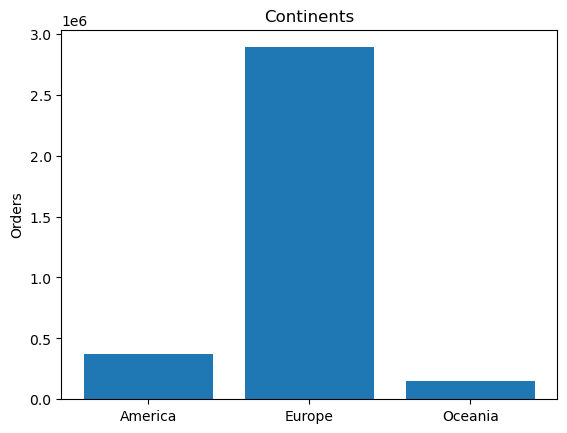

In [5]:
plt.title("Continents")
labels, counts = np.unique(df_sales_merged["continent"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.ylabel("Orders")
plt.show()

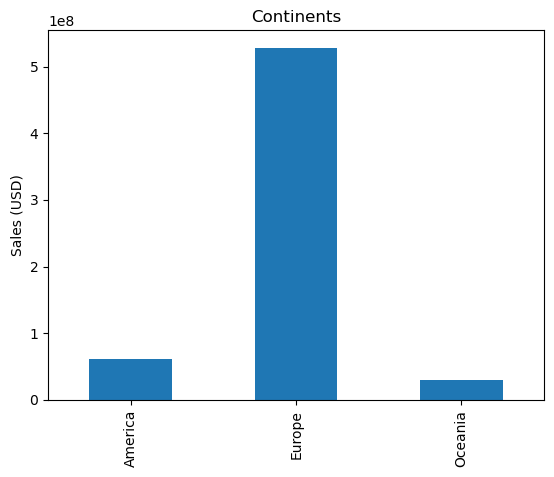

In [6]:
plt.title("Continents")
df_sales_merged.groupby("continent")["sales_uds"].sum().plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.xlabel("")
plt.show()

The majority of the business is conducted in Europe, possibly an indicator that the sellers are mostly located in Europe.

In [7]:
df_sales_merged.groupby("continent")["sales_uds"].describe()

count        mean          std       min        25%  \
continent                                                            
America     368788.0  167.096051   201.586211  3.980000  59.420000   
Europe     2890499.0  182.692856  9271.083497  0.705064  46.530998   
Oceania     153044.0  192.008637  1199.316338  0.732528  70.739474   

                  50%         75%           max  
continent                                        
America    106.480625  199.990000  3.378497e+04  
Europe      96.562003  205.036089  1.574134e+07  
Oceania    124.403062  232.263192  4.625350e+05

America prices are fairly stable compared to Europe and Oceania.

### Country

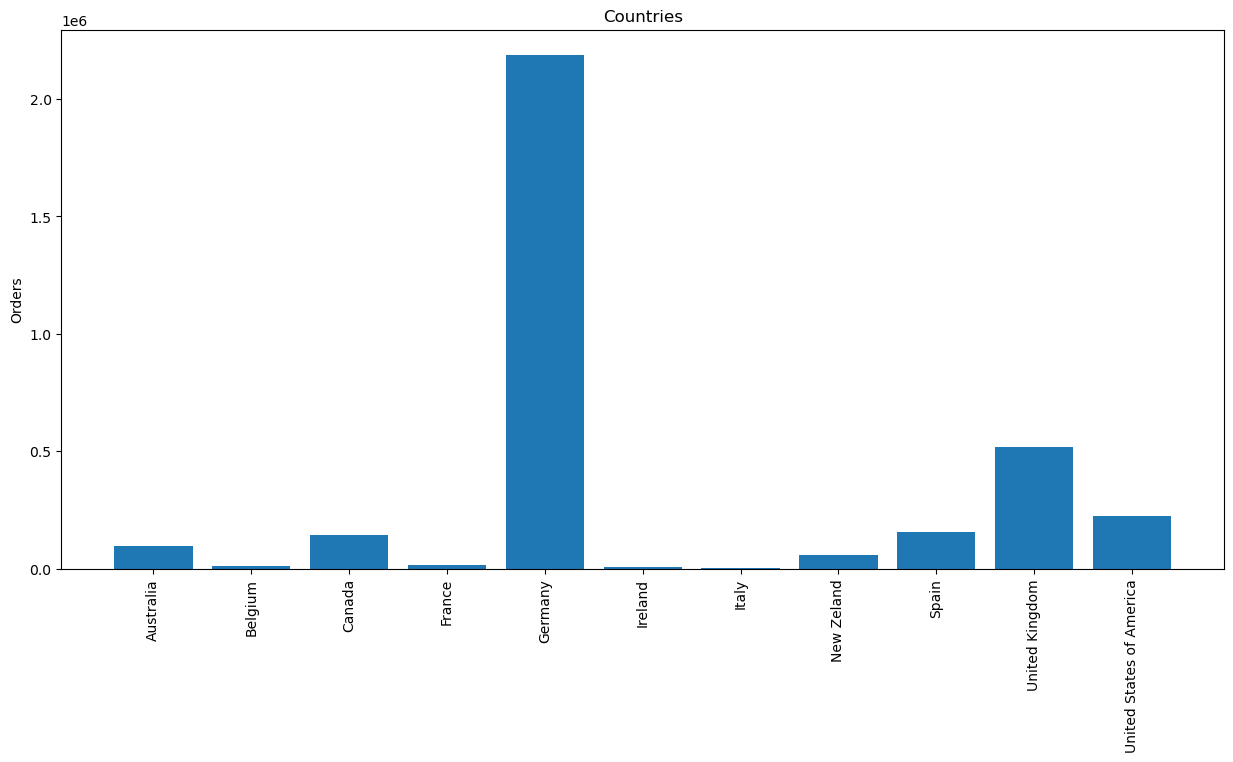

In [8]:
plt.figure(figsize=(15, 7))
plt.title("Countries")
labels, counts = np.unique(df_sales_merged["country"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.ylabel("Orders")
plt.xticks(rotation=90)
plt.show()

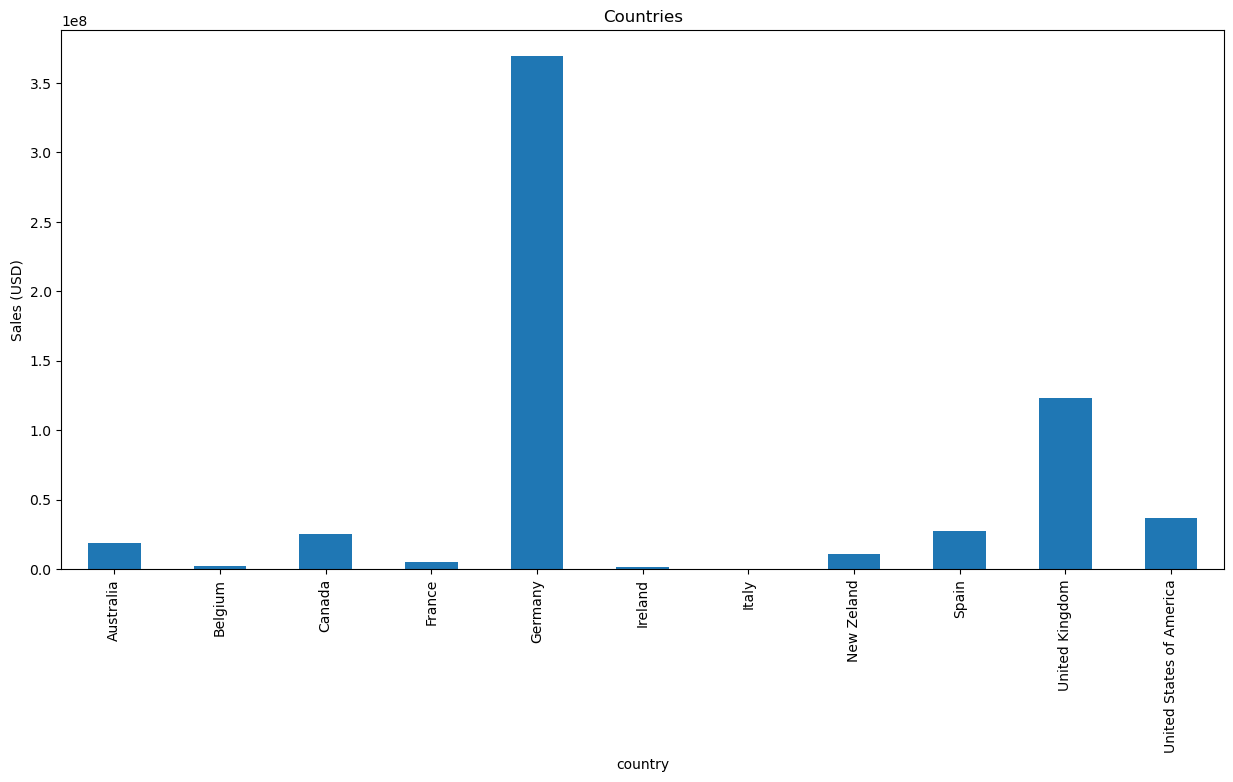

In [9]:
plt.figure(figsize=(15, 7))
plt.title("Countries")
df_sales_merged.groupby("country")["sales_uds"].sum().plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.xticks(rotation=90)
plt.show()

Germany is the biggest buyer by far, both in terms of units sold and revenue.

In [10]:
df_sales_merged["country"].unique()

array(['Germany', 'Spain', 'United Kingdom', 'Australia',
       'United States of America', 'Canada', 'Italy', 'Ireland', 'France',
       'New Zeland', 'Belgium'], dtype=object)

In [11]:
df_sales_merged.groupby("country")["sales_uds"].std()

country
Australia                    1504.967655
Belgium                       203.076767
Canada                        189.361874
France                        371.062030
Germany                       260.691809
Ireland                       292.216112
Italy                         158.753701
New Zeland                    178.414310
Spain                         240.993832
United Kingdom              21936.193992
United States of America      208.977094
Name: sales_uds, dtype: float64

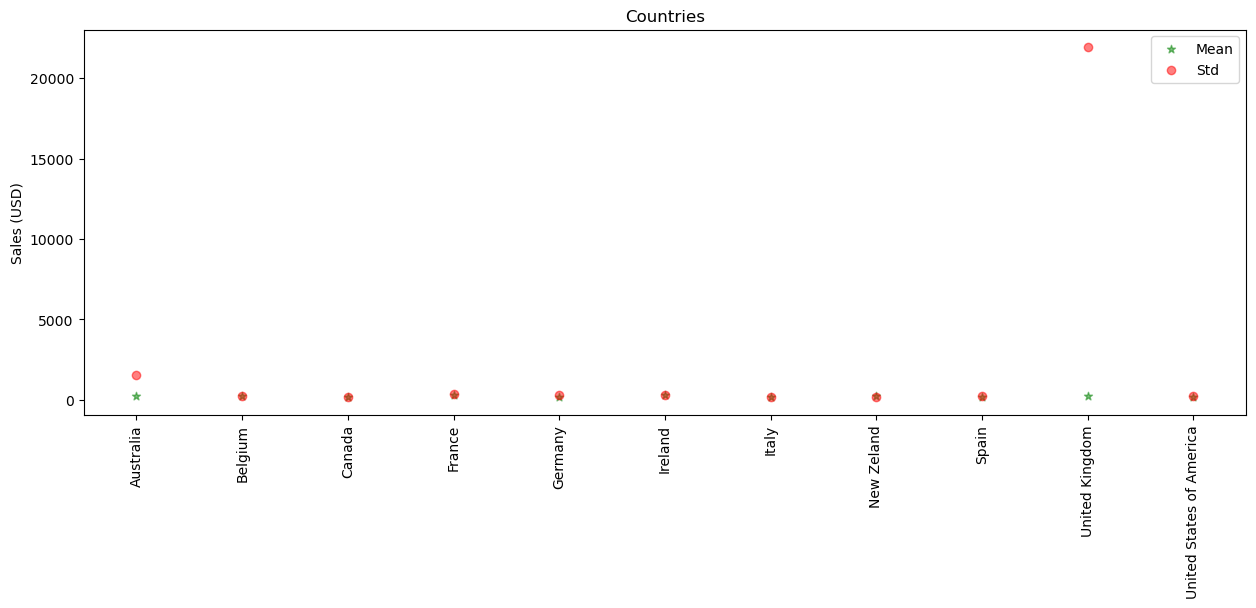

In [12]:
plt.figure(figsize=(15, 5))
plt.title("Countries")
feature_str = "country"
mean_df = df_sales_merged.groupby(feature_str)["sales_uds"].mean().rename("mean").reset_index(feature_str)
std_df = df_sales_merged.groupby(feature_str)["sales_uds"].std().rename("std").reset_index(feature_str)
plt.scatter(mean_df[feature_str], mean_df["mean"], c="g", marker="*", label="Mean", alpha=0.50)
plt.scatter(std_df[feature_str], std_df["std"], c="r", marker="o", label="Std", alpha=0.50)
plt.ylabel("Sales (USD)")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

The UK has an high amount of variance of its prices, with Australia is a distant second place.

### Region

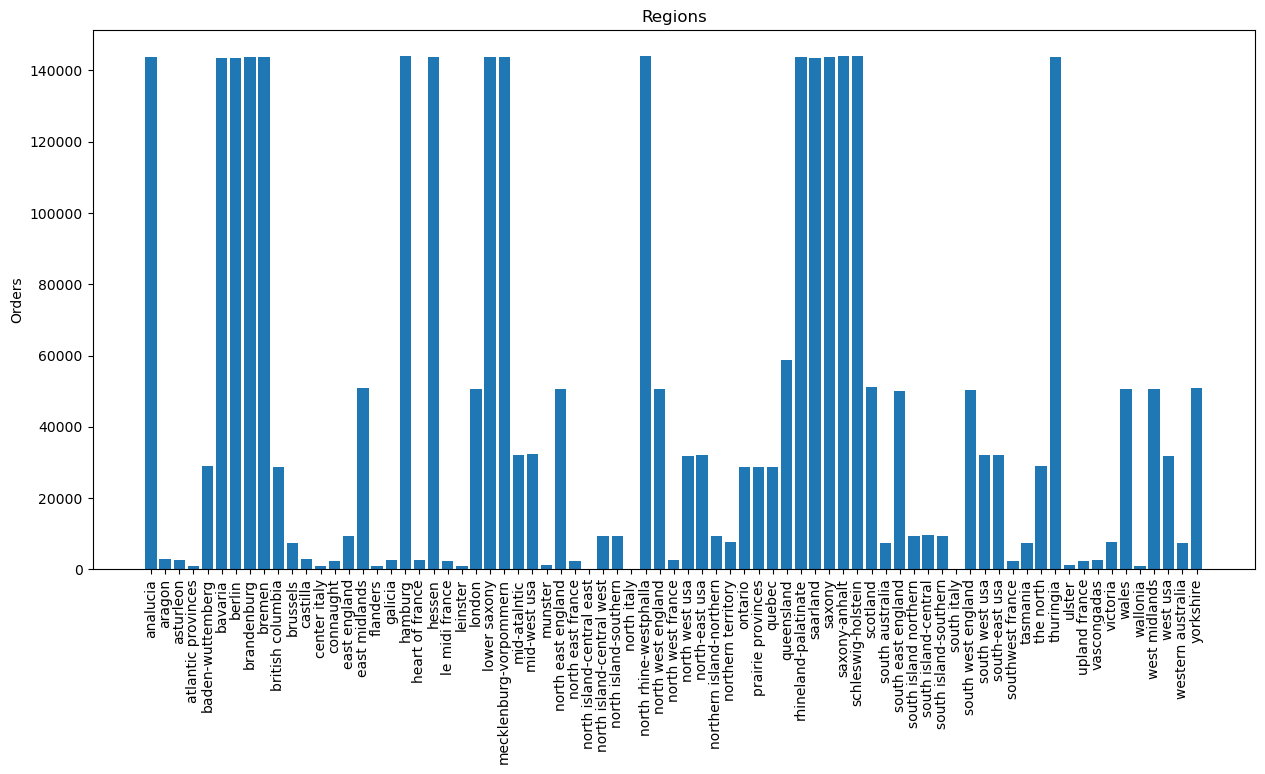

In [13]:
plt.figure(figsize=(15, 7))
plt.title("Regions")
labels, counts = np.unique(df_sales_merged["region"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.ylabel("Orders")
plt.xticks(rotation = 90)
plt.show()

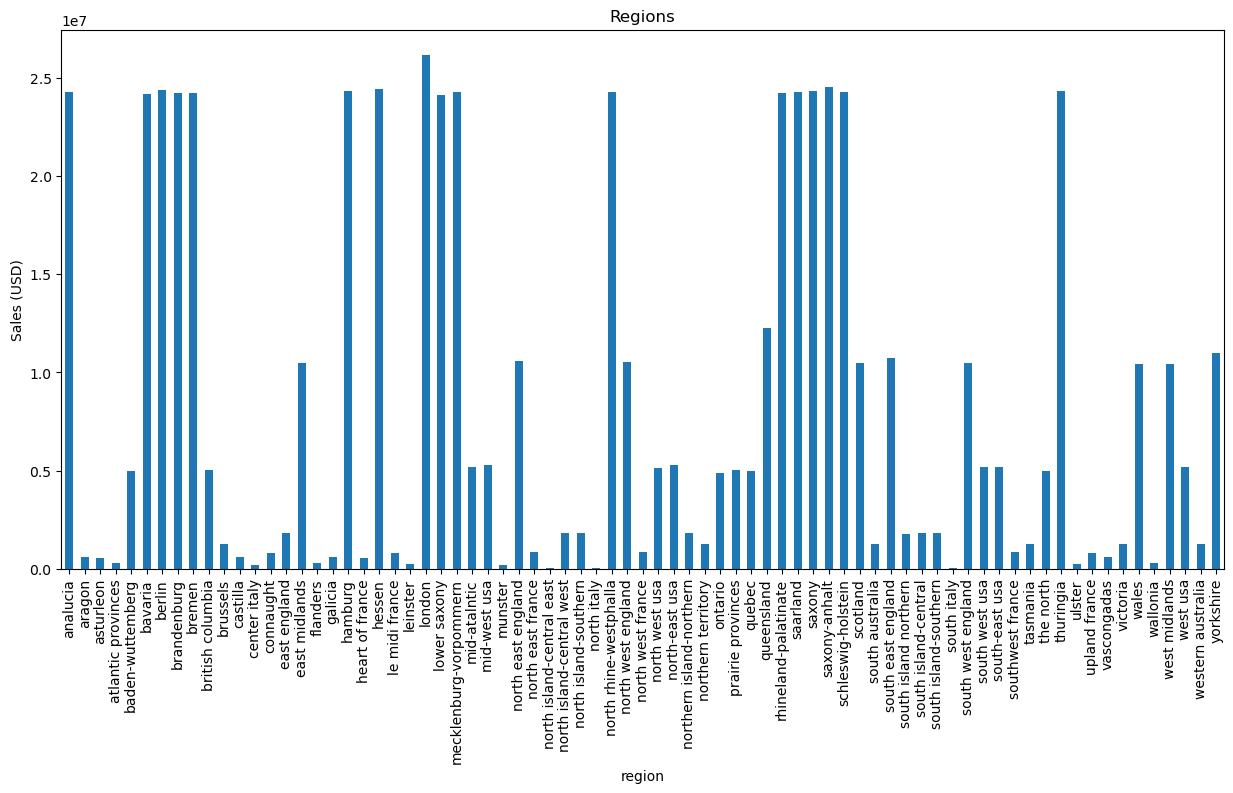

In [14]:
plt.figure(figsize=(15, 7))
plt.title("Regions")
df_sales_merged.groupby("region")["sales_uds"].sum().plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.xticks(rotation = 90)
plt.show()

All the high peaks, except the first one (andalucia), are german regions.

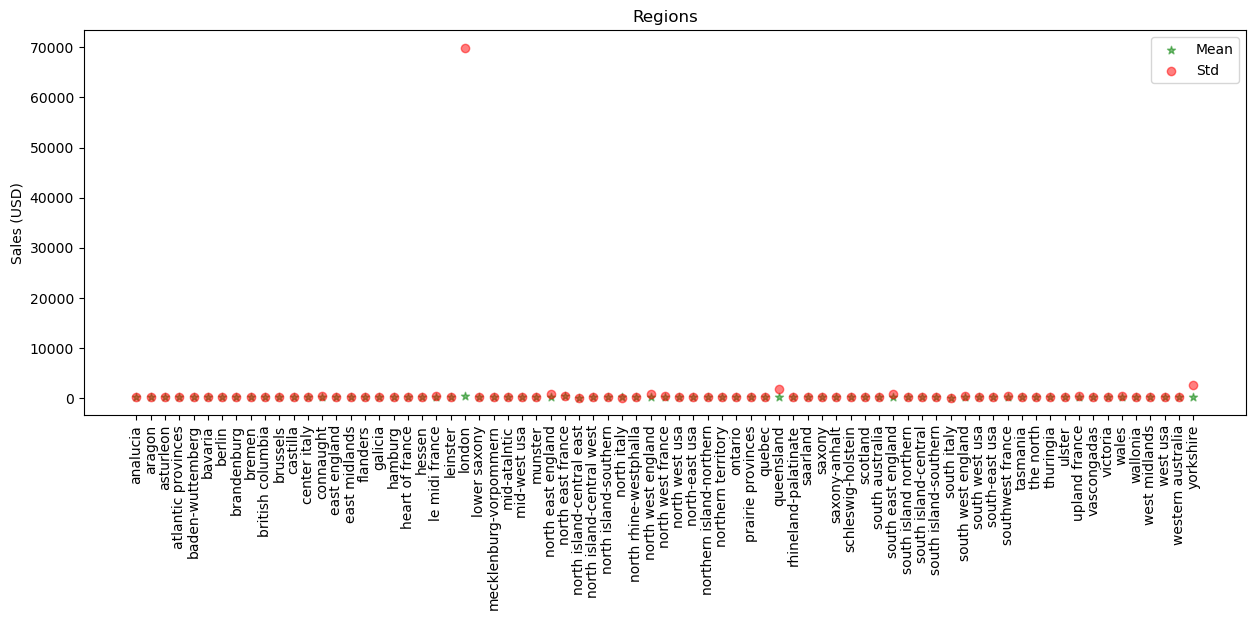

In [15]:
plt.figure(figsize=(15, 5))
plt.title("Regions")
feature_str = "region"
mean_df = df_sales_merged.groupby(feature_str)["sales_uds"].mean().rename("mean").reset_index(feature_str)
std_df = df_sales_merged.groupby(feature_str)["sales_uds"].std().rename("std").reset_index(feature_str)
plt.scatter(mean_df[feature_str], mean_df["mean"], c="g", marker="*", label="Mean", alpha=0.50)
plt.scatter(std_df[feature_str], std_df["std"], c="r", marker="o", label="Std", alpha=0.50)
plt.ylabel("Sales (USD)")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

London seems to be the region that skews all the rest of the UK sales.

In [16]:
df_sales_merged.loc[df_sales_merged["region"] == "north east england"].sort_values("sales_uds", ascending=False).head()

Id  ram_code     brand                  name  memory memory_type  \
4999285  5899    2181.0  KINGSTON  Kingston Hyperx Fury     4.0        DDR3   
4926333  5795    2077.0  KINGSTON              Kingston    16.0        DDR4   
3580765  4591     873.0   CRUCIAL               Crucial   256.0        DDR4   
3580771  4592     874.0   CRUCIAL               Crucial   256.0        DDR4   
3580726  4591     873.0   CRUCIAL               Crucial   256.0        DDR4   

         clock  time_code  year  month  ...  week  geo_code  continent  \
4999285   1333   20160521  2016      5  ...    21        61     Europe   
4926333   2133   20160521  2016      5  ...    21        61     Europe   
3580765   2400   20180405  2018      4  ...    14        61     Europe   
3580771   2666   20180201  2018      2  ...     5        61     Europe   
3580726   2400   20180114  2018      1  ...     2        61     Europe   

                country              region currency vendor_code  \
4999285  United Kingdom  north east england      GBP          62   
4926333  United Kingdom  north east england      GBP          62   
3580765  United Kingdom  north east england      GBP          68   
3580771  United Kingdom  north east england      GBP          68   
3580726  United Kingdom  north east england      GBP          68   

               name_vendor      sales_uds  sales_currency  
4999285  PC World Business  190798.502803   131387.665000  
4926333  PC World Business   16174.155073    11137.846667  
3580765   pricespy_unknown    4484.066449     3204.000000  
3580771   pricespy_unknown    4409.335983     3095.420000  
3580726   pricespy_unknown    4302.976620     3133.320000  

[5 rows x 21 columns]

The top values of the region are clearly outliers.

### Currency

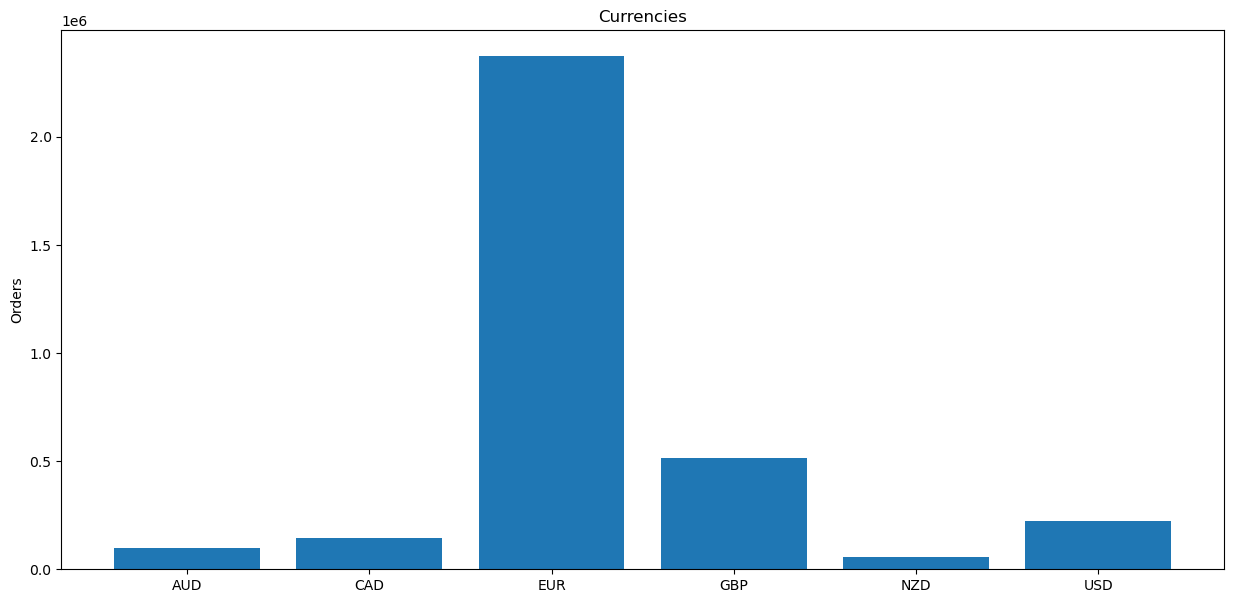

In [17]:
plt.figure(figsize=(15, 7))
plt.title("Currencies")
labels, counts = np.unique(df_sales_merged["currency"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.ylabel("Orders")
plt.show()

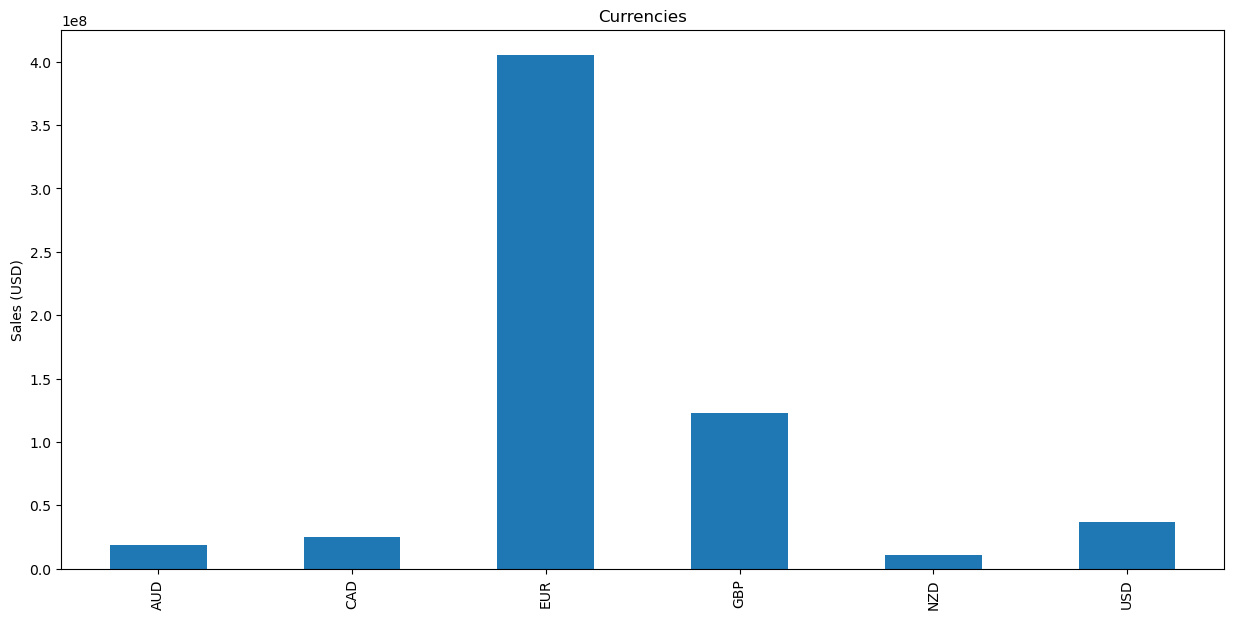

In [18]:
plt.figure(figsize=(15, 7))
plt.title("Currencies")
df_sales_merged.groupby("currency")["sales_uds"].sum().plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.xlabel("")
plt.show()

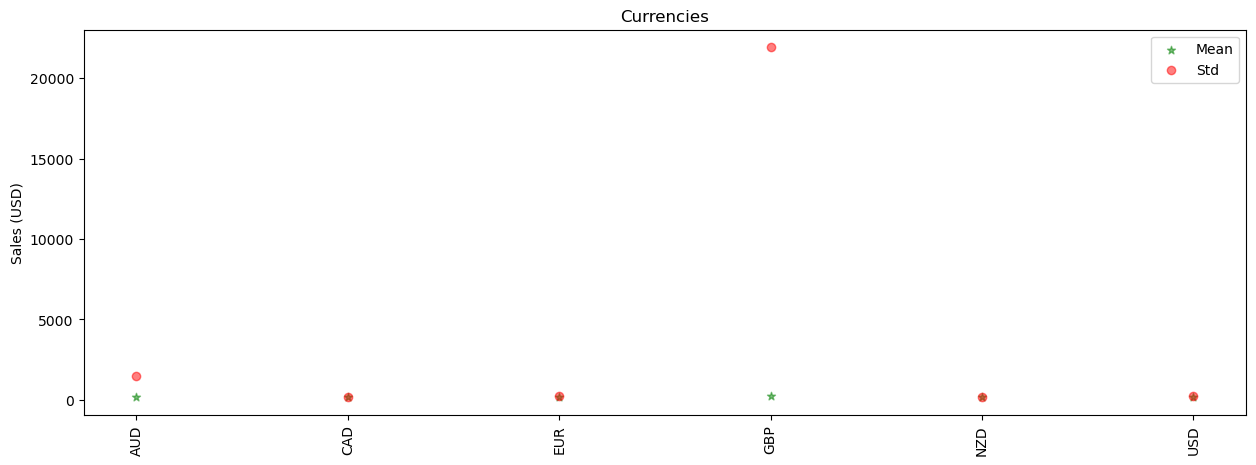

In [19]:
plt.figure(figsize=(15, 5))
plt.title("Currencies")
feature_str = "currency"
mean_df = df_sales_merged.groupby(feature_str)["sales_uds"].mean().rename("mean").reset_index(feature_str)
std_df = df_sales_merged.groupby(feature_str)["sales_uds"].std().rename("std").reset_index(feature_str)
plt.scatter(mean_df[feature_str], mean_df["mean"], c="g", marker="*", label="Mean", alpha=0.50)
plt.scatter(std_df[feature_str], std_df["std"], c="r", marker="o", label="Std", alpha=0.50)
plt.ylabel("Sales (USD)")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

The australian and british currencies are again on top.

#### Analysis of exchange rate between currencies

In [20]:
exchange_cur_usd = df_sales_merged.groupby("currency").apply(lambda x: x["sales_currency"]/x["sales_uds"])
exchange_cur_usd.groupby("currency").describe()

count      mean       std       min       25%       50%  \
currency                                                                
AUD         96396.0  1.013293  0.286888  0.629580  0.755755  0.813305   
CAD        144653.0  1.292795  0.050212  0.800675  1.269350  1.293910   
EUR       2374526.0  0.865309  0.084751  0.717792  0.813372  0.880615   
GBP        515973.0  0.758413  0.100920  0.629580  0.708700  0.758075   
NZD         56648.0  1.404504  0.044923  0.803325  1.376200  1.399000   
USD        224135.0  1.000000  0.000000  1.000000  1.000000  1.000000   

               75%       max  
currency                      
AUD       1.314050  1.394000  
CAD       1.320665  1.374285  
EUR       0.909845  1.394000  
GBP       0.784400  1.493850  
NZD       1.435625  1.493850  
USD       1.000000  1.000000

From these results we can see that there are no apparent errors in the input of data in the dataset concerning the relative value of currencies (exchange value is stable), this allows us to continue using the USD as our main currency for analysis of prices, even outside the US market.  

Note that this table also tells us that the feature sales_uds is indeed the value in US dollars (possibly misspelled).

### Value checks

Let's check for missing/duplicate/invalid values.

In [21]:
print(df_geo["geo_code"].duplicated().any())

False


In [22]:
df_geo.groupby(["continent","country", "region", "currency"]).size().describe()

count    75.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
dtype: float64

Each combination of attributes in the dataset is unique, therefore there are no entries with different geo_code but same content.

In [23]:
print(df_geo["continent"].isna().any())
print(df_geo["country"].isna().any())
print(df_geo["region"].isna().any())
print(df_geo["currency"].isna().any())

False
False
False
False


No missing values in sight.

## Ram

In [24]:
df_ram.head()

brand   name  memory memory_type  clock
ram_code                                         
2         ADATA  Adata     1.0         DDR    333
1         ADATA  Adata     0.5         DDR    400
3         ADATA  Adata     1.0         DDR    400
4         ADATA  Adata     2.0         DDR    400
5         ADATA  Adata     1.0        DDR2    667

### Brands

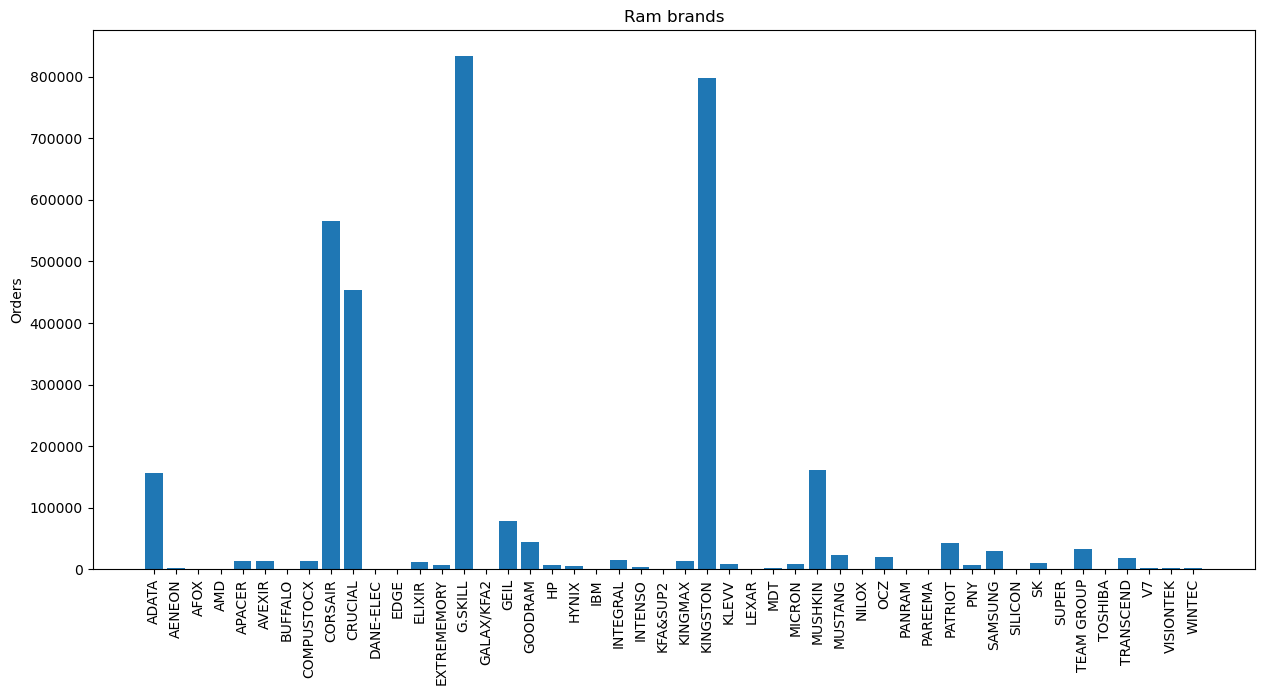

In [25]:
plt.figure(figsize=(15, 7))
plt.title("Ram brands")
labels, counts = np.unique(df_sales_merged["brand"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.ylabel("Orders")
plt.xticks(rotation = 90)
plt.show()

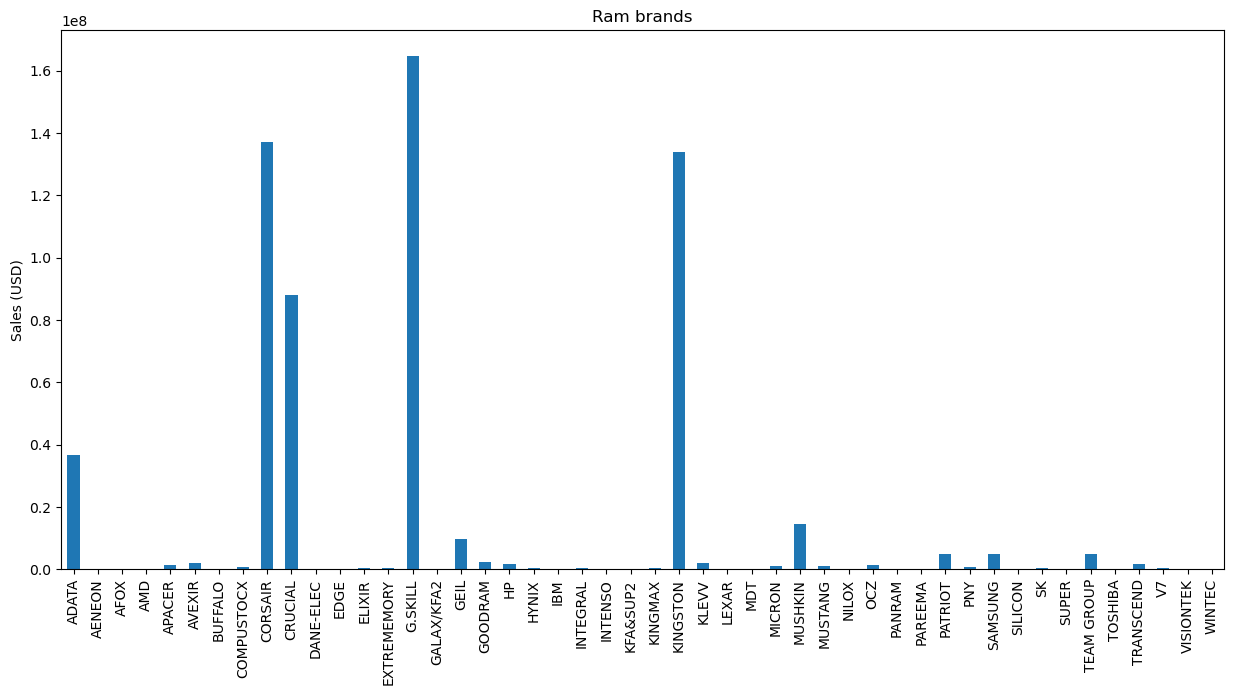

In [26]:
plt.figure(figsize=(15, 7))
plt.title("Ram brands")
brand_sales = df_sales_merged.groupby("brand")["sales_uds"].sum()
brand_sales.plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.xlabel("")
plt.xticks(rotation = 90)
plt.show()

The sales value follows the trend of the amount of orders of each vendor.

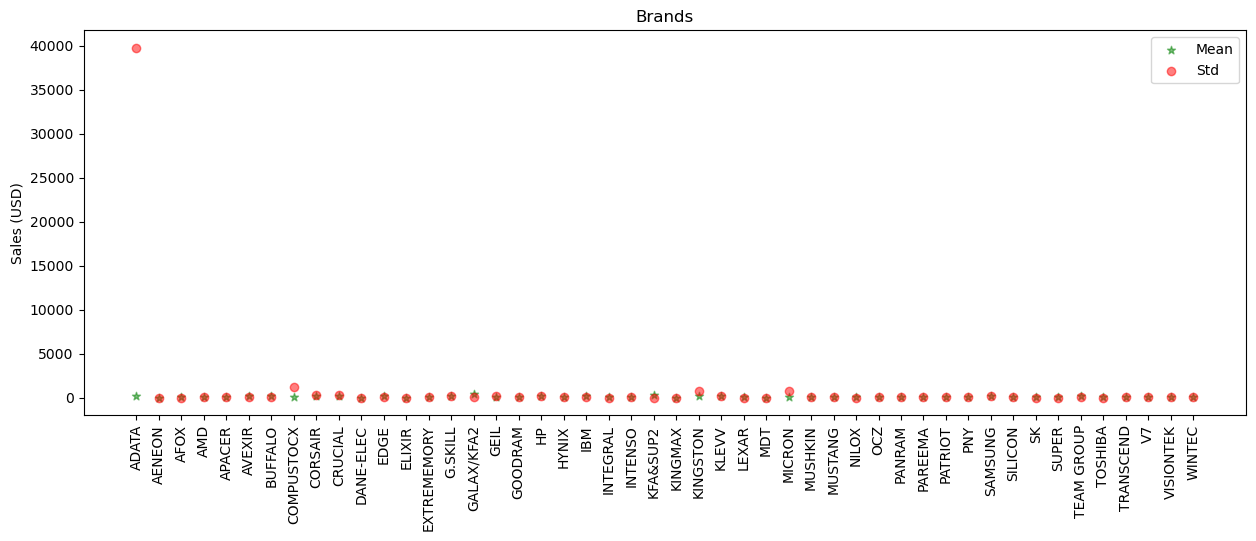

In [27]:
plt.figure(figsize=(15, 5))
plt.title("Brands")
feature_str = "brand"
mean_df = df_sales_merged.groupby(feature_str)["sales_uds"].mean().rename("mean").reset_index(feature_str)
std_df = df_sales_merged.groupby(feature_str)["sales_uds"].std().rename("std").reset_index(feature_str)
plt.scatter(mean_df[feature_str], mean_df["mean"], c="g", marker="*", label="Mean", alpha=0.50)
plt.scatter(std_df[feature_str], std_df["std"], c="r", marker="o", label="Std", alpha=0.50)
plt.ylabel("Sales (USD)")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

ADATA seems to have quite some outliers among its sales.

### Names

There are too many entries to visualise the "name" distribution with ease, let's restrict the plot to the most sold entries.

In [28]:
ram_names_redux = df_sales_merged.groupby("name").size()
ram_names_redux = ram_names_redux.sort_values(ascending=False).loc[ram_names_redux > ram_names_redux.quantile(0.75)]

names_redux_df = df_sales_merged.loc[df_sales_merged["name"].isin(ram_names_redux.index)]
unq_ram_redux = np.unique(ram_names_redux.index)

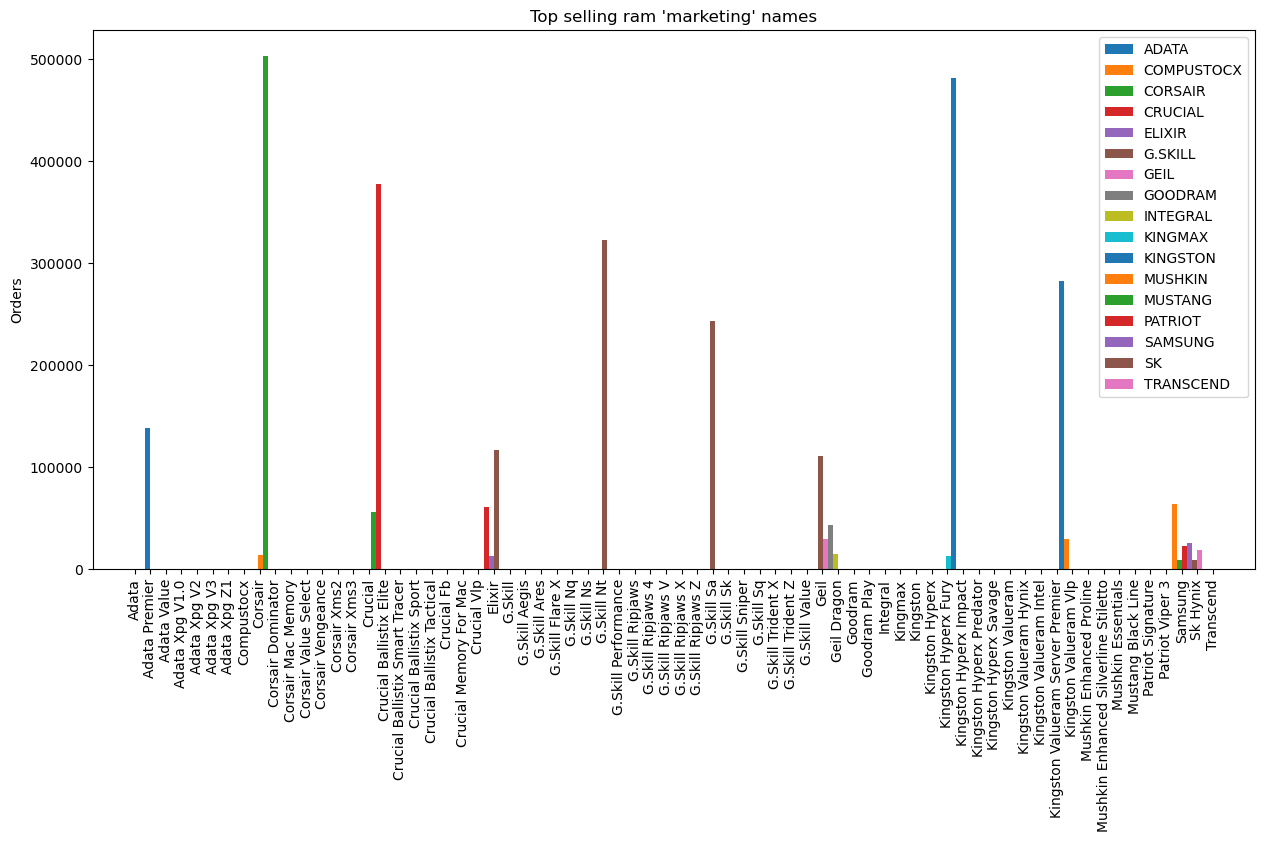

In [29]:
plt.figure(figsize=(15, 7))
plt.title("Top selling ram 'marketing' names")
brands = names_redux_df["brand"].unique()
plt.hist([names_redux_df.loc[names_redux_df["brand"] == x, 'name'] for x in brands], label=brands)
plt.xticks(rotation=90)
plt.ylabel("Orders")
plt.legend()
plt.show()

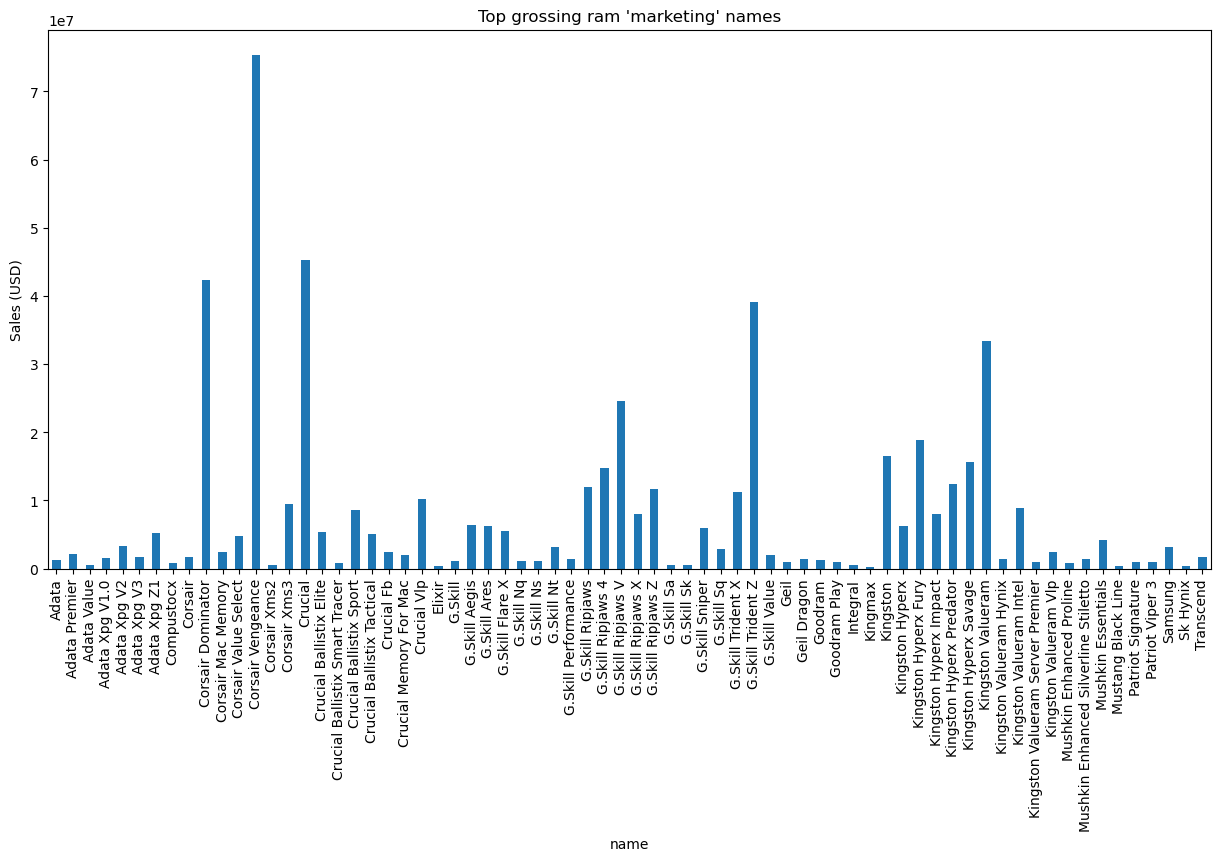

In [30]:
brands = names_redux_df["brand"].unique()
name_sales = names_redux_df.groupby(["name"])["sales_uds"].sum().rename("sum")
names_sales = name_sales.reset_index(["name"])

names_sales.set_index("name").plot(by="sum", kind="bar", \
                    title="Top grossing ram 'marketing' names", figsize=(15, 7), legend=False)
plt.xticks(rotation=90)
plt.ylabel("Sales (USD)")
plt.show()

The distribution of the sales revenue does not reflect the number of items sold from that product series.  
This could be both because of a higher-tier product or because of outliers.

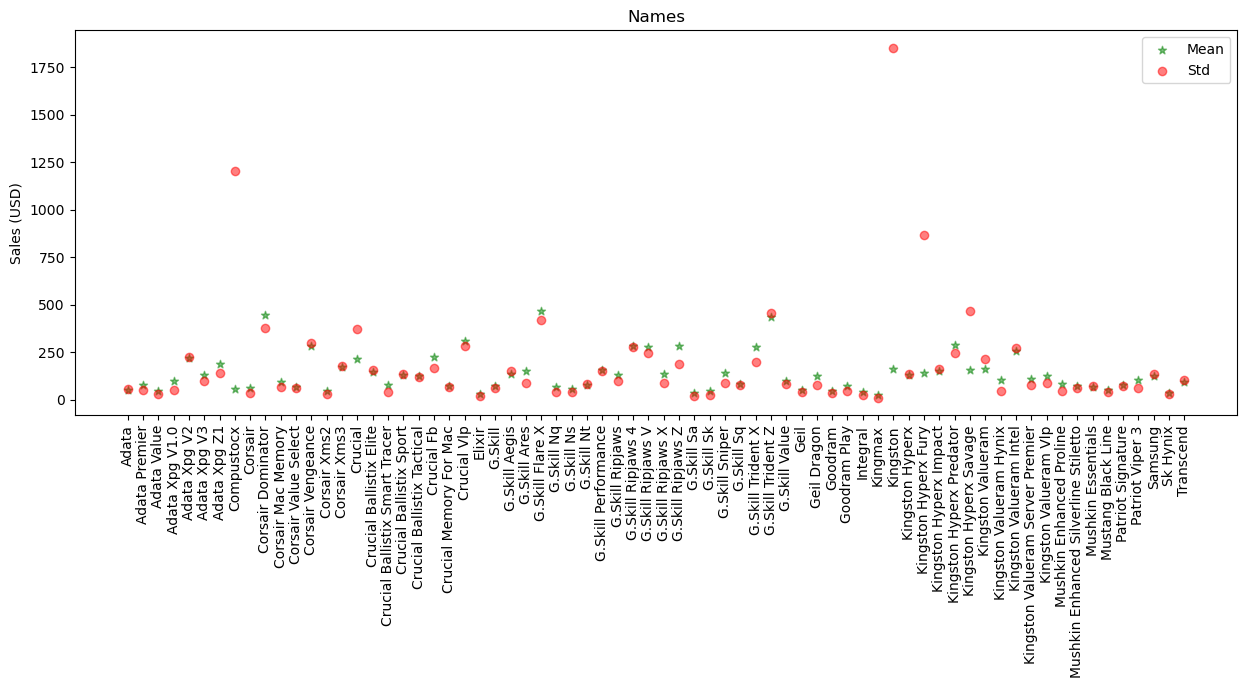

In [31]:
plt.figure(figsize=(15, 5))
plt.title("Names")
feature_str = "name"
mean_df = names_redux_df.groupby(feature_str)["sales_uds"].mean().rename("mean").reset_index(feature_str)
std_df = names_redux_df.groupby(feature_str)["sales_uds"].std().rename("std").reset_index(feature_str)
plt.scatter(mean_df[feature_str], mean_df["mean"], c="g", marker="*", label="Mean", alpha=0.50)
plt.scatter(std_df[feature_str], std_df["std"], c="r", marker="o", label="Std", alpha=0.50)
plt.ylabel("Sales (USD)")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

These values are still within a reasonable range, however when plotting the names with the most variance we get a different view.

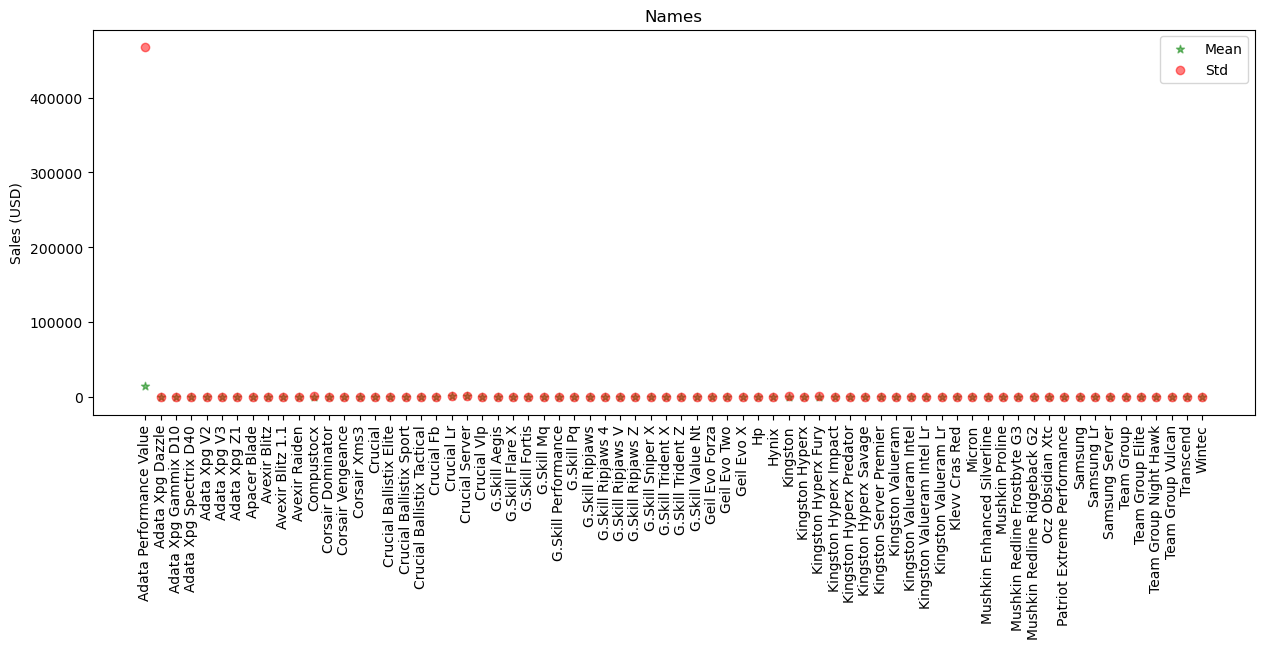

In [32]:
names_top_std_df = df_sales_merged.groupby("name")["sales_uds"].std().sort_values(ascending=False)
names_top_std_df = names_top_std_df.loc[names_top_std_df > names_top_std_df.quantile(0.75)]
names_top_std_df = df_sales_merged.loc[df_sales_merged["name"].isin(names_top_std_df.index)]

plt.figure(figsize=(15, 5))
plt.title("Names")
feature_str = "name"
mean_df = names_top_std_df.groupby(feature_str)["sales_uds"].mean().rename("mean").reset_index(feature_str)
std_df = names_top_std_df.groupby(feature_str)["sales_uds"].std().rename("std").reset_index(feature_str)
plt.scatter(mean_df[feature_str], mean_df["mean"], c="g", marker="*", label="Mean", alpha=0.50)
plt.scatter(std_df[feature_str], std_df["std"], c="r", marker="o", label="Std", alpha=0.50)
plt.ylabel("Sales (USD)")
plt.xticks(rotation=90)
plt.legend()
plt.show()

Spot the outlier.

### Memory type

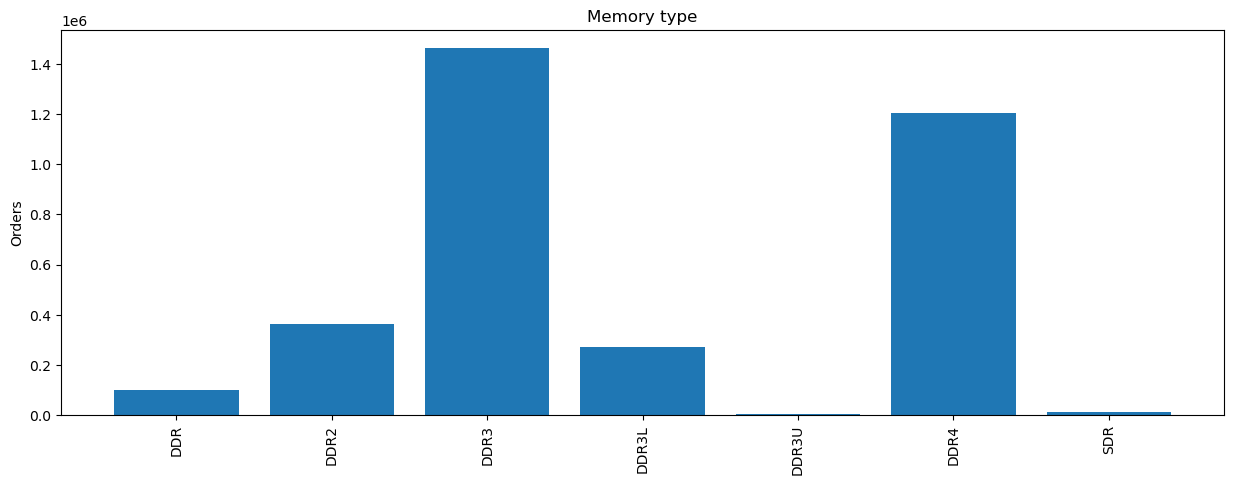

In [33]:
plt.figure(figsize=(15, 5))
plt.title("Memory type")
labels, counts = np.unique(df_sales_merged["memory_type"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.ylabel("Orders")
plt.xticks(rotation = 90)
plt.show()

No surprises here considering the timeframe in which the sales take place.

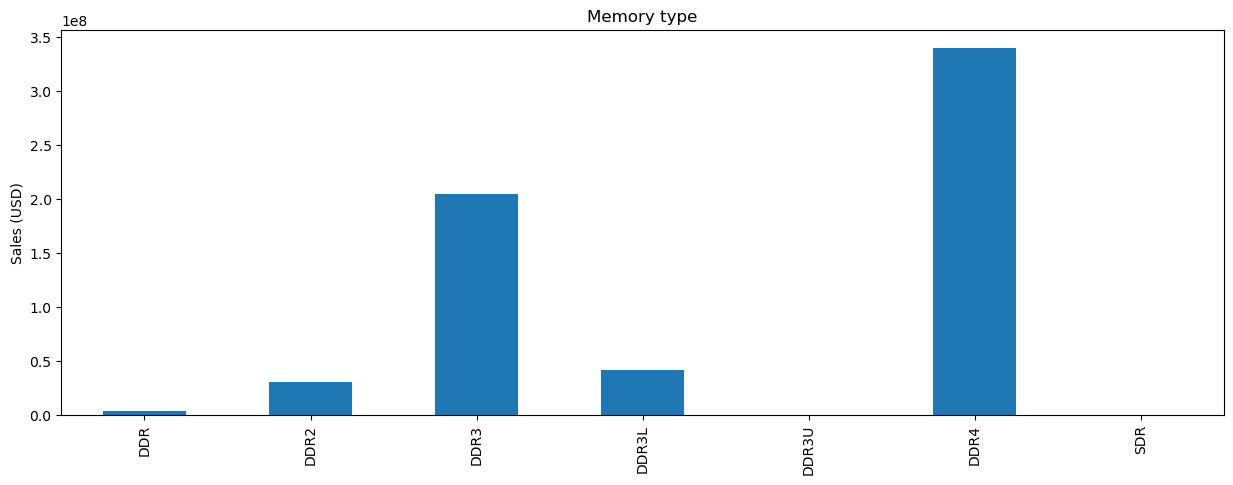

In [34]:
plt.figure(figsize=(15, 5))
plt.title("Memory type")
mem_type_sales = df_sales_merged.groupby("memory_type")["sales_uds"].sum()
mem_type_sales.plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.xlabel("")
plt.xticks(rotation = 90)
plt.show()

The newest technologies generated the most revenue, which should be expected given both the higher price and the recent introduction and consequent hardware change from the end-user.

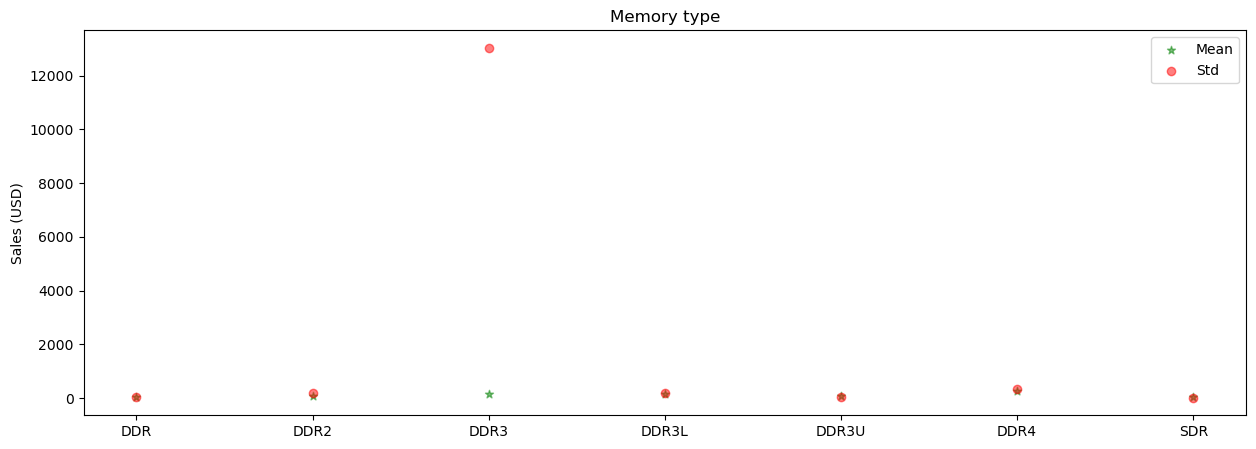

In [35]:
plt.figure(figsize=(15, 5))
plt.title("Memory type")
feature_str = "memory_type"
mean_df = df_sales_merged.groupby(feature_str)["sales_uds"].mean().rename("mean").reset_index(feature_str)
std_df = df_sales_merged.groupby(feature_str)["sales_uds"].std().rename("std").reset_index(feature_str)
plt.scatter(mean_df[feature_str], mean_df["mean"], c="g", marker="*", label="Mean", alpha=0.50)
plt.scatter(std_df[feature_str], std_df["std"], c="r", marker="o", label="Std", alpha=0.50)
plt.ylabel("Sales (USD)")
plt.xlabel("")
plt.legend()
plt.show()

The DDR3 category presents an high amount of variance compared to the others, probably due to the presence of outliers.  
Further investigations will be performed in the outlier section.

In [36]:
df_sales_merged.groupby("memory_type")["sales_uds"].describe()

count        mean           std        min        25%  \
memory_type                                                              
DDR           100612.0   35.918339     27.980781   3.289655  19.668977   
DDR2          361447.0   83.615612    201.959392   0.705064  22.414456   
DDR3         1463100.0  139.607053  13032.602313   2.104936  46.783726   
DDR3L         268999.0  152.770178    191.956660   8.787894  45.845701   
DDR3U           3661.0   94.781882     29.204194  39.892213  72.843514   
DDR4         1203526.0  281.865324    330.082389   3.177368  99.990000   
SDR            10986.0   28.448155     14.134141   7.799262  17.043557   

                    50%         75%           max  
memory_type                                        
DDR           28.774918   43.382283  2.543665e+02  
DDR2          36.758714   77.009302  6.245039e+03  
DDR3          85.192780  155.813373  1.574134e+07  
DDR3L         86.026332  173.142330  2.327290e+03  
DDR3U         92.578759  118.616080  1.650207e+02  
DDR4         185.245431  335.953341  4.826446e+04  
SDR           25.089772   34.230355  7.491976e+01

### Value checks

In [37]:
df_ram.describe()

memory        clock
count  3705.000000  3705.000000
mean     16.280938  1969.170040
std      20.422881   797.256751
min       0.125000   100.000000
25%       4.000000  1333.000000
50%       8.000000  1866.000000
75%      16.000000  2400.000000
max     256.000000  4600.000000

The values are all within reasonable range, there are no obvious values out of range (ie 0).

In [38]:
print(df_ram["brand"].isna().any())
print(df_ram["name"].isna().any())
print(df_ram["memory_type"].isna().any())

False
False
False


No missing values.

### Correlation

In [39]:
df_ram.corr()

memory     clock
memory  1.000000  0.331674
clock   0.331674  1.000000

The RAMs included in the dataset do not have a correlation between their clock and memory capacity. 

## Sales

In [40]:
df_sales.head()

Id  ram_code  time_code  geo_code  vendor_code  sales_uds  \
2602347  3719       1.0   20130322        25           32  13.749032   
2602348  3719       1.0   20130323        18           32  13.828708   
2602349  3719       1.0   20130326        28           32  13.694297   
2602350  3719       1.0   20130327        25           32  13.690530   
2602351  3719       1.0   20130328        27           32  13.605216   

         sales_currency  
2602347           10.65  
2602348           10.65  
2602349           10.65  
2602350           10.65  
2602351           10.65

In [41]:
df_sales.describe()

Id      ram_code     time_code      geo_code   vendor_code  \
count  3.412331e+06  3.412331e+06  3.412331e+06  3.412331e+06  3.412331e+06   
mean   5.257606e+03  1.539606e+03  2.016166e+07  3.293352e+01  3.949093e+01   
std    8.536889e+02  8.536889e+02  1.309320e+04  1.896925e+01  1.416273e+01   
min    3.719000e+03  1.000000e+00  2.013032e+07  1.000000e+00  1.000000e+00   
25%    4.522000e+03  8.040000e+02  2.015112e+07  2.000000e+01  3.200000e+01   
50%    5.141000e+03  1.423000e+03  2.016111e+07  2.600000e+01  3.200000e+01   
75%    5.957000e+03  2.239000e+03  2.017081e+07  3.200000e+01  4.500000e+01   
max    7.422000e+03  3.704000e+03  2.018041e+07  7.500000e+01  8.100000e+01   

          sales_uds  sales_currency  
count  3.412331e+06    3.412331e+06  
mean   1.814250e+02    1.590673e+02  
std    8.536833e+03    5.426377e+03  
min    7.050645e-01    5.000000e-01  
25%    4.858296e+01    4.202000e+01  
50%    9.906795e+01    8.760000e+01  
75%    2.058690e+02    1.829000e+02  
max    1.574134e+07    1.000000e+07

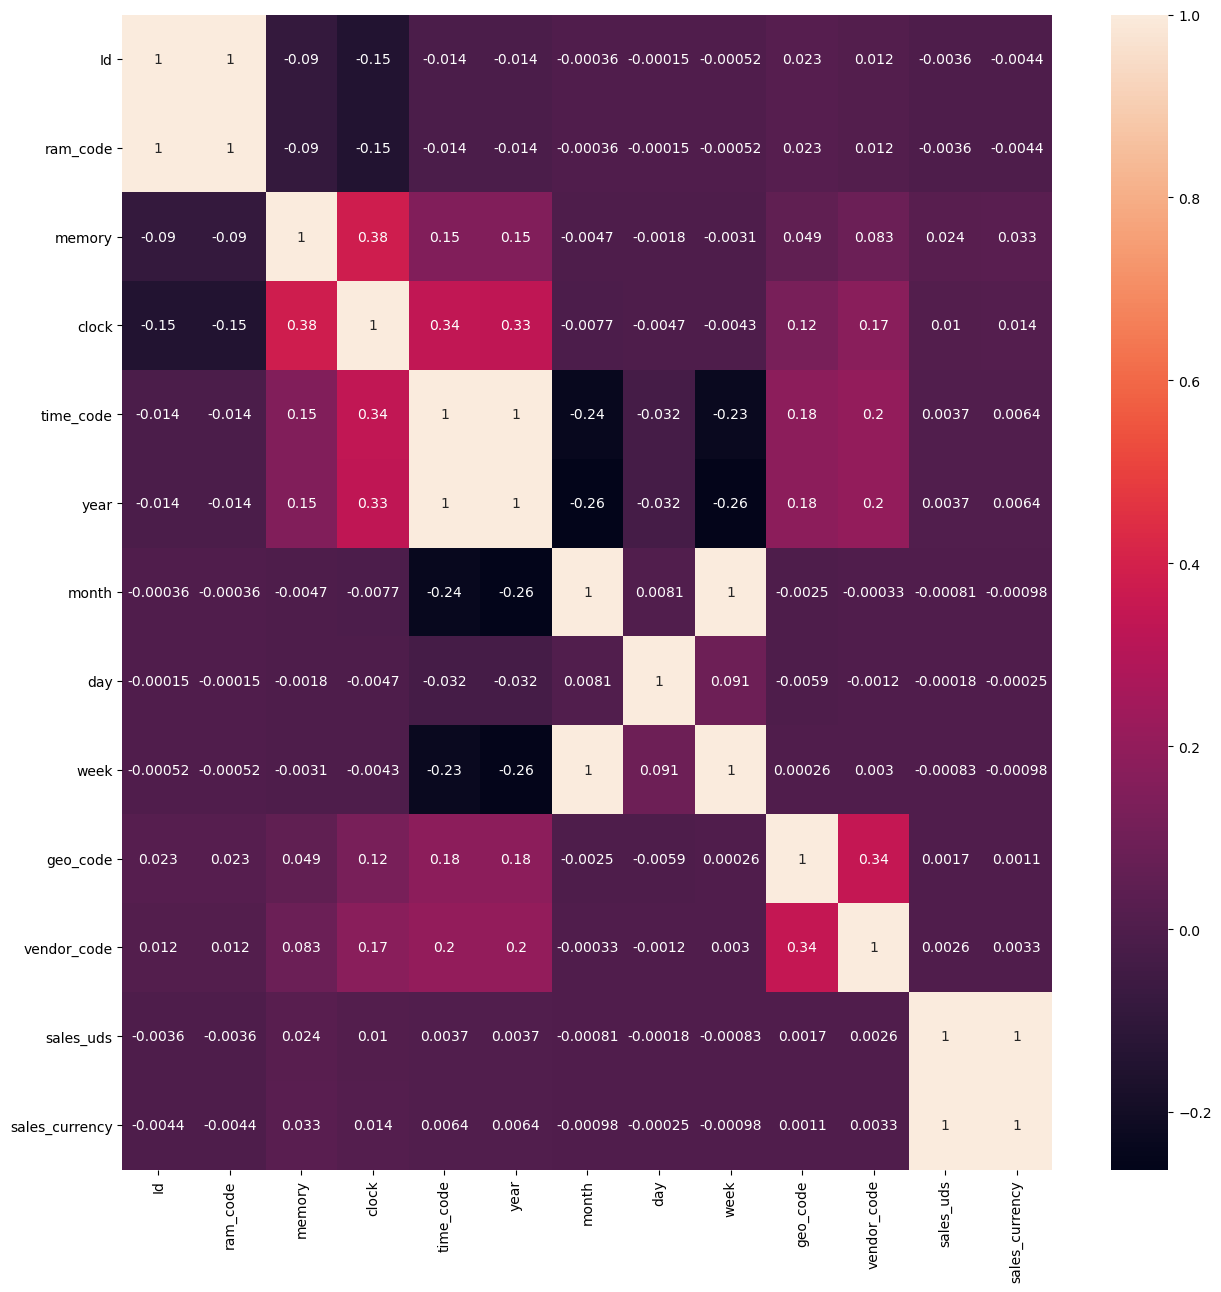

In [42]:
num_sales_df = df_sales_merged.drop(["brand", "name", "memory_type", "continent", "country", "region", "currency", "name_vendor"], axis=1)
plt.figure(figsize=(15,15))
sn.heatmap(num_sales_df.corr(), annot=True)
plt.show()

The majority of the correlation coefficients present are irrelevant, some however give us some information about the meaning of the data:  
- (ram_code, id): it implies that there is a 1-to-1 relationship between them, in other words for each id we have a single ram_code and viceversa.  
    One of these is redundant.
- (sales_uds, sales_currency): interesting indicator of the stability of the currencies, implies that the usd lost value only when the others lost it.  
    Probably due to the presence of strong currencies only.
- (week, month): this correlation is a given since month is about week/4.  

In [43]:
df_sales_merged.dtypes

Id                  int64
ram_code          float64
brand              object
name               object
memory            float64
memory_type        object
clock               int64
time_code           int64
year                int64
month               int64
day                 int64
week                int64
geo_code            int64
continent          object
country            object
region             object
currency           object
vendor_code         int64
name_vendor        object
sales_uds         float64
sales_currency    float64
dtype: object

The data types are as expected, all of the strings are being treated as generic objects.  
For the purposes of our analysis this is irrelevant.

### Id/ram_code meaning  
Given that Id/ram_code have virtually the same use, we want to check the relationship between them and the vendors.

In [44]:
df_sales_merged.groupby("vendor_code")["ram_code"].unique()

vendor_code
1     [448.0, 496.0, 497.0, 498.0, 507.0, 509.0, 510...
2     [113.0, 115.0, 117.0, 120.0, 144.0, 145.0, 146...
3     [48.0, 432.0, 433.0, 434.0, 435.0, 436.0, 437....
4     [48.0, 432.0, 433.0, 435.0, 436.0, 437.0, 438....
5     [15.0, 18.0, 19.0, 20.0, 21.0, 23.0, 24.0, 25....
                            ...                        
77    [444.0, 547.0, 549.0, 550.0, 552.0, 553.0, 659...
78    [225.0, 226.0, 227.0, 229.0, 230.0, 231.0, 232...
79    [432.0, 435.0, 437.0, 438.0, 439.0, 440.0, 441...
80    [14.0, 43.0, 97.0, 101.0, 108.0, 110.0, 143.0,...
81          [858.0, 861.0, 974.0, 976.0, 978.0, 1591.0]
Name: ram_code, Length: 78, dtype: object

The same vendor can have products with different ram_codes.  

In [45]:
df_sales_merged.groupby("ram_code")["vendor_code"].unique()

ram_code
1.0           [32]
2.0           [32]
3.0           [32]
4.0           [32]
5.0       [32, 68]
            ...   
3699.0        [47]
3700.0    [47, 49]
3701.0        [47]
3703.0        [47]
3704.0        [47]
Name: vendor_code, Length: 3119, dtype: object

Each product identified by ram_code can be sold by different vendors.

### geo_code meaning

In [46]:
df_sales_merged.groupby("vendor_code")["geo_code"].unique()

vendor_code
1                          [56, 53, 54, 58, 57, 55, 52]
2                          [72, 69, 75, 74, 73, 71, 70]
3     [36, 34, 39, 44, 35, 42, 40, 33, 41, 37, 43, 3...
4                                          [49, 51, 50]
5     [68, 61, 60, 63, 66, 59, 65, 2, 67, 64, 32, 17...
                            ...                        
77                                [5, 4, 6, 2, 3, 7, 1]
78                         [74, 73, 71, 72, 70, 75, 69]
79                                [2, 3, 4, 7, 5, 1, 6]
80                             [14, 12, 16, 11, 13, 15]
81          [59, 62, 68, 64, 2, 63, 60, 61, 67, 65, 66]
Name: geo_code, Length: 78, dtype: object

From this results we can infer that the relationship between geo_code and vendor_code is many-to-many.

### currency meaning

In [47]:
df_sales_merged.groupby("vendor_code")["currency"].unique()

vendor_code
1          [NZD, GBP]
2               [USD]
3               [EUR]
4          [EUR, NZD]
5     [GBP, AUD, EUR]
           ...       
77         [AUD, EUR]
78              [USD]
79         [AUD, EUR]
80         [CAD, EUR]
81         [GBP, AUD]
Name: currency, Length: 78, dtype: object

Many vendors also sell internationally.

### Relationship between ram characteristics and price  
In this section we look into the correlation between the features of a RAM module and its price.

In [48]:
df_sales_merged.corrwith(df_sales_merged["sales_uds"])[["memory", "clock"]]

memory    0.023777
clock     0.010018
dtype: float64

It seems that there is no correlation between memory/clock characteristics and sales_uds.  
This seems counterintuitive given that this features should, together with the brand name and the memory type, be the main contributors to the price of ram.  
Let's check that aren't any problematic situations in the dataset.

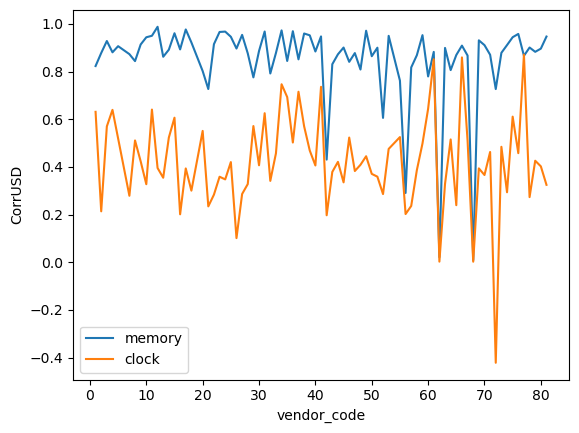

In [49]:
df_sales_merged.groupby("vendor_code")[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"]).plot()
plt.ylabel("CorrUSD")
plt.show()

However, when grouping by vendor_code the correlation between characteristics and price is very strong except for a few vendors.  
In general the clock is not as strongly correlated, positively or negatively, to the price of the ram as it can be seen from the distribution of the correlations.

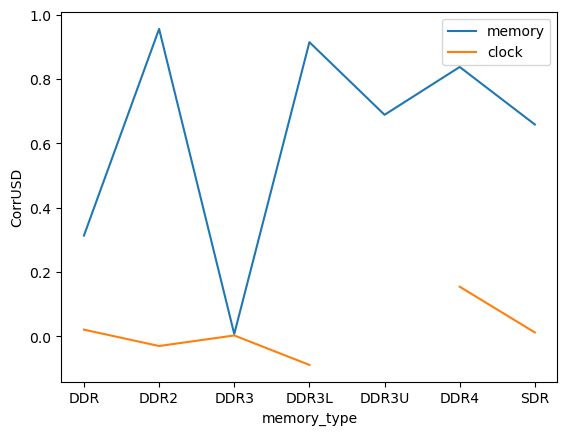

In [50]:
df_sales_merged.groupby(["memory_type"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"]).plot()
plt.ylabel("CorrUSD")
plt.show()

The variance of the clock in DDR3U is 0 (1600 MHz), therefore the correlation is not defined.

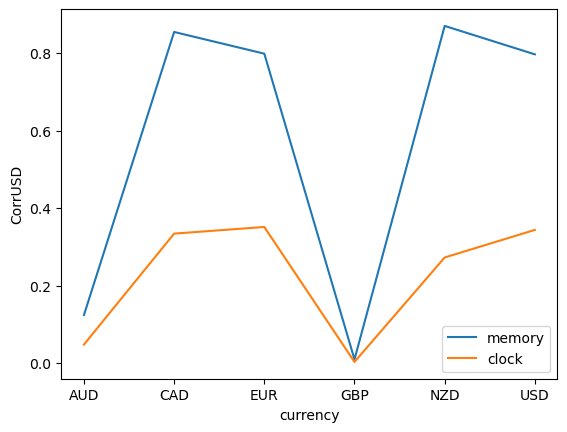

In [51]:
df_sales_merged.groupby(["currency"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"]).plot()
plt.ylabel("CorrUSD")
plt.show()

Whatever the problem is it seems connected with specific countries/currencies.  
Together with the findings in the previous sections, this adds further suspicions towards the data points in these categories.

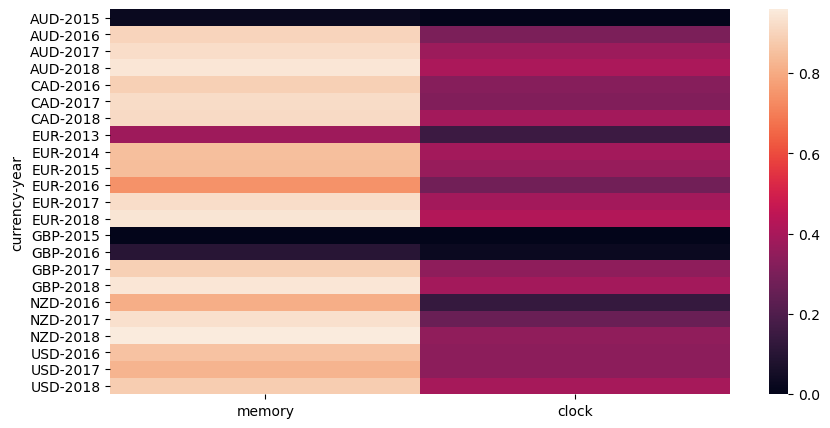

In [170]:
plt.figure(figsize=(10,5))
sn.heatmap(df_sales_merged.groupby(["currency", "year"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"]))
plt.show()

The correlation (memory-wise) for GBP and AUD is low for the first years of sales (2015/2016), the other countries have an high correlation average (note the smallish correlation for EUR/2013).  
Let's take a deeper dive.

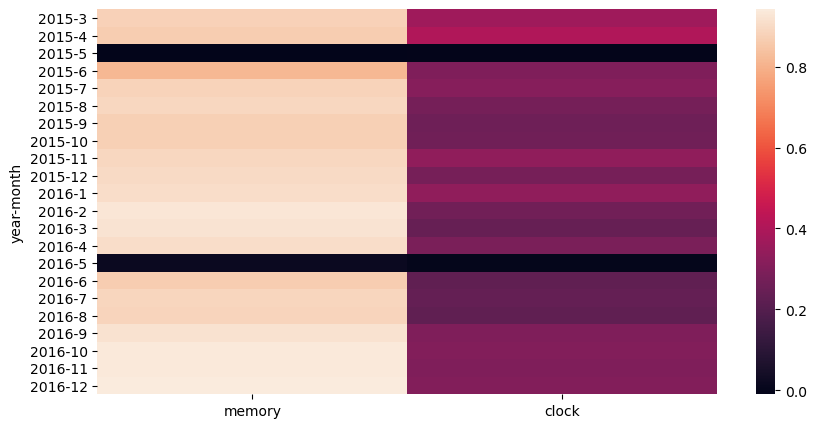

In [175]:
plt.figure(figsize=(10,5))
sn.heatmap(df_sales_merged.loc[(df_sales_merged["currency"] == "GBP") & (df_sales_merged["year"].isin([2015,2016]))]\
    .groupby(["year", "month"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"]))
plt.show()

During the months of May 2015 and 2016 the correlation takes a nosedive, otherwise it stays fairly high.

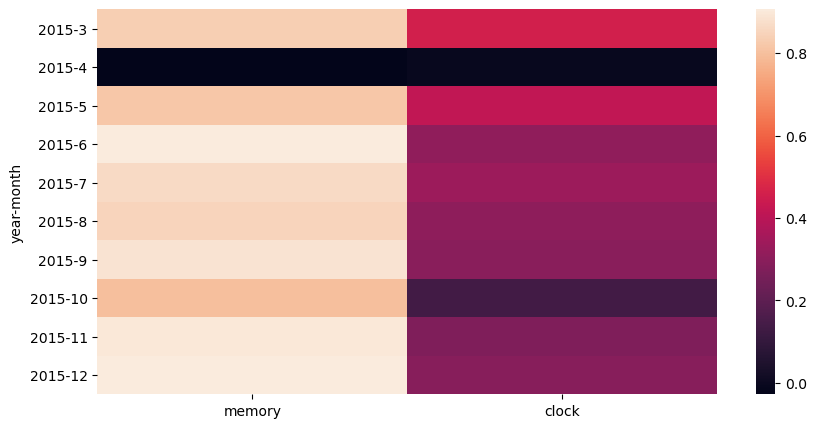

In [176]:
plt.figure(figsize=(10,5))
sn.heatmap(df_sales_merged.loc[(df_sales_merged["currency"] == "AUD") & (df_sales_merged["year"] == 2015)]\
    .groupby(["year", "month"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"]))
plt.show()

Similar situation for the AUD, here it happens on the month of April 2015.

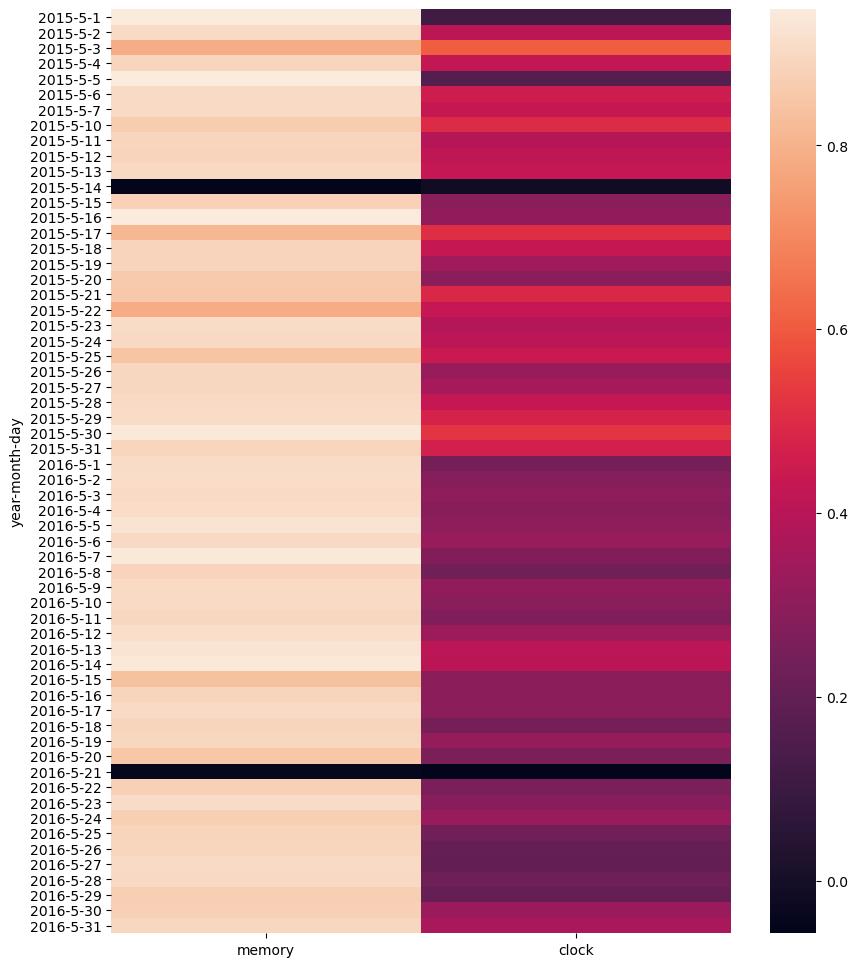

In [182]:
plt.figure(figsize=(10, 12))
sn.heatmap(df_sales_merged.loc[(df_sales_merged["currency"] == "GBP") & (df_sales_merged["year"].isin([2015,2016])) & \
                               (df_sales_merged["month"] == 5)].groupby(["year", "month", "day"])\
           [["memory", "clock"]].corrwith(df_sales_merged["sales_uds"]))
plt.show()

Really weird behaviour appears only on the 14/05/2015 and 21/05/2016.

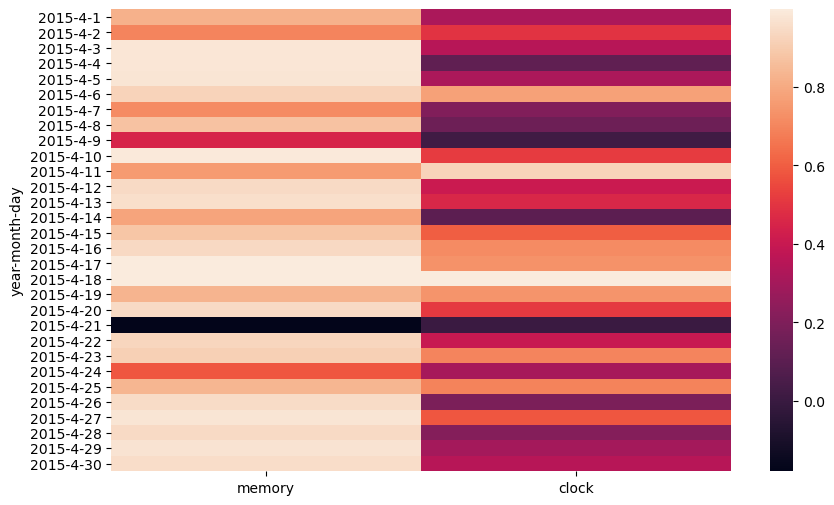

In [185]:
plt.figure(figsize=(10, 6))
sn.heatmap(df_sales_merged.loc[(df_sales_merged["currency"] == "AUD") & (df_sales_merged["year"] == 2015) & \
                               (df_sales_merged["month"] == 4)].groupby(["year", "month", "day"])[["memory", "clock"]]\
           .corrwith(df_sales_merged["sales_uds"]))
plt.show()

Here the correlation falls drastically on the 21/04/2015.

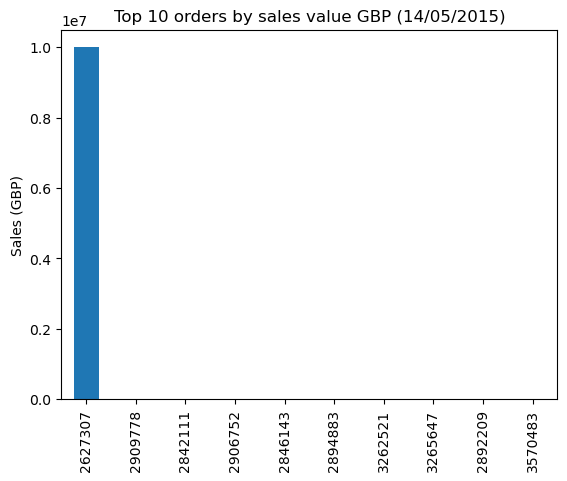

In [206]:
plt.title("Top 10 orders by sales value in GBP (14/05/2015)")
df_sales_merged.loc[(df_sales_merged["currency"] == "GBP") & (df_sales_merged["year"] == 2015) & \
                    (df_sales_merged["month"] == 5) & (df_sales_merged["day"] == 14), "sales_currency"]\
                    .sort_values(ascending=False).head(10).plot(kind="bar")
plt.ylabel("Sales (GBP)")
plt.show()

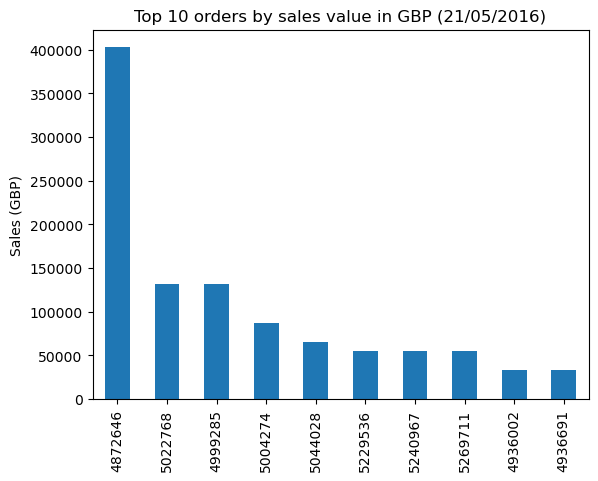

In [207]:
plt.title("Top 10 orders by sales value in GBP (21/05/2016)")
df_sales_merged.loc[(df_sales_merged["currency"] == "GBP") & (df_sales_merged["year"] == 2016) & \
                    (df_sales_merged["month"] == 5) & (df_sales_merged["day"] == 21), "sales_currency"]\
                    .sort_values(ascending=False).head(10).plot(kind="bar")
plt.ylabel("Sales (GBP)")
plt.show()

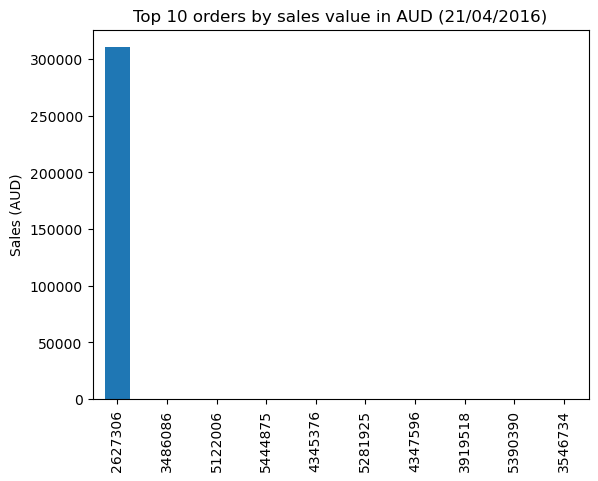

In [208]:
plt.title("Top 10 orders by sales value in AUD (21/04/2016)")
df_sales_merged.loc[(df_sales_merged["currency"] == "AUD") & (df_sales_merged["year"] == 2015) & \
                    (df_sales_merged["month"] == 4) & (df_sales_merged["day"] == 21), "sales_currency"]\
                    .sort_values(ascending=False).head(10).plot(kind="bar")
plt.ylabel("Sales (AUD)")
plt.show()

All of these dates present what we can only describe as outliers/input errors given the exorbitant price for what are otherwise subpar specs for the sold RAM.  
These values will be handled in the outlier section of the notebook.  
Mistery solved.

### Consistency of prices throughout vendors  
We want to understand if the prices for the same ram_code module are stable across vendors/countries.

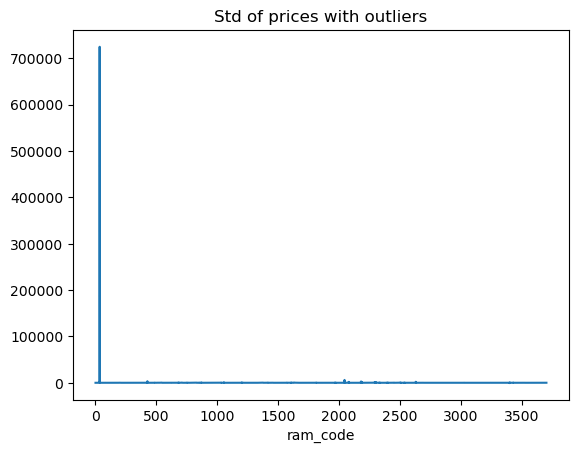

In [60]:
plt.title("Std of prices with outliers")
df_sales_merged.groupby("ram_code")["sales_uds"].std().plot()
plt.show()

In [61]:
df_sales_merged.groupby("ram_code")["sales_uds"].var().describe()

count    3.113000e+03
mean     1.687968e+08
std      9.416077e+09
min      0.000000e+00
25%      6.881601e+01
50%      4.455895e+02
75%      2.640885e+03
max      5.253631e+11
Name: sales_uds, dtype: float64

The sales value ranges a lot, there are clearly some outliers, as we have also pointed out above.  
We will come back to this topic after dealing with the outliers.  

### Data semantics

In [62]:
df_sales.head()

Id  ram_code  time_code  geo_code  vendor_code  sales_uds  \
2602347  3719       1.0   20130322        25           32  13.749032   
2602348  3719       1.0   20130323        18           32  13.828708   
2602349  3719       1.0   20130326        28           32  13.694297   
2602350  3719       1.0   20130327        25           32  13.690530   
2602351  3719       1.0   20130328        27           32  13.605216   

         sales_currency  
2602347           10.65  
2602348           10.65  
2602349           10.65  
2602350           10.65  
2602351           10.65

* Id: Id and ram_code are virtually the same, they identify the type of ram sold by the vendor. For each Id there is only a type of ram sold. Different vendors can have orders with the same Id/ram_code.
* ram_code: see above
* time_code: identifies the date in which the ram was sold by the vendor
* geo_code: identifies the location in which the ram was sold/sent
* vendor_code: identifies the vendor that carried out the transaction
* sales_uds: identifies the value of the sale in us dollars
* sales_currency: identifies the value of the sale in the local currency of the country in which it was sold

## Time

In [63]:
df_time

time_code  year  month  day  week
0      20130322  2013      3   22    12
1      20130323  2013      3   23    12
2      20130326  2013      3   26    13
3      20130327  2013      3   27    13
4      20130328  2013      3   28    13
...         ...   ...    ...  ...   ...
1841   20180408  2018      4    8    14
1842   20180409  2018      4    9    15
1843   20180410  2018      4   10    15
1844   20180411  2018      4   11    15
1845   20180412  2018      4   12    15

[1840 rows x 5 columns]

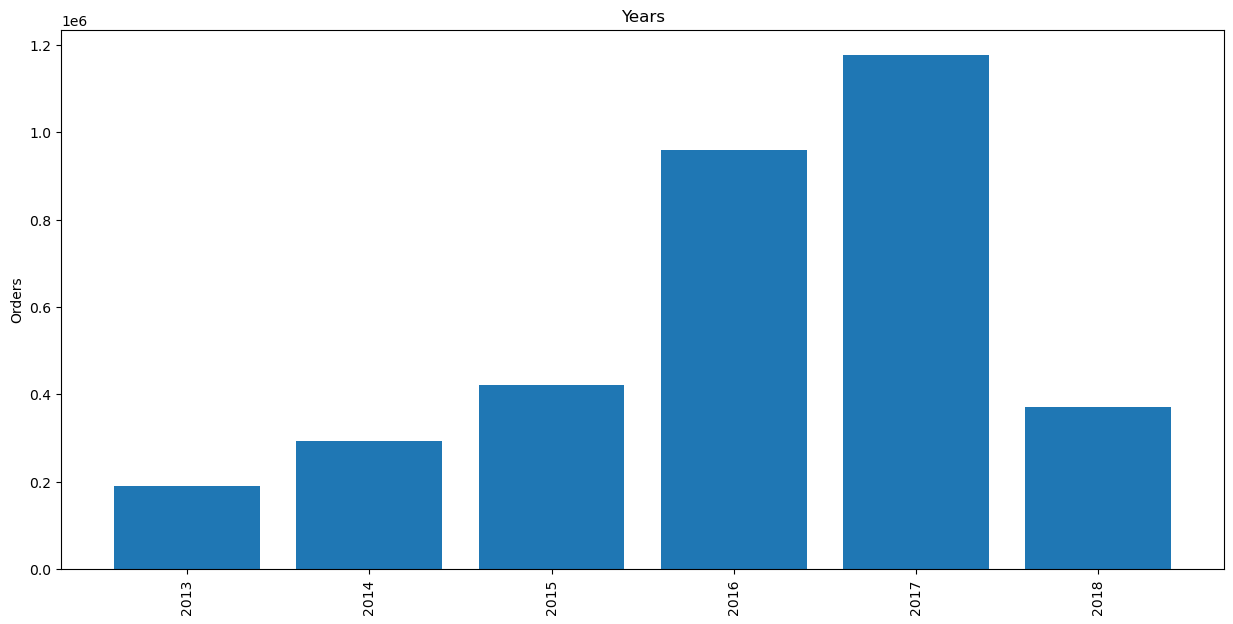

In [64]:
plt.figure(figsize=(15, 7))
plt.title("Years")
labels, counts = np.unique(df_sales_merged["year"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.ylabel("Orders")
plt.xticks(rotation = 90)
plt.show()

Even though the sales seem to drop a lot in 2018, this is due to the dataset stopping at May 2018.

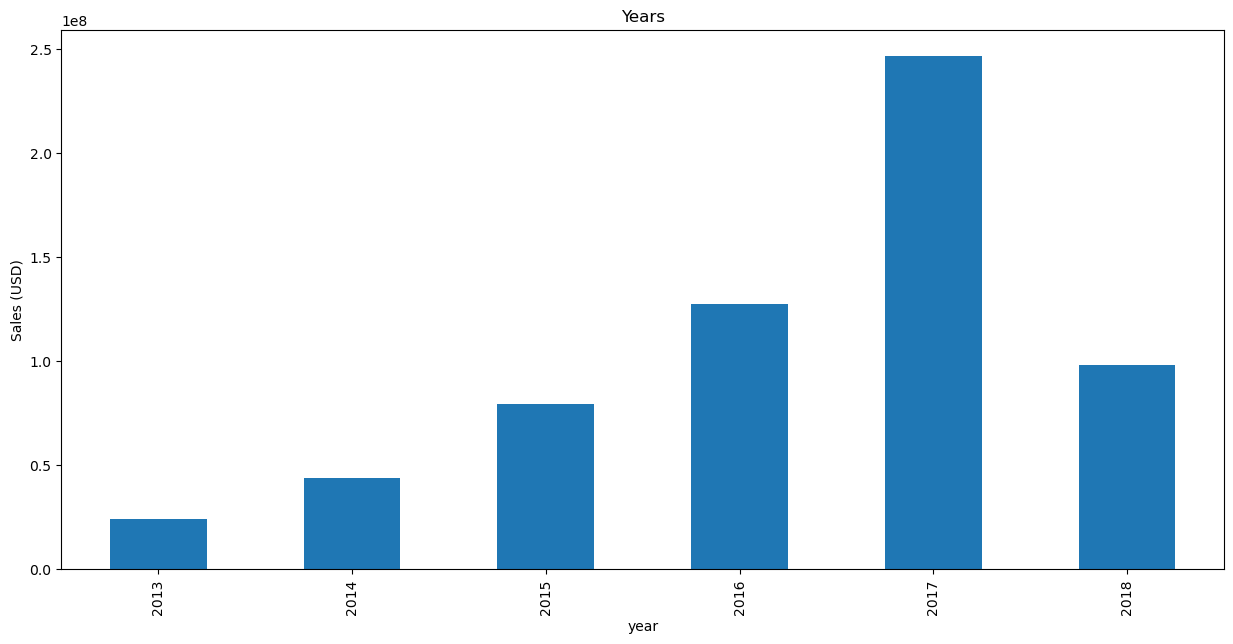

In [65]:
plt.figure(figsize=(15, 7))
plt.title("Years")
df_sales_merged.groupby("year")["sales_uds"].sum().plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.xticks(rotation = 90)
plt.show()

Compared to 2016, in 2017 the average sale value of the items increased.

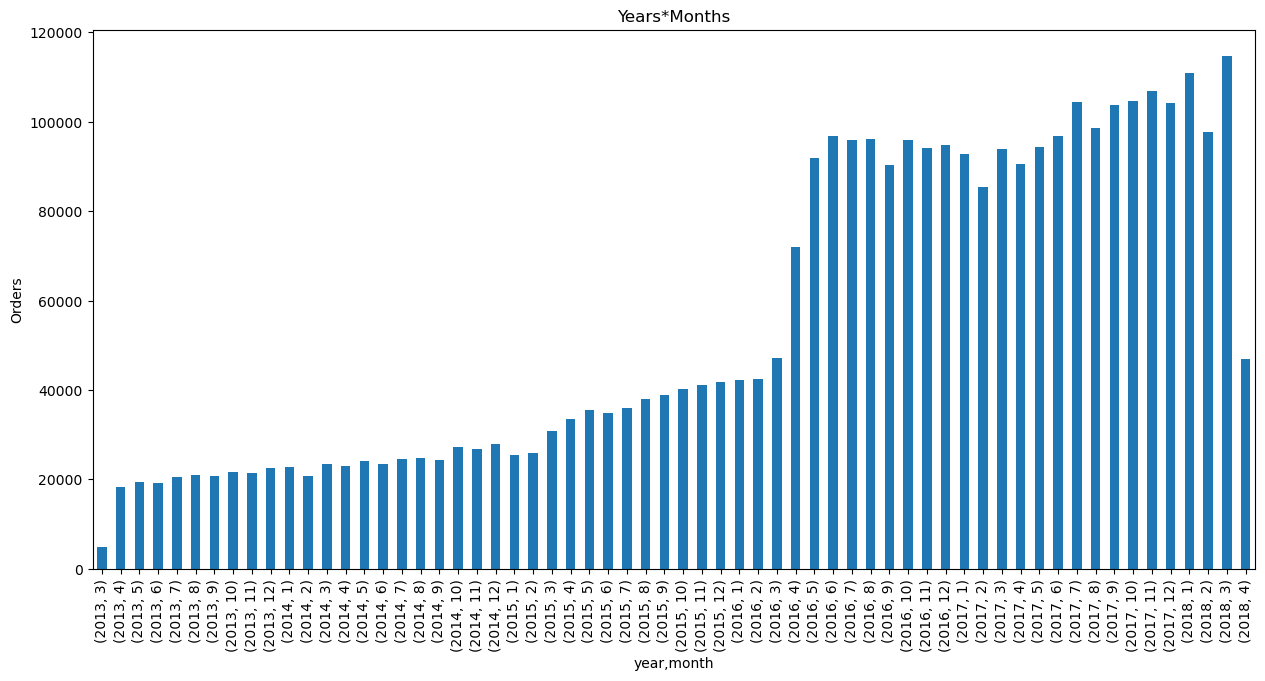

In [66]:
plt.figure(figsize=(15, 7))
plt.title("Years*Months")
df_sales_merged.groupby(["year", "month"]).size().plot(kind="bar")
plt.ylabel("Orders")
plt.xticks(rotation = 90)
plt.show()

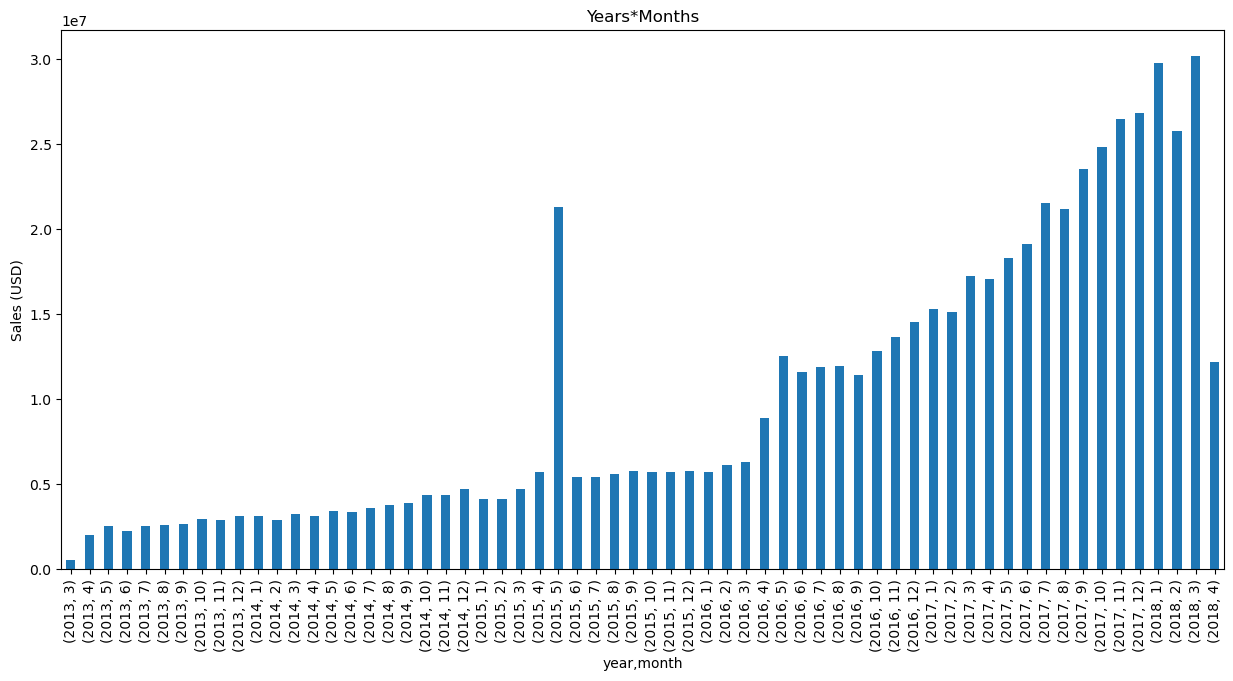

In [67]:
plt.figure(figsize=(15, 7))
plt.title("Years*Months")
df_sales_merged.groupby(["year", "month"])["sales_uds"].sum().plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.xticks(rotation = 90)
plt.show()

Just by looking at the first months of 2018 we can see that the sales were on track to reach a record level compared to the previous years.  
We will deal with the outlier in 05/2015 later on.

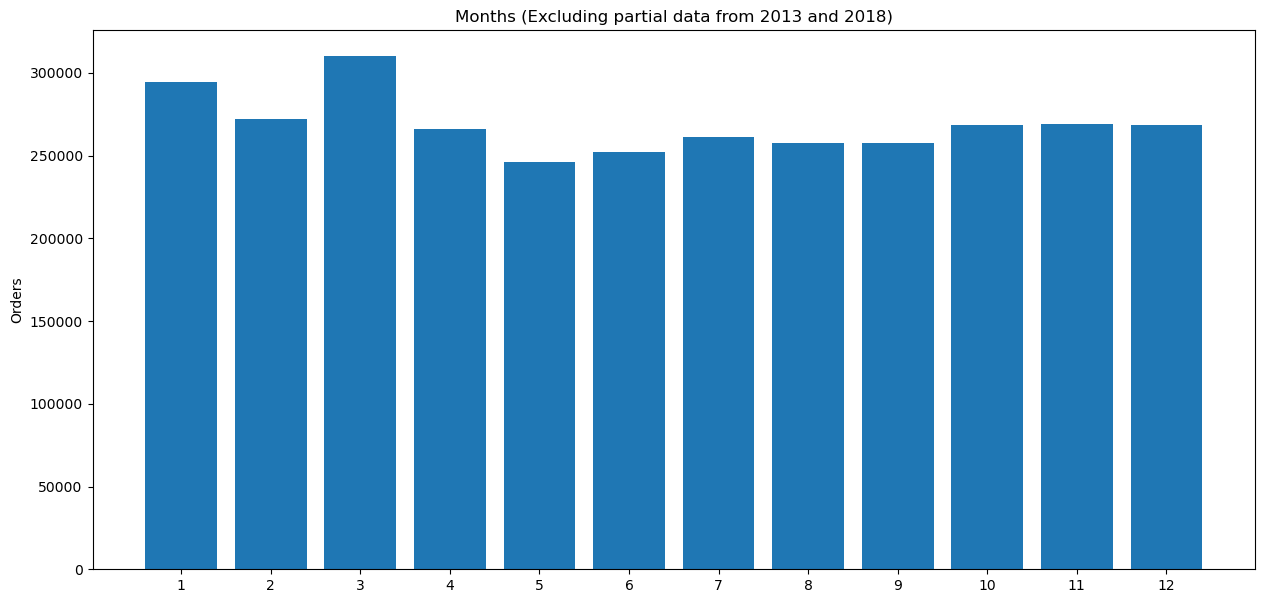

In [68]:
plt.figure(figsize=(15, 7))
plt.title("Months (Excluding partial data from 2013 and 2018)")
full_year_df = df_sales_merged.loc[(df_sales_merged["year"] > 2013) & (df_sales_merged["year"] <= 2018), "month"]
labels, counts = np.unique(full_year_df, return_counts=True)
plt.bar(labels, counts, align='center')
plt.ylabel("Orders")
plt.xticks(np.arange(1,13))
plt.show()

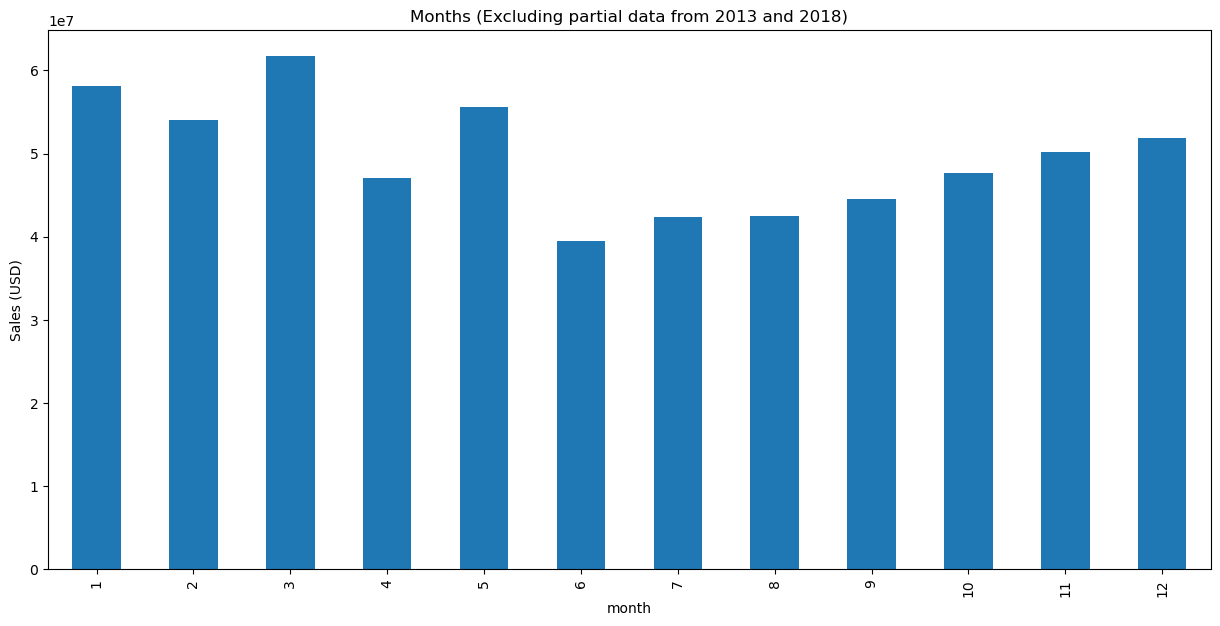

In [69]:
plt.figure(figsize=(15, 7))
plt.title("Months (Excluding partial data from 2013 and 2018)")
full_year_df = df_sales_merged.loc[(df_sales_merged["year"] > 2013) & (df_sales_merged["year"] <= 2018)].groupby("month")["sales_uds"].sum()
full_year_df.plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.show()

We were expecting for an increase in sale/orders during the festivities, this doesn't seem to be the case.

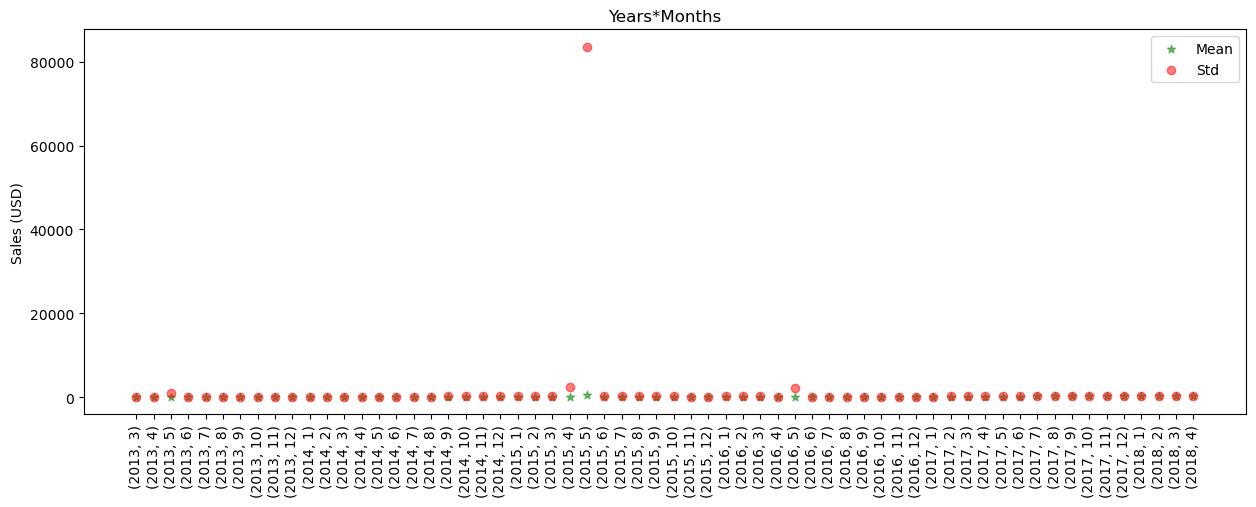

In [70]:
plt.figure(figsize=(15, 5))
plt.title("Years*Months")
feature_str = ["year", "month"]

mean_df = df_sales_merged.groupby(feature_str)["sales_uds"].mean().rename("mean")
mean_df.index = mean_df.index.to_flat_index().rename("index")
mean_df = mean_df.reset_index("index")
mean_df.loc[:, "index"] = mean_df["index"].apply(lambda x: str(x)).rename("index")

std_df = df_sales_merged.groupby(feature_str)["sales_uds"].std().rename("std")
std_df.index = std_df.index.to_flat_index().rename("index")
std_df = std_df.reset_index("index")
std_df.loc[:, "index"] = std_df["index"].apply(lambda x: str(x)).rename("index")

plt.scatter(mean_df["index"], mean_df["mean"], c="g", marker="*", label="Mean", alpha=0.50)
plt.scatter(std_df["index"], std_df["std"], c="r", marker="o", label="Std", alpha=0.50)
plt.ylabel("Sales (USD)")
plt.xlabel("")
plt.xticks(rotation=90)
plt.legend()
plt.show()

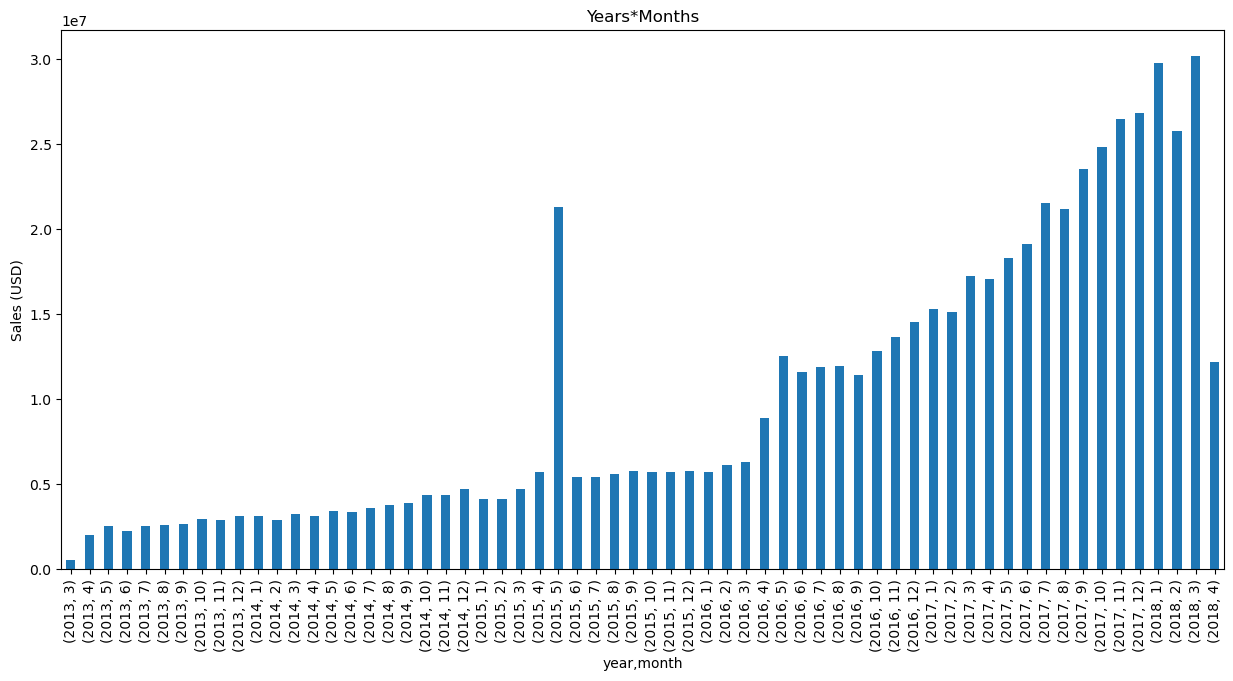

In [71]:
plt.figure(figsize=(15, 7))
plt.title("Years*Months")
df_sales_merged.groupby(["year", "month"])["sales_uds"].sum().plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.xticks(rotation = 90)
plt.show()

Confirms that there is something going on during the month of May 2015.

### Value checks

In [72]:
df_time.describe()

time_code         year        month          day         week
count  1.840000e+03  1840.000000  1840.000000  1840.000000  1840.000000
mean   2.015324e+07  2015.257609     6.497283    15.734239    26.917935
std    1.488919e+04     1.496033     3.441738     8.813179    15.044119
min    2.013032e+07  2013.000000     1.000000     1.000000     1.000000
25%    2.014063e+07  2014.000000     4.000000     8.000000    14.000000
50%    2.015101e+07  2015.000000     6.000000    16.000000    27.000000
75%    2.017011e+07  2017.000000     9.250000    23.000000    40.000000
max    2.018041e+07  2018.000000    12.000000    31.000000    53.000000

No suspicious values here.

In [73]:
print(f"Duplicated time_code values: {df_time['time_code'].duplicated().any()}")
print(f"Presence of NaN in the dataset: {df_time.isna().any().any()}")

Duplicated time_code values: False
Presence of NaN in the dataset: False


## Vendor

In [74]:
df_vendor.head()

vendor_code                  name
0            1  1stWave Technologies
1            2               Adorama
2            3             Alternate
3            4      Alternate Italia
4            5                  Alza

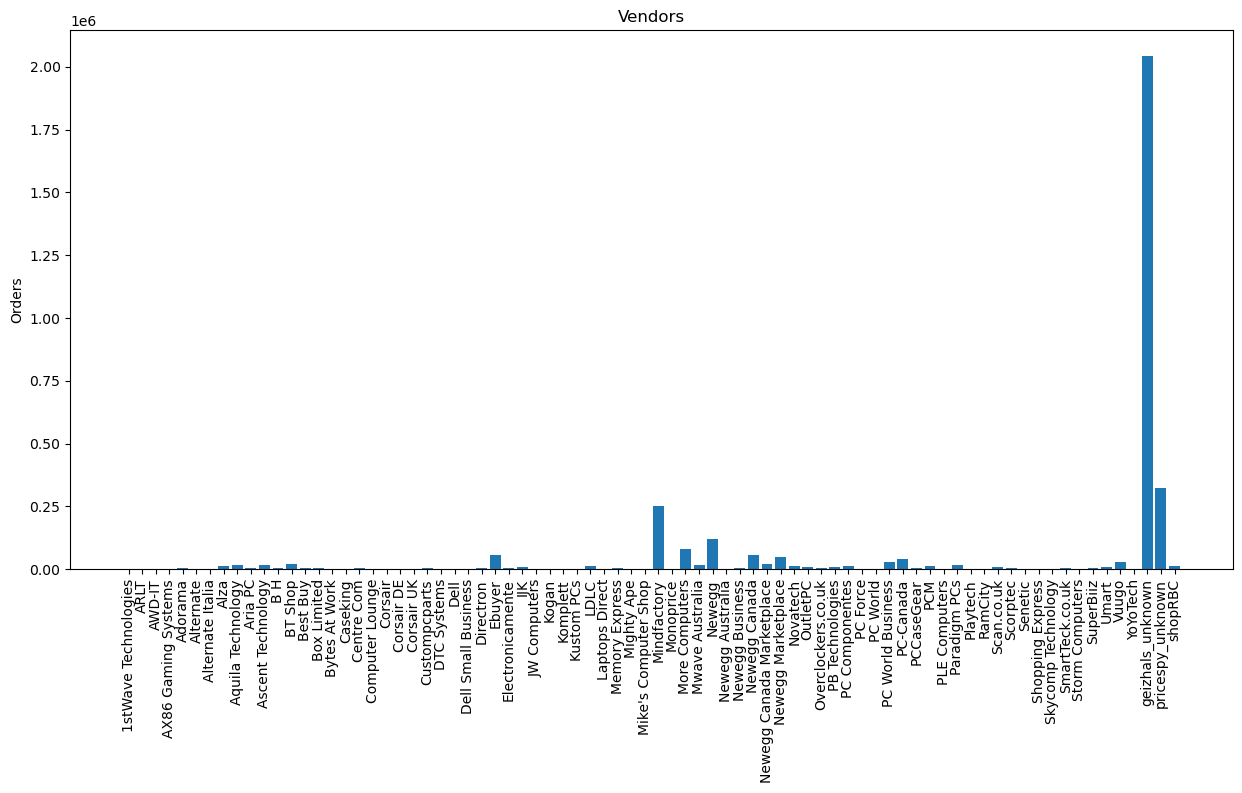

In [75]:
plt.figure(figsize=(15, 7))
plt.title("Vendors")
labels, counts = np.unique(df_sales_merged["name_vendor"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.xticks(rotation = 90)
plt.ylabel("Orders")
plt.show()

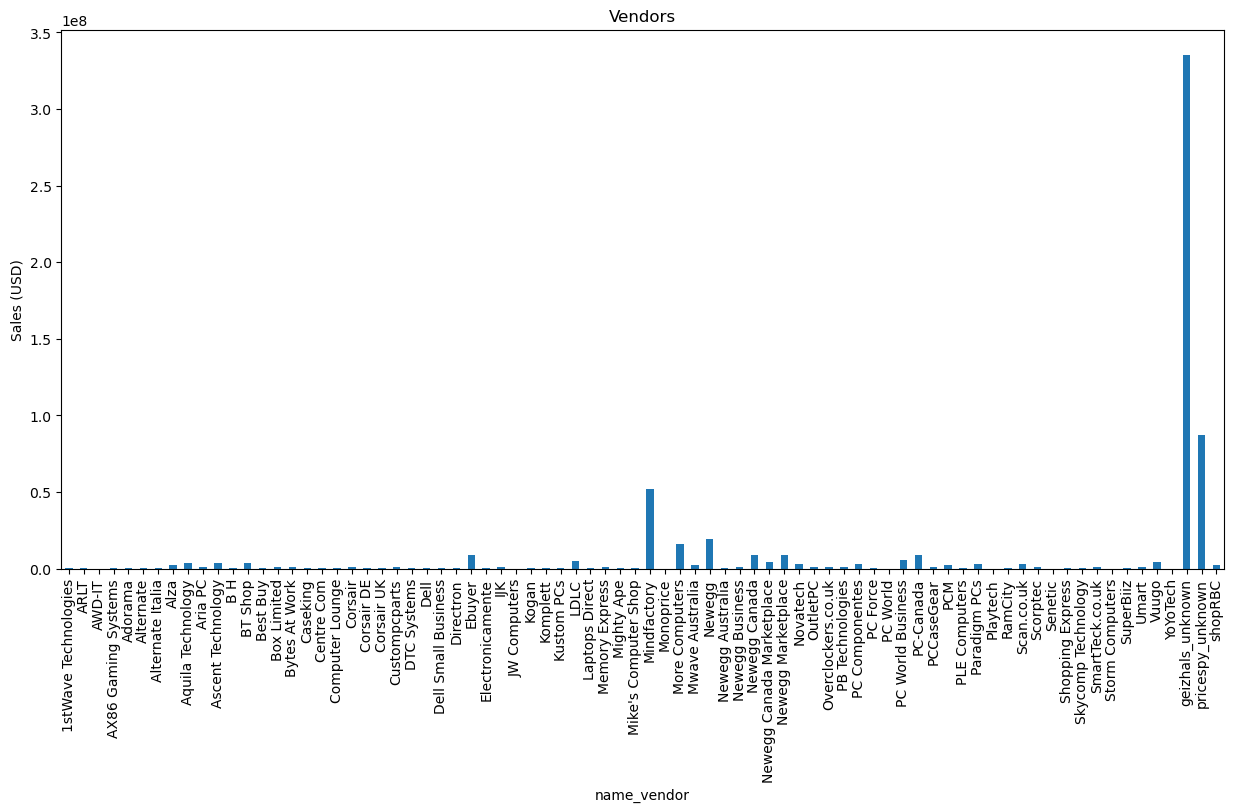

In [76]:
plt.figure(figsize=(15, 7))
plt.title("Vendors")
df_sales_merged.groupby("name_vendor")["sales_uds"].sum().plot(kind="bar")
plt.xticks(rotation = 90)
plt.ylabel("Sales (USD)")
plt.show()

Note that the two biggest vendors (geizhals_unknown and pricespy_unknown) are price comparison engines, while Mindfactory is a real one.  
We assume that the "unknown" part is used to avoid mentioning smallers vendors featured on the websites.

### Value checks

In [77]:
df_vendor.describe()

vendor_code
count    78.000000
mean     41.564103
std      23.459603
min       1.000000
25%      22.250000
50%      41.500000
75%      61.750000
max      81.000000

In [78]:
print(f"Number of vendors: {len(df_vendor['name'].unique())}")

print(df_vendor["name"].isna().any())
print("" in df_vendor["name"].unique())

Number of vendors: 78
False
False


In [79]:
df_vendor.groupby(["vendor_code" ,"name"]).size().transform(lambda x: True if x>1 else False).any()

False

No duplicates or missing values in sight.

# Task 1.2: Data preparation

## Auxiliary functions

In [80]:
# Note: run %matplotlib notebook to enable interactivity
def plot_3d_scatter(data_points_list, labels_list=None):
    
    if(labels_list):
        if(len(data_points_list) != len(labels_list)):
            raise RuntimeError
        
    list_size = len(data_points_list)
    fig = plt.figure(figsize=(15,10))
    
    for i in range(list_size):
        
        ax = fig.add_subplot((list_size+1)//2, 2, i+1, projection='3d') #row, column, index
        X = data_points_list[i].copy()
        
        if(labels_list):
            
            if(len(data_points_list[i]) != len(labels_list[i])):
                raise RuntimeError

            X["label"] = labels_list[i]

            for l in np.unique(labels_list[i]):
                ax.scatter(X.loc[X.label == l, 0], X.loc[X.label == l, 1], X.loc[X.label == l, 2],
                           cmap=plt.get_cmap("Pastel1"),
                           s=20, edgecolor='k')
        else:
            ax.scatter(X[0], X[1], X[2], s=20, edgecolor='k')

## Outliers

All the datasets except Sales contain the description of a particular code (ie ram_code), we are therefore gonna assume that there is no point in looking for outliers there since they are just identifiers of different "objects".  
We will just focus on the Sales dataset and in particular on sales_uds and sales_currency, given that from the analysis above we already know of the presence of outliers.  

Furthermore, in order to more easily handle the sales_currency feature, we assume that the exchange rate between the USD and the other currencies is fairly similar, given also that the currencies used have all been stable through the years and their conversion rates are all within an order of magnitude from each other.

In [81]:
df_sales.head()

Id  ram_code  time_code  geo_code  vendor_code  sales_uds  \
2602347  3719       1.0   20130322        25           32  13.749032   
2602348  3719       1.0   20130323        18           32  13.828708   
2602349  3719       1.0   20130326        28           32  13.694297   
2602350  3719       1.0   20130327        25           32  13.690530   
2602351  3719       1.0   20130328        27           32  13.605216   

         sales_currency  
2602347           10.65  
2602348           10.65  
2602349           10.65  
2602350           10.65  
2602351           10.65

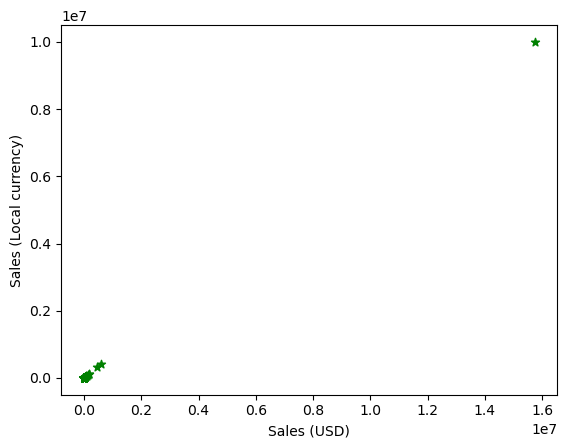

In [82]:
zscore_sample = df_sales[["sales_uds", "sales_currency"]].values
scaler = StandardScaler()
scaler.fit(zscore_sample)
norm_zscore_sample = scaler.transform(zscore_sample)

#Dataframe containing the standardised features
df_sales_zscore = pd.DataFrame(norm_zscore_sample, index=df_sales.index)

#Dataframe with only the features that we are currently analysing
df_sales_cur = df_sales[["sales_uds", "sales_currency"]]

plt.scatter(df_sales_cur["sales_uds"], df_sales_cur["sales_currency"], color='g', marker='*', label='Standard')
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")
plt.show()

The plot for now is too zoomed-out to tells us something about the structure of the dataset.  
We will revisit it for each outlier detection technique used.

### IQR approach  
Here we will use the boxplot whiskers to determine which data points are outliers of the respective features, we will then take the union of the two outliers set obtained in order to have a complete picture.

In [83]:
Q1 = df_sales_cur.quantile(0.25)
Q3 = df_sales_cur.quantile(0.75)
IQR = Q3 - Q1
right_whisker = Q3 + 1.5*IQR
left_whisker = Q1 - 1.5*IQR

In [84]:
print(f"Sale USD 2.5-quantile: {df_sales_cur['sales_uds'].quantile(0.025)}")
print(f"Sale USD 97.5-quantile: {df_sales_cur['sales_uds'].quantile(0.975)}")
print(f"Sale Local 2.5-quantile: {df_sales_cur['sales_currency'].quantile(0.025)}")
print(f"Sale Local 97.5-quantile: {df_sales_cur['sales_currency'].quantile(0.975)}\n")

print(f"Left whisker:\n{left_whisker[['sales_uds', 'sales_currency']]}\n")
print(f"Right whisker:\n{right_whisker[['sales_uds', 'sales_currency']]}")

Sale USD 2.5-quantile: 16.299072780775
Sale USD 97.5-quantile: 811.7509082622499
Sale Local 2.5-quantile: 13.79
Sale Local 97.5-quantile: 707.65624999995

Left whisker:
sales_uds        -187.346128
sales_currency   -169.300000
dtype: float64

Right whisker:
sales_uds         441.798115
sales_currency    394.220000
dtype: float64


Note that the left whisker is negative, while the dataset doesn't contain any negative value.  
This is probably a consequence of a skewed distribution.

In [85]:
df_wo_out_iqr = df_sales_cur.copy()

df_wo_out_iqr = df_wo_out_iqr.loc[(df_wo_out_iqr["sales_uds"] >= left_whisker["sales_uds"]) & (df_wo_out_iqr["sales_uds"] <= right_whisker["sales_uds"])]
df_wo_out_iqr = df_wo_out_iqr.loc[(df_wo_out_iqr["sales_currency"] >= left_whisker["sales_currency"]) & (df_wo_out_iqr["sales_currency"] <= right_whisker["sales_currency"])]

df_size_diff = df_sales_cur.shape[0]-df_wo_out_iqr.shape[0]
print(f'The number of total outliers in the dataset is: {df_size_diff}')
print(f'That is {df_size_diff*100/df_sales.shape[0]:3.2f}% of the total entries.')

The number of total outliers in the dataset is: 309760
That is 9.08% of the total entries.


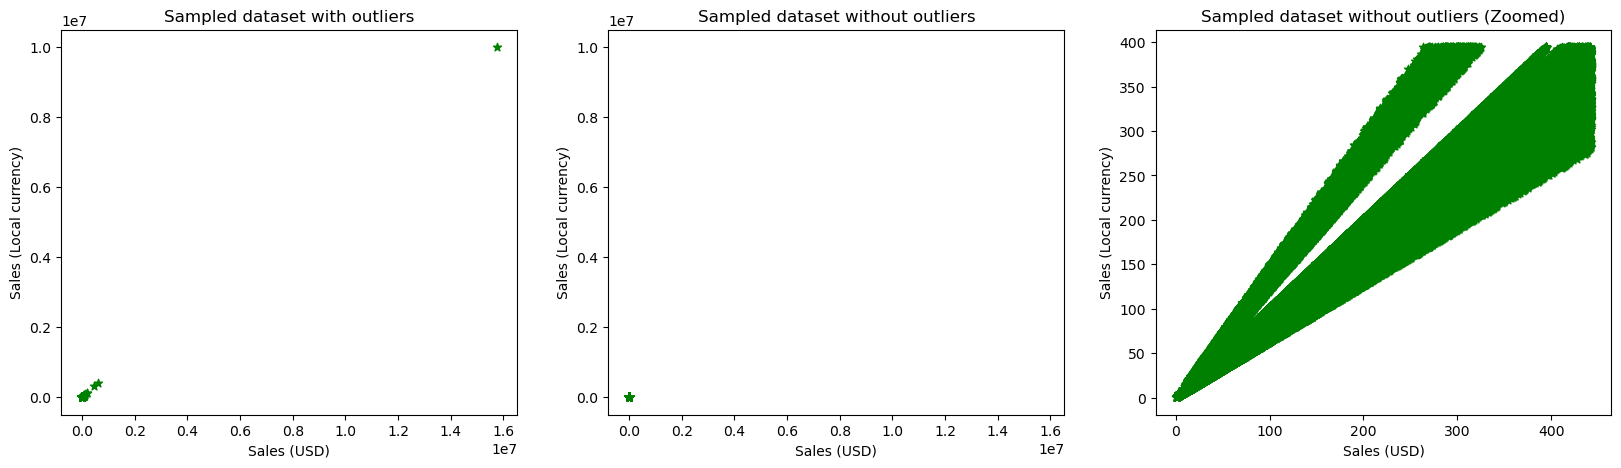

In [86]:
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 3)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Sampled dataset with outliers")
init_axes = \
    plt.scatter(df_sales["sales_uds"], df_sales["sales_currency"], 
                color="g", marker='*', label='Standard').axes
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Sampled dataset without outliers")
plt.scatter(df_wo_out_iqr["sales_uds"], df_wo_out_iqr["sales_currency"], color="g", marker='*', label='Standard')
#Keep the same axis size for all the subplots
plt.xlim(min(init_axes.viewLim.intervalx), max(init_axes.viewLim.intervalx))
plt.ylim(min(init_axes.viewLim.intervaly), max(init_axes.viewLim.intervaly))
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 2))
plt.title("Sampled dataset without outliers (Zoomed)")
plt.scatter(df_wo_out_iqr["sales_uds"], df_wo_out_iqr["sales_currency"], color="g", marker='*', label='Standard')
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.show()

This kind of outlier detection doesn't seem promising since an uncomfortable amount of data points (~9%) is classified as outliers.

#### Using Box-Cox transformation  
In this section we apply the Box-Cox transformation in order to work with a distribution that approximates a normal one and see if we obtain better results.

In [87]:
boxcox_t_uds = stats.boxcox(df_sales_cur["sales_uds"])
boxcox_t_currency = stats.boxcox(df_sales_cur["sales_currency"])

In [88]:
df_boxcox = pd.DataFrame({"sales_uds":boxcox_t_uds[0], "sales_currency":boxcox_t_currency[0]}, index=df_sales_cur.index)

In [89]:
Q1 = df_boxcox.quantile(0.25)
Q3 = df_boxcox.quantile(0.75)
IQR = Q3 - Q1
right_whisker = Q3 + 1.5*IQR
left_whisker = Q1 - 1.5*IQR

In [90]:
df_wo_out_iqrcox = df_boxcox.copy()

df_wo_out_iqrcox = df_wo_out_iqrcox.loc[(df_wo_out_iqrcox["sales_uds"] >= left_whisker["sales_uds"]) & (df_wo_out_iqrcox["sales_uds"] <= right_whisker["sales_uds"])]
df_wo_out_iqrcox = df_wo_out_iqrcox.loc[(df_wo_out_iqrcox["sales_currency"] >= left_whisker["sales_currency"]) & (df_wo_out_iqrcox["sales_currency"] <= right_whisker["sales_currency"])]

df_size_diff = df_sales_cur.shape[0]-df_wo_out_iqrcox.shape[0]
print(f'The number of total outliers in the dataset is: {df_size_diff}')
print(f'That is {df_size_diff*100/df_sales.shape[0]:3.2f}% of the total entries.')

The number of total outliers in the dataset is: 10733
That is 0.31% of the total entries.


These results are really promising, let's check the plot of the original non-outliers values.

In [91]:
df_wo_out_iqrcox = df_sales_cur.loc[df_wo_out_iqrcox.index]

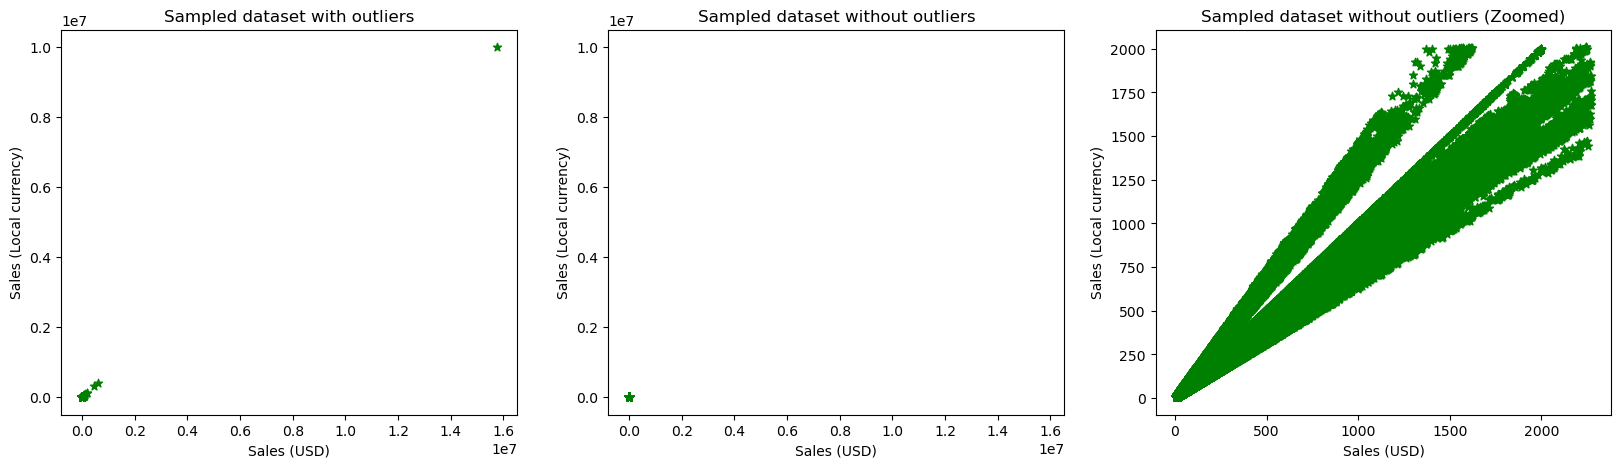

In [92]:
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 3)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Sampled dataset with outliers")
init_axes = \
    plt.scatter(df_sales["sales_uds"], df_sales["sales_currency"], 
                color="g", marker='*', label='Standard').axes
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Sampled dataset without outliers")
plt.scatter(df_wo_out_iqrcox["sales_uds"], df_wo_out_iqrcox["sales_currency"], color="g", marker='*', label='Standard')
#Keep the same axis size for all the subplots
plt.xlim(min(init_axes.viewLim.intervalx), max(init_axes.viewLim.intervalx))
plt.ylim(min(init_axes.viewLim.intervaly), max(init_axes.viewLim.intervaly))
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 2))
plt.title("Sampled dataset without outliers (Zoomed)")
plt.scatter(df_wo_out_iqrcox["sales_uds"], df_wo_out_iqrcox["sales_currency"], color="g", marker='*', label='Standard')
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.show()

In [93]:
df_wo_out_iqrcox.describe()[["sales_uds", "sales_currency"]]

sales_uds  sales_currency
count  3.401598e+06    3.401598e+06
mean   1.730022e+02    1.530069e+02
std    2.181067e+02    1.914863e+02
min    6.744981e+00    5.440000e+00
25%    4.874920e+01    4.222000e+01
50%    9.914633e+01    8.769500e+01
75%    2.055167e+02    1.825660e+02
max    2.269778e+03    2.008755e+03

The results here are visually great, especially considering the fact that we are removing less than 1% of the data and keeping a healthy range of values greater than 500.  
However, compared to the other methods tested below it seems that this approach is a bit overzealous in excluding data points.

### Local Outlier Factor  
TODO: explain

In [94]:
from sklearn.neighbors import LocalOutlierFactor

#The value of 20 is the recommended one when dealing with datasets with a low percentage of outliers
clf = LocalOutlierFactor(n_neighbors=20)
#Note that we are using the zscore transformation of the values in order to find the outliers
pred_array = clf.fit_predict(df_sales_zscore)

outliers_index = []
for i in range(len(pred_array)):
    if pred_array[i] == -1:
        outliers_index.append(i)

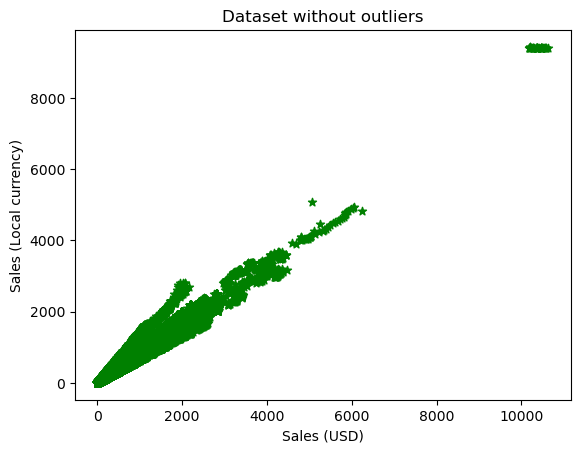

In [95]:
lof_out_df = df_sales.iloc[outliers_index]
df_wo_out_lof = df_sales.loc[~df_sales.index.isin(lof_out_df.index)]

plt.title("Dataset without outliers")
plt.scatter(df_wo_out_lof["sales_uds"], df_wo_out_lof["sales_currency"], color="g", marker='*', label='Standard')
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")
plt.show()

In [96]:
print(f'The number of total outliers in the dataset is: {len(outliers_index)}')
print(f'That is {len(outliers_index)*100/df_sales.shape[0]:3.2f}% of the total entries.')

The number of total outliers in the dataset is: 69631
That is 2.04% of the total entries.


In [97]:
df_wo_out_lof.describe()[["sales_uds", "sales_currency"]]

sales_uds  sales_currency
count  3.342700e+06    3.342700e+06
mean   1.762091e+02    1.554425e+02
std    2.381393e+02    2.078802e+02
min    1.423094e+00    1.010000e+00
25%    4.888402e+01    4.224000e+01
50%    9.953419e+01    8.772000e+01
75%    2.064485e+02    1.829500e+02
max    1.063074e+04    9.429000e+03

The method performs reasonbly well, it doesn't reduce the range of values available as aggresively as IQR and it's not as computationally expensive as BIRCH.  
Interestingly it doesn't consider the values greater than 8000 as outliers unlike the other methods, we choose to keep these datapoints because their distance to the main cluster of points is relatively small compared to the distance to the outliers removed. 

## Clustering approach

There are too many entries to be able to simply run something like DBSCAN on all of them to detect the noise.  
We will therefore use BIRCH to perform a data reduction and then apply DBSCAN in order to approximate the result.

In [98]:
#Remove duplicates to speed up clustering/training
cluster_out_sample = df_sales.drop_duplicates(subset=["sales_uds", "sales_currency"])[["sales_uds", "sales_currency"]]

scaler = StandardScaler()
scaler.fit(cluster_out_sample)
norm_out_sample = scaler.transform(cluster_out_sample)

In [99]:
#This step can take a while to complete!
from sklearn.cluster import Birch
brc = Birch(n_clusters=None, threshold=0.003)
brc.fit(norm_out_sample)

Birch(n_clusters=None, threshold=0.003)

In [100]:
centers_brc_df = pd.DataFrame(brc.subcluster_centers_)
print(f"Number of CF nodes as a result of Birch: {len(brc.subcluster_labels_)}")

Number of CF nodes as a result of Birch: 1174


In [101]:
df_sales_brc = df_sales.copy() #Used to identify all outliers (even duplicates)

df_sales_brc["BIRCH"] = brc.predict(df_sales_zscore)

Let's apply DBSCAN on the BIRCH-produced representative centroids.

In [102]:
dbscan = DBSCAN(min_samples = 100, eps = 0.3)
dbscan.fit(brc.subcluster_centers_)

cluster_series = pd.Series(data=dbscan.labels_, index=centers_brc_df.index)
cluster_outliers = cluster_series.transform(lambda x: 1 if x == -1 else 0)
centers_brc_df["Outlier"] = cluster_outliers

outlier_brc_df = centers_brc_df.loc[centers_brc_df["Outlier"] == 1]
centers_brc_df_wo_out = centers_brc_df.loc[centers_brc_df["Outlier"] == 0]

outlier_count = list(dbscan.labels_).count(-1)
print(f"Number of outliers (CF-nodes): {outlier_count}")
print(f"Percentage of outliers among the data points: {outlier_count/centers_brc_df.shape[0]*100:3.2f}%")
print(f"Silhouette score: {silhouette_score(centers_brc_df, dbscan.labels_)}")

Number of outliers (CF-nodes): 32
Percentage of outliers among the data points: 2.73%
Silhouette score: 0.9462345590685409


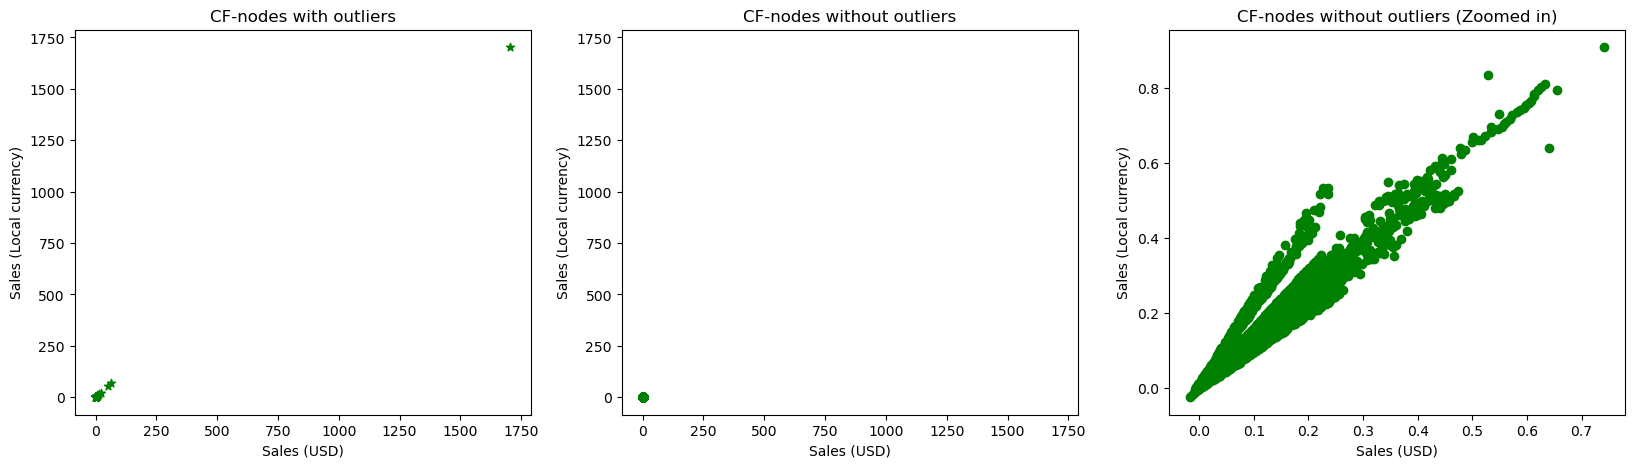

In [103]:
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 3)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("CF-nodes with outliers")
init_axes = \
    plt.scatter(centers_brc_df[0], centers_brc_df[1], 
                color="g", marker='*', label='Standard').axes
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("CF-nodes without outliers")
plt.scatter(centers_brc_df_wo_out[0], centers_brc_df_wo_out[1], color="g")
#Keep the same axis size for all the subplots
plt.xlim(min(init_axes.viewLim.intervalx), max(init_axes.viewLim.intervalx))
plt.ylim(min(init_axes.viewLim.intervaly), max(init_axes.viewLim.intervaly))
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 2))
plt.title("CF-nodes without outliers (Zoomed in)")
init_axes2 = plt.scatter(centers_brc_df_wo_out[0], centers_brc_df_wo_out[1], color="g").axes
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.show()

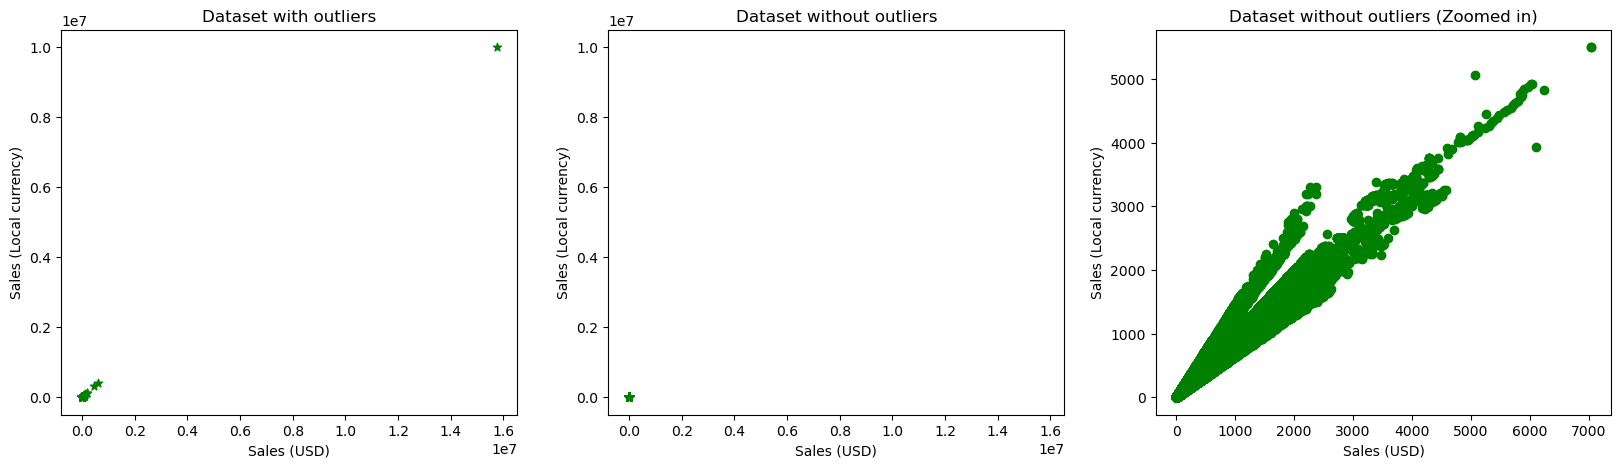

In [104]:
#Retrieve original data points represented inside the non-outlier CF-nodes
cluster_df_wo_out = df_sales_brc.loc[~df_sales_brc["BIRCH"].isin(outlier_brc_df.index)].drop(["BIRCH"], axis=1)
#Outlier datapoints
clustering_outlier_df = df_sales_brc.loc[df_sales_brc["BIRCH"].isin(outlier_brc_df.index)].drop(["BIRCH"], axis=1)

fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 3)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
init_axes = plt.scatter(df_sales_brc["sales_uds"], df_sales_brc["sales_currency"], 
                color="g", marker='*', label='Standard').axes
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers")
plt.scatter(cluster_df_wo_out["sales_uds"], cluster_df_wo_out["sales_currency"], color="g", marker='*')
#Keep the same axis size for all the subplots
plt.xlim(min(init_axes.viewLim.intervalx), max(init_axes.viewLim.intervalx))
plt.ylim(min(init_axes.viewLim.intervaly), max(init_axes.viewLim.intervaly))
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 2))
plt.title("Dataset without outliers (Zoomed in)")
plt.scatter(cluster_df_wo_out["sales_uds"], cluster_df_wo_out["sales_currency"], color="g")
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.show()

In [105]:
df_clustering_wo_out = cluster_df_wo_out

print(f"Number of outliers in the dataset: {clustering_outlier_df.shape[0]}")
print(f"Percentage of outliers among the data points: {clustering_outlier_df.shape[0]/df_sales.shape[0]*100:3.3f}%")

Number of outliers in the dataset: 81
Percentage of outliers among the data points: 0.002%


In [106]:
df_clustering_wo_out.describe()[["sales_uds", "sales_currency"]]

sales_uds  sales_currency
count  3.412250e+06    3.412250e+06
mean   1.759188e+02    1.554715e+02
std    2.370828e+02    2.068878e+02
min    7.050645e-01    5.000000e-01
25%    4.858156e+01    4.201862e+01
50%    9.906399e+01    8.760000e+01
75%    2.058585e+02    1.829000e+02
max    7.036468e+03    5.499000e+03

These were the best results by far, the values are all within reasonable range and the number of data points removed is insignificant, however executing BIRCH with such a low threshold is quite time consuming.  
In a different context this could make this approach unfeasible.

## Conclusion

In [107]:
df_sales_wo_out_iqrcox = df_sales_merged.loc[df_wo_out_iqrcox.index]
df_sales_wo_out_lof = df_sales_merged.loc[df_wo_out_lof.index]
df_sales_wo_out_clustering = df_sales_merged.loc[df_clustering_wo_out.index]

We are interested in taking a look at the behaviour of the vendor features when switching between the techniques explored in this section.  
The final decision will be taken after the following check on the consistency of prices and the analysis of the vendor features.

### Re: Consistency of prices throughout vendors  
Now that we have some datasets without outliers we can try to extract some interesting data concerning the stability of prices for the same product.

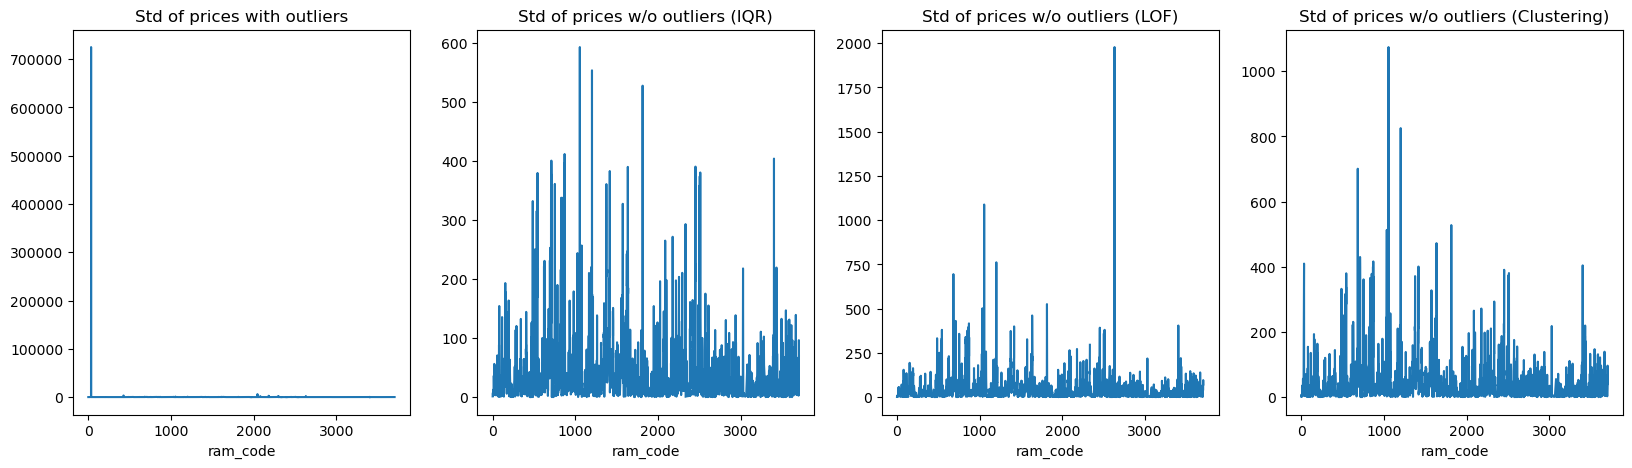

In [108]:
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 4)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Std of prices with outliers")
df_sales_merged.groupby("ram_code")["sales_uds"].std().plot()

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Std of prices w/o outliers (IQR)")
df_sales_wo_out_iqrcox.groupby("ram_code")["sales_uds"].std().plot()

plt.subplot2grid(fig_dims, (0, 2))
plt.title("Std of prices w/o outliers (LOF)")
df_sales_wo_out_lof.groupby("ram_code")["sales_uds"].std().plot()

plt.subplot2grid(fig_dims, (0, 3))
plt.title("Std of prices w/o outliers (Clustering)")
df_sales_wo_out_clustering.groupby("ram_code")["sales_uds"].std().plot()

plt.show()

We already noted that the IQR approach results in the removal of many "extreme" values and this is noticeable in the plot, the distribution of the std is balanced.  
LOF and clustering are very similar, the only difference is the one extreme peak (ram_code 2631) in LOF that distorts the plot.  

Let's check the behaviour of the variances through time, month by month, we will focus on the worst offenders: those with an std >= 1000 and we will take into account the changes to the prices in order to determine if the spikes are a fluke or systematic.

In [109]:
#Auxiliary function
def transform_dataset_ind_col_monthly(source_df):
    
    #Function takes a dataset as input:
        #adds each "year"*"month" combination as a column
        #makes "ram_code" the index
        #returns a new dataset with the cells containing the std of the ram_code in a particular month
    
    dest_df = source_df.copy()
    
    #In order to fit more data in a plot we will abbreviate the year leaving only the last two digits
    
    dest_df["year"] = dest_df["year"].transform(lambda x: x%2000)

    groupby_std_usd = dest_df.groupby(["ram_code", "year", "month"])["sales_uds"].std()

    reset_df = groupby_std_usd.reset_index(level=["year", "month"])
    pivoted_std_df = reset_df.pivot(columns=['year', "month"])
    pivoted_std_df.columns = pivoted_std_df.columns.droplevel(0).to_flat_index() #flat index needed for performance warning
    pivoted_std_df = pivoted_std_df.reset_index(level=["ram_code"])
    
    return pivoted_std_df

def transform_dataset_ind_col_yearly(source_df):
    
    #Function takes a dataset as input:
        #adds each "year" as a column
        #makes "ram_code" the index
        #returns a new dataset with the cells containing the std of the ram_code in a particular year
    
    dest_df = source_df.copy()
    
    groupby_std_usd = dest_df.groupby(["ram_code", "year"])["sales_uds"].std()

    reset_df = groupby_std_usd.reset_index(level=["year"])
    pivoted_std_df = reset_df.pivot(columns=['year'])
    pivoted_std_df.columns = pivoted_std_df.columns.droplevel(0)
    pivoted_std_df = pivoted_std_df.reset_index(level=["ram_code"])
    
    return pivoted_std_df

#### IQR

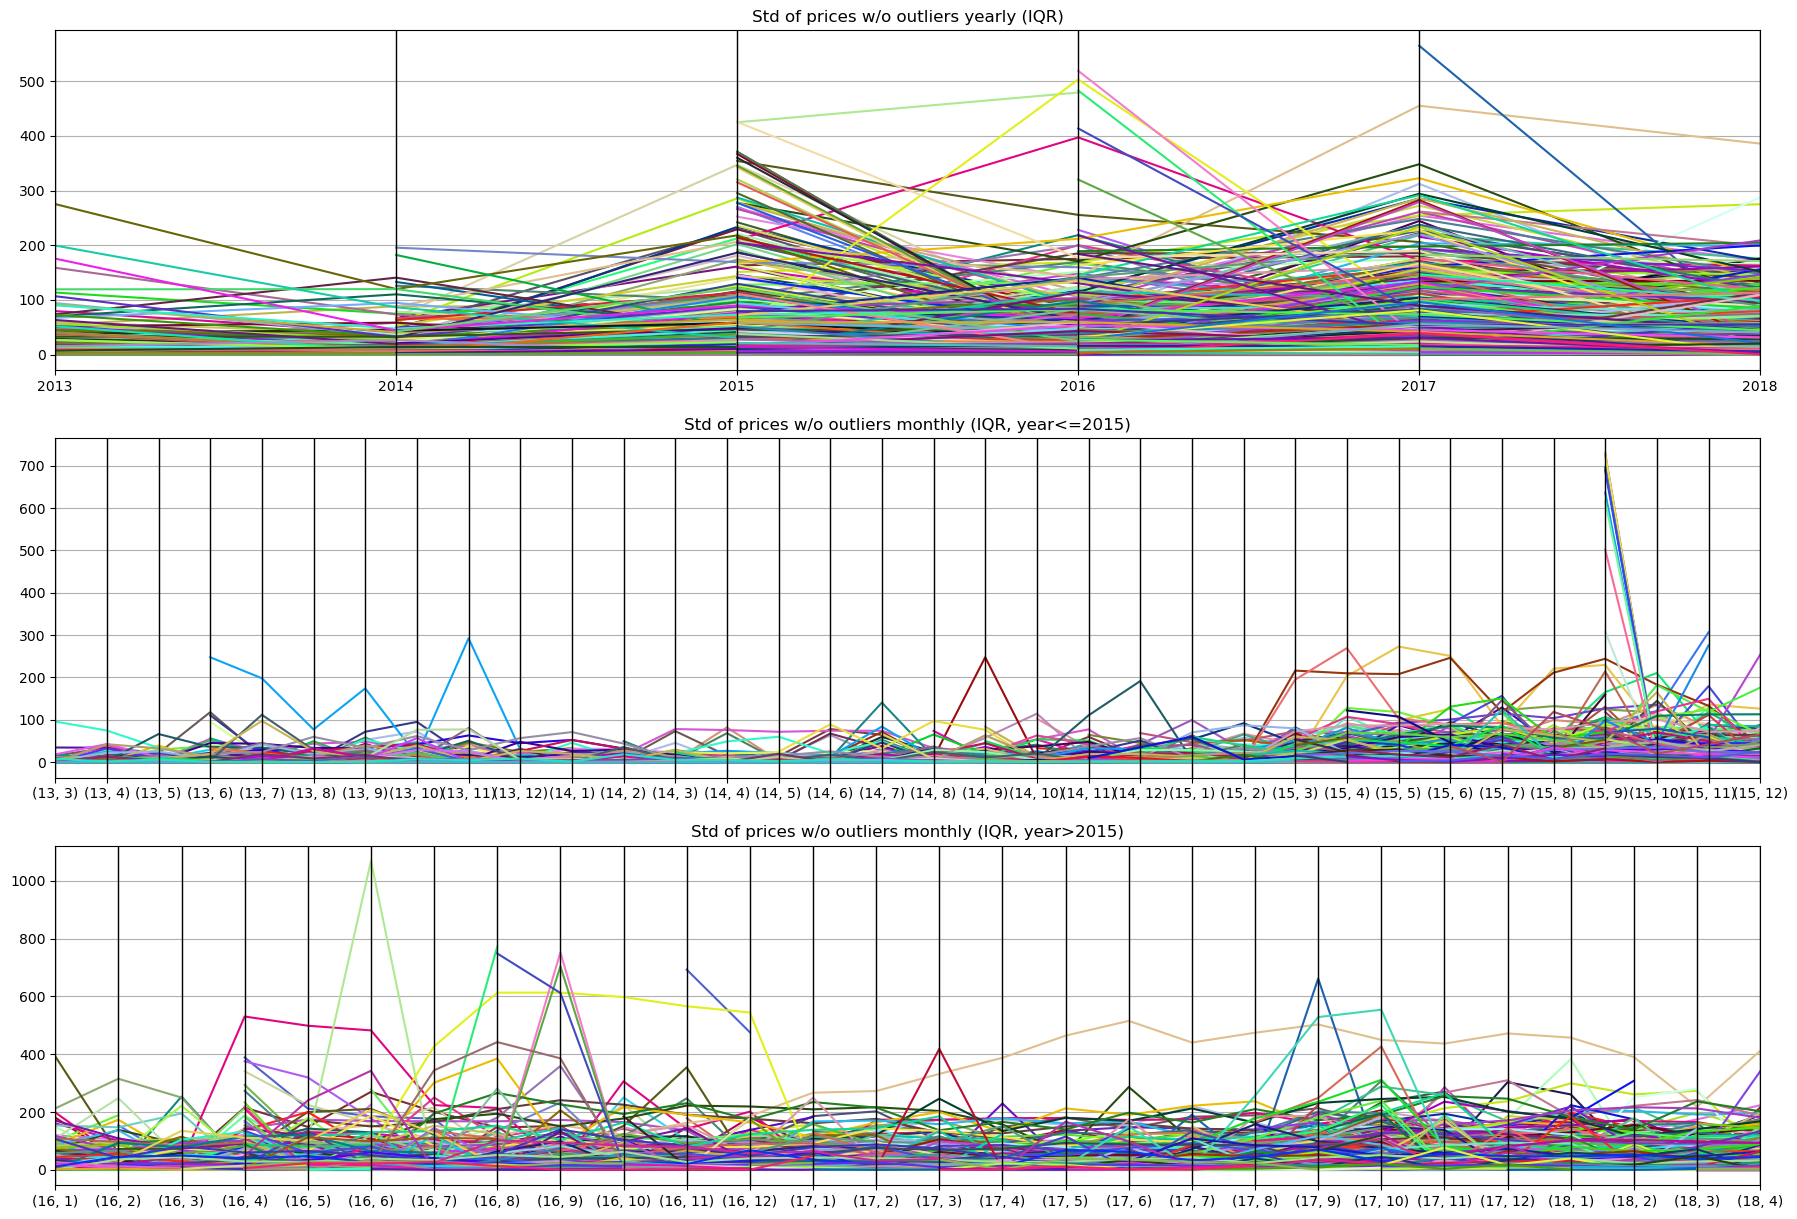

In [110]:
fig = plt.figure(figsize=(22, 15))
fig_dims = (3, 1)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Std of prices w/o outliers yearly (IQR)")
pd.plotting.parallel_coordinates(transform_dataset_ind_col_yearly(df_sales_wo_out_iqrcox), "ram_code")
plt.gca().get_legend().remove() #Remove legend

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Std of prices w/o outliers monthly (IQR, year<=2015)")
pd.plotting.parallel_coordinates(transform_dataset_ind_col_monthly(df_sales_wo_out_iqrcox.loc[df_sales_wo_out_iqrcox["year"]<=2015]), "ram_code")
plt.gca().get_legend().remove() #Remove legend

plt.subplot2grid(fig_dims, (2, 0))
plt.title("Std of prices w/o outliers monthly (IQR, year>2015)")
pd.plotting.parallel_coordinates(transform_dataset_ind_col_monthly(df_sales_wo_out_iqrcox.loc[df_sales_wo_out_iqrcox["year"]>2015]), "ram_code")
plt.gca().get_legend().remove() #Remove legend

plt.show()

**Peaks (15, 9)**

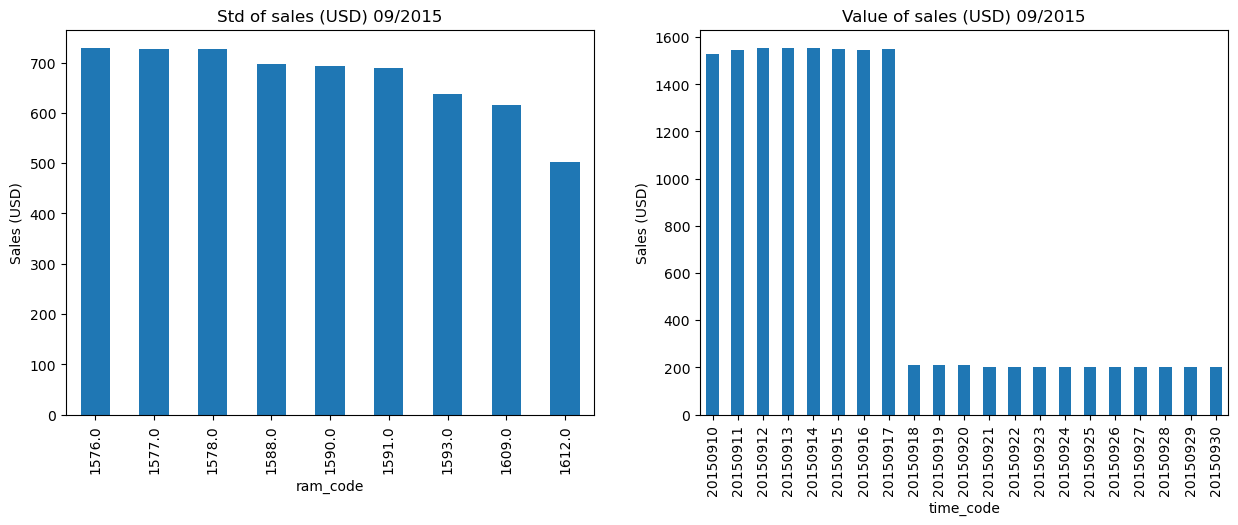

In [327]:
#df containing the entries of the ram_codes that caused the std spike
df_std_peak15_9_iqr = df_sales_wo_out_iqrcox.loc[(df_sales_wo_out_iqrcox["year"] == 2015) & (df_sales_wo_out_iqrcox["month"] == 9)]\
            .groupby("ram_code")["sales_uds"].std().sort_values(ascending=False).head(9)

df_usd_15_9 = df_sales_wo_out_iqrcox.loc[(df_sales_wo_out_iqrcox["year"] == 2015) & (df_sales_wo_out_iqrcox["month"].isin([8,9])) & \
                           (df_sales_wo_out_iqrcox["ram_code"].isin(df_std_peak15_9_iqr.index))].sort_values("time_code")


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

df_tmp_peak15_9_iqr.plot(kind="bar", ax=axes[0], title="Std of sales (USD) 09/2015", ylabel="Sales (USD)")
df_usd_15_9.groupby("time_code")["sales_uds"].mean().plot(kind="bar", ax=axes[1], title="Value of sales (USD) 09/2015", ylabel="Sales (USD)")
plt.show()

Note that none of these products was sold the months prior, it seems that they were introduced in the market at a high cost and after a week the price dropped significantly.

**Peak (16, 6)**

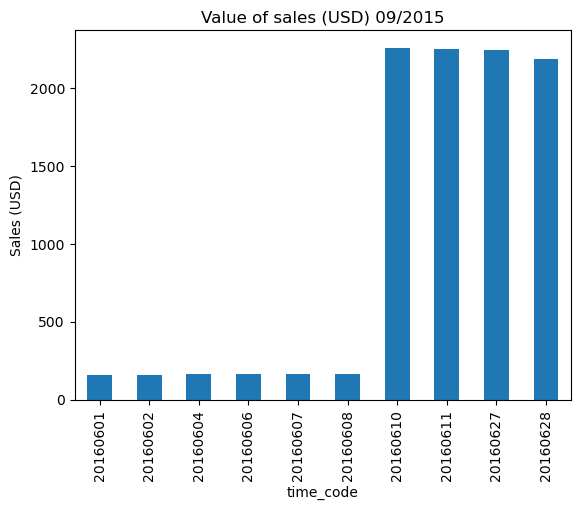

In [233]:
df_usd_16_6 = df_sales_wo_out_iqrcox.loc[(df_sales_wo_out_iqrcox["year"] == 2016) & (df_sales_wo_out_iqrcox["month"] == 6) & \
                           (df_sales_wo_out_iqrcox["ram_code"] == 1055)].sort_values("time_code")

plt.title("Value of sales (USD) 09/2015")
df_usd_16_6.groupby("time_code")["sales_uds"].min().plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.show()

In [283]:
std_tmp_var = df_sales_wo_out_iqrcox.loc[(df_sales_wo_out_iqrcox['year'] == 2016) & (df_sales_wo_out_iqrcox['month'] > 6) & \
(df_sales_wo_out_iqrcox['ram_code'] == 1055), 'sales_uds'].std()

print(f"Std of price throughout the year: {std_tmp_var}")

Std of price throughout the year: 10.265319224201319


Again no explanation, the price skyrocketed during the month 06/2016 and stayed stable for the rest of the year.

#### LOF

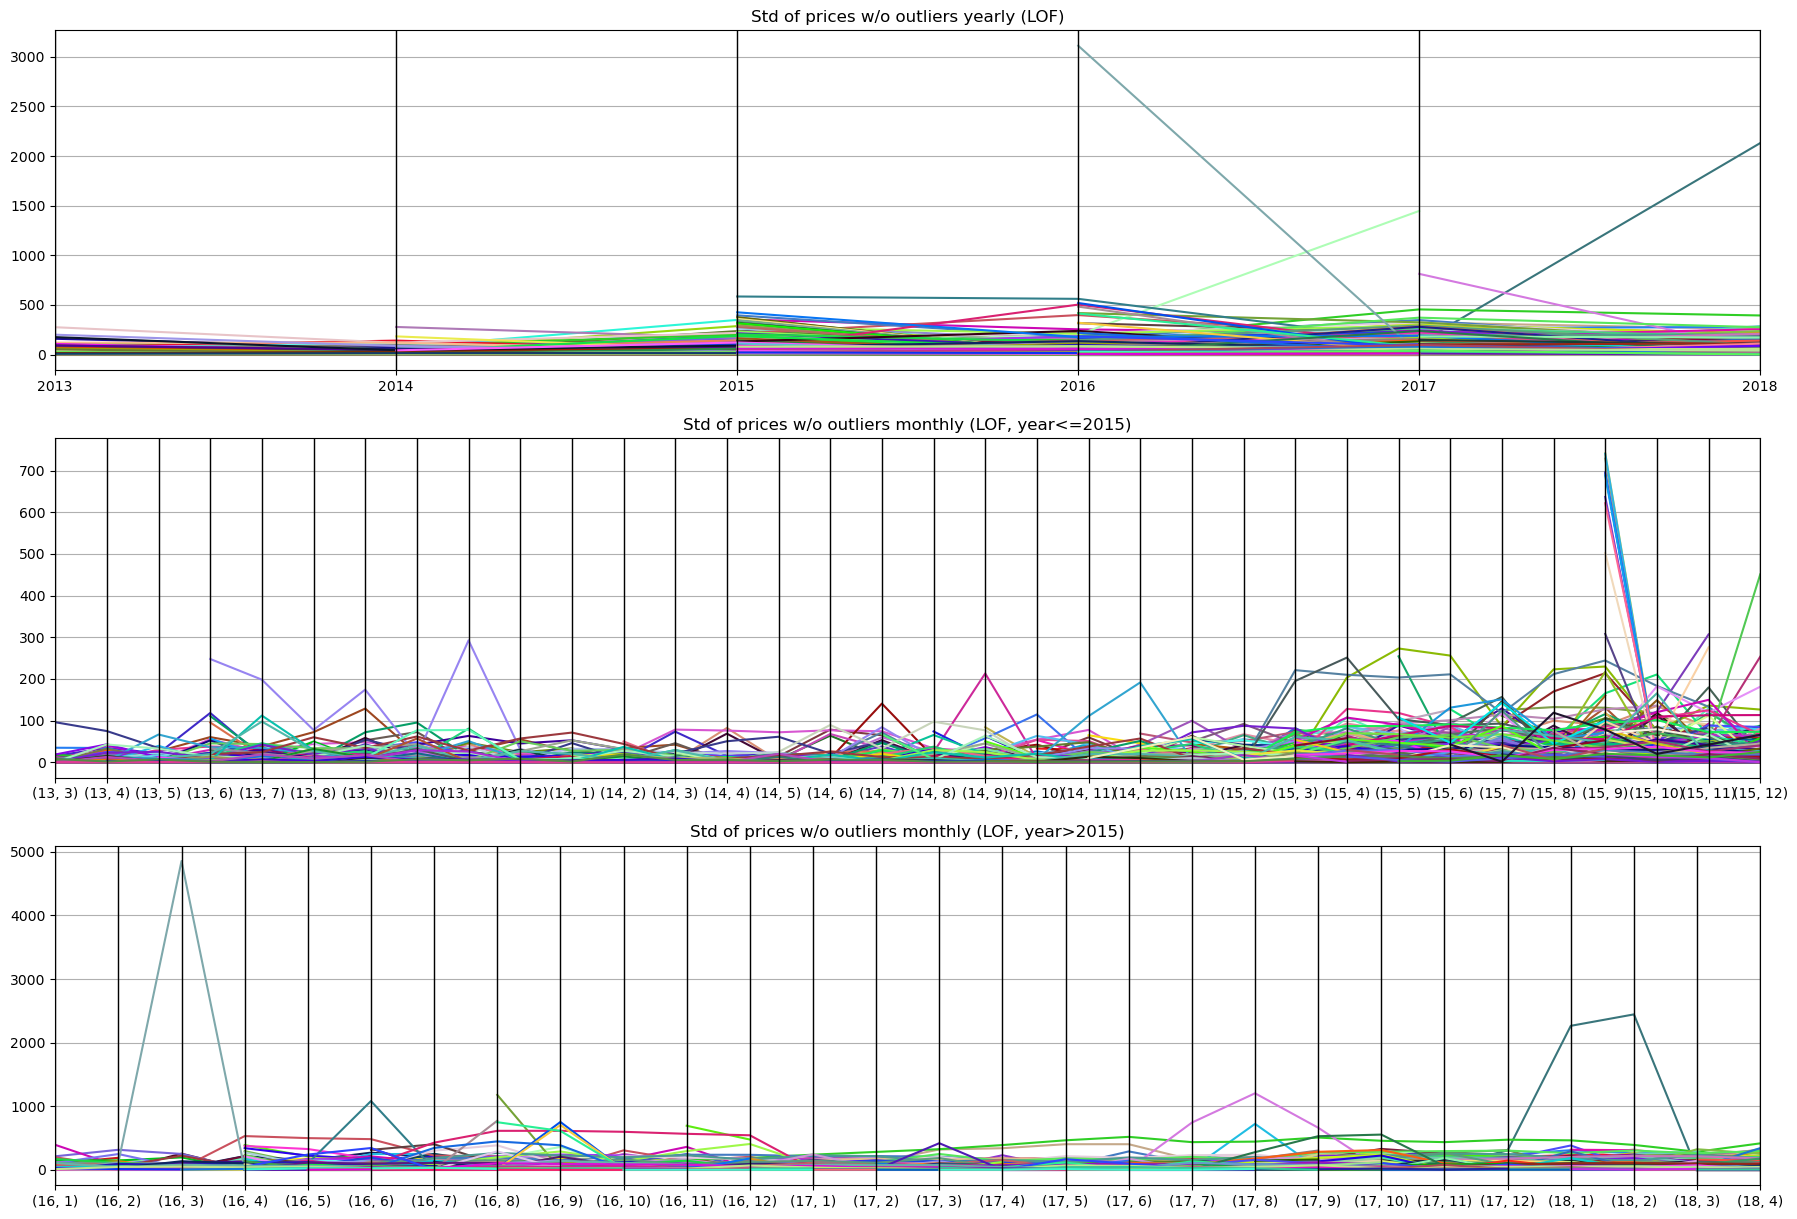

In [116]:
fig = plt.figure(figsize=(22, 15))
fig_dims = (3, 1)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Std of prices w/o outliers yearly (LOF)")
pd.plotting.parallel_coordinates(transform_dataset_ind_col_yearly(df_sales_wo_out_lof), "ram_code")
plt.gca().get_legend().remove() #Remove legend

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Std of prices w/o outliers monthly (LOF, year<=2015)")
pd.plotting.parallel_coordinates(transform_dataset_ind_col_monthly(df_sales_wo_out_lof.loc[df_sales_wo_out_lof["year"]<=2015]), "ram_code")
plt.gca().get_legend().remove() #Remove legend

plt.subplot2grid(fig_dims, (2, 0))
plt.title("Std of prices w/o outliers monthly (LOF, year>2015)")
pd.plotting.parallel_coordinates(transform_dataset_ind_col_monthly(df_sales_wo_out_lof.loc[df_sales_wo_out_lof["year"]>2015]), "ram_code")
plt.gca().get_legend().remove() #Remove legend

plt.show()

**Peaks (15, 9)**

In [285]:
df_tmp_peak15_9_lof = df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2015) & (df_sales_wo_out_lof["month"] == 9)].groupby("ram_code")["sales_uds"].std().sort_values(ascending=False).head(9)
df_tmp_peak15_9_lof.index.isin(df_tmp_peak15_9_iqr.index).all()

True

The cause of the high std are the same products as the ones discussed above.

**Peak (16, 3)**

In [118]:
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2016) & (df_sales_wo_out_lof["month"].isin([1,2])) & \
                        (df_sales_wo_out_lof["ram_code"] == 2631)].groupby("vendor_code")["sales_uds"].describe()

count          mean         std           min           25%  \
vendor_code                                                                
32            30.0  10411.385645  125.330862  10180.120658  10297.081039   

                      50%           75%           max  
vendor_code                                            
32           10459.441511  10487.380331  10630.741494

Vendor 32 was the only seller for this particular model of ram for 2 months, we assume that the high prices are due to a low supply and high demand for the product.

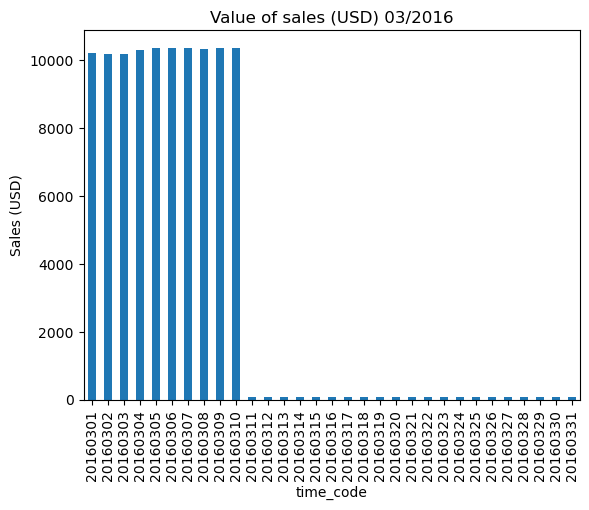

In [305]:
plt.title("Value of sales (USD) 03/2016")
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2016) & (df_sales_wo_out_lof["month"] == 3) & \
                        (df_sales_wo_out_lof["ram_code"] == 2631)].groupby("time_code")["sales_uds"].min().plot(kind="bar")
plt.ylabel("Sales (USD)")
plt.show()

From 11/03/2016 onwards the prices drop drastically.

In [120]:
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2016) & (df_sales_wo_out_lof["month"] == 9) & \
                        (df_sales_wo_out_lof["ram_code"] == 2631)].groupby("vendor_code")["sales_uds"].describe()

count       mean        std        min        25%        50%  \
vendor_code                                                                 
32            30.0  42.747585   1.126728  41.427947  42.337428  42.381882   
68            10.0  91.293081  16.786887  80.031100  83.685212  83.894661   

                   75%         max  
vendor_code                         
32           42.699222   46.357318  
68           84.270226  123.253664

From 09/2016 a new vendor starts selling this product, the prices are not altered by much.

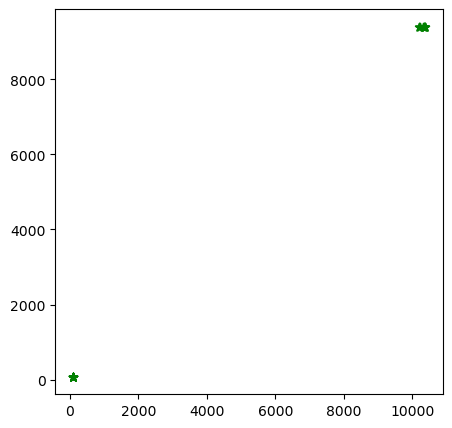

In [121]:
tmp_plt_df = df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2016) & (df_sales_wo_out_lof["month"] == 3) & \
                                     (df_sales_wo_out_lof["ram_code"] == 2631)]

plt.figure(figsize=(5,5))
plt.scatter(tmp_plt_df["sales_uds"], tmp_plt_df["sales_currency"], c="g", marker="*")
plt.show()

The cause of this anomaly is the separate cluster (upper right) that we noticed earlier during the analysis of the different outlier detection approaches.

**Peak (16, 6)**

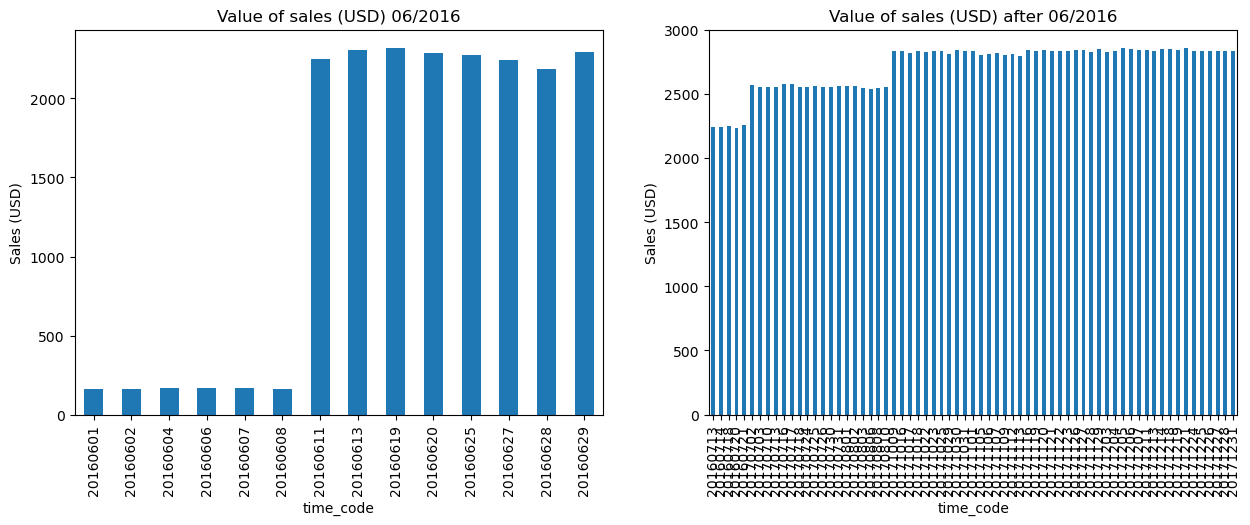

In [304]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2016) & (df_sales_wo_out_lof["month"] == 6) & \
                        (df_sales_wo_out_lof["ram_code"] == 1055)].groupby("time_code").min()["sales_uds"]\
                        .plot(kind="bar", title=("Value of sales (USD) 06/2016"), ax=axes[0], ylabel="Sales (USD)")

df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] >= 2016) & (df_sales_wo_out_lof["month"] > 6) & \
                        (df_sales_wo_out_lof["ram_code"] == 1055)].groupby("time_code").min()["sales_uds"]\
                        .plot(kind="bar", title=("Value of sales (USD) after 06/2016"), ax=axes[1], ylabel="Sales (USD)")

plt.show()

We have a different product in this spot compared to the LOF dataset, the behaviour is still a sudden increase in price.  
All subsequent prices stayed high.

**Peak (16, 8)**

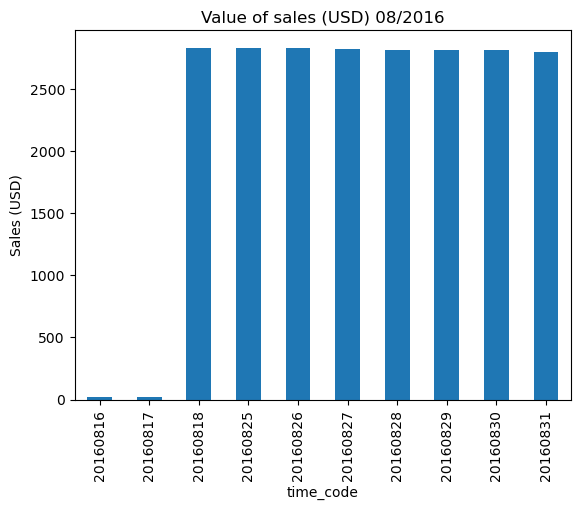

In [312]:
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2016) & (df_sales_wo_out_lof["month"] == 8) & \
                        (df_sales_wo_out_lof["ram_code"] == 1034)].groupby("time_code")["sales_uds"].min()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) 08/2016")
plt.show()

Usual pattern, the vendor spiked the prices for some reason.

**Peak (17, 8)**

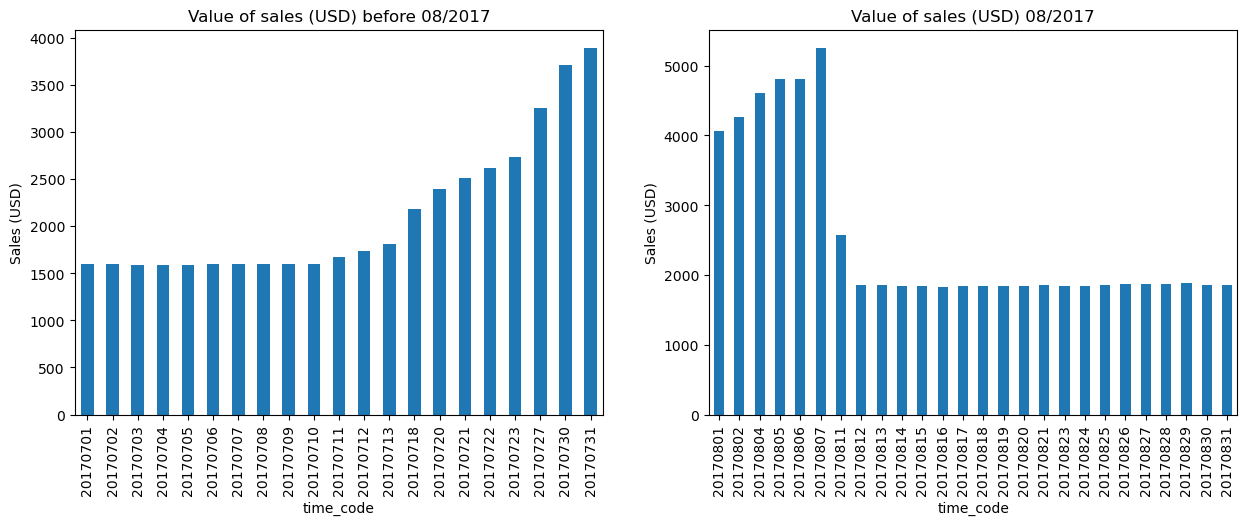

In [318]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2017) & (df_sales_wo_out_lof["month"] == 8) & \
                        (df_sales_wo_out_lof["ram_code"] == 1202)].groupby("time_code")["sales_uds"].min()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) 08/2017", ax=axes[1])

df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2017) & (df_sales_wo_out_lof["month"].isin([7])) & \
                        (df_sales_wo_out_lof["ram_code"] == 1202)].groupby("time_code")["sales_uds"].min()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) before 08/2017", ax=axes[0])

plt.show()

The prices decreased (for once).  
We can see from the values of the months prior that the spike is localised to the end of July/beginning of August.

**Peak (18, 1)-(18, 2)**

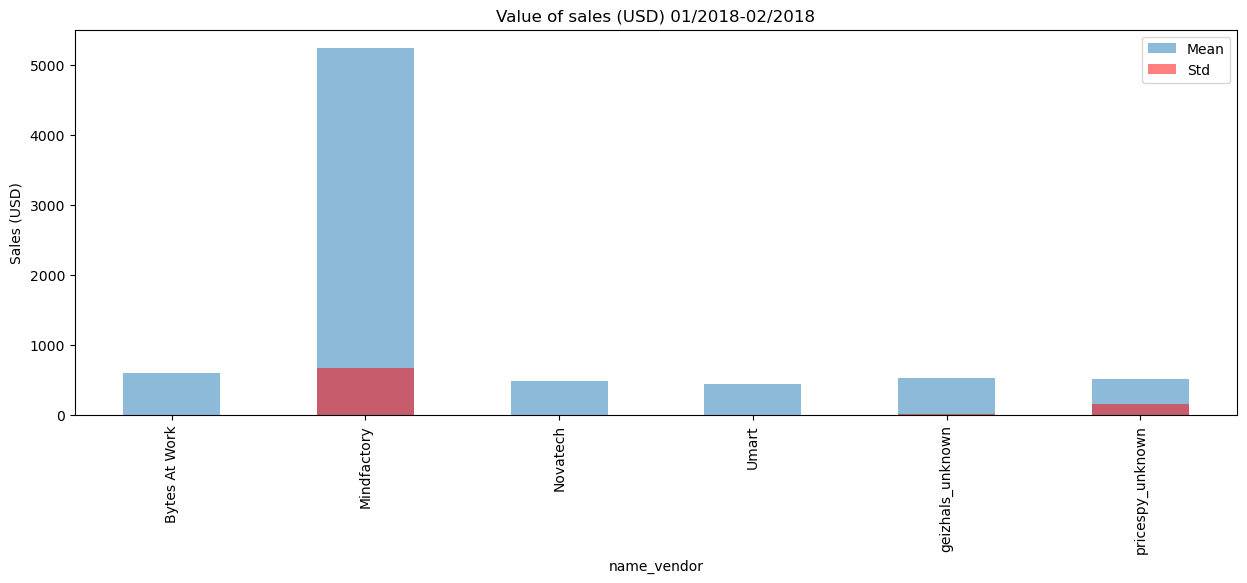

In [350]:
plt.figure(figsize=(15,5))
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2018) & (df_sales_wo_out_lof["month"].isin([1,2])) & \
                        (df_sales_wo_out_lof["ram_code"] == 683)].groupby("name_vendor")["sales_uds"].mean()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) 01/2018-02/2018", alpha=0.50, label="Mean")
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2018) & (df_sales_wo_out_lof["month"].isin([1,2])) & \
                        (df_sales_wo_out_lof["ram_code"] == 683)].groupby("name_vendor")["sales_uds"].std()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) 01/2018-02/2018", alpha=0.50, label="Std", 
                              color="r")
plt.legend()
plt.show()

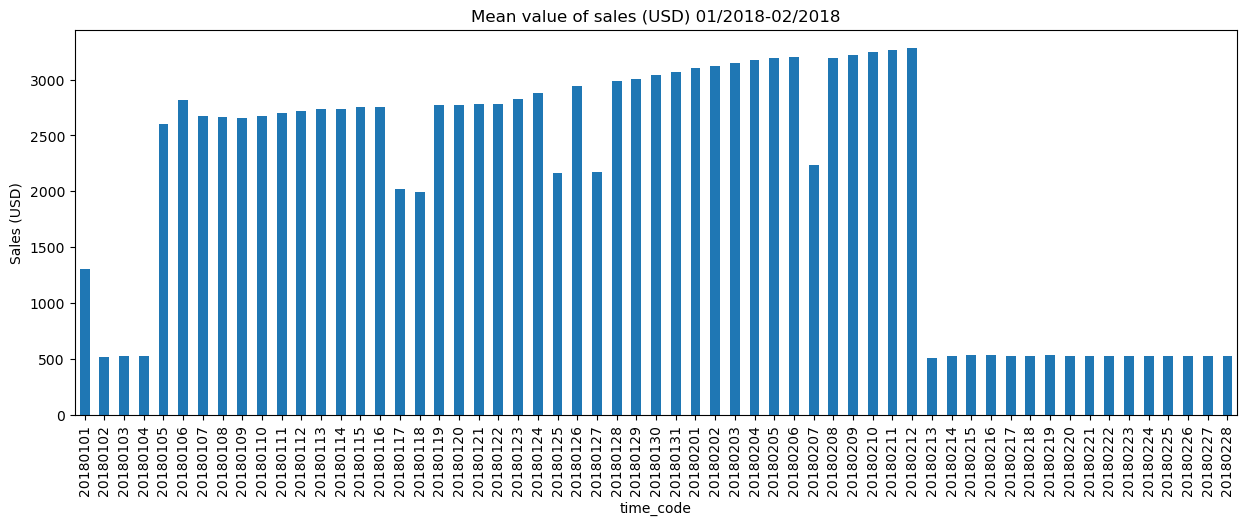

In [322]:
plt.figure(figsize=(15,5))
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2018) & (df_sales_wo_out_lof["month"].isin([1,2])) & \
                        (df_sales_wo_out_lof["ram_code"] == 683)].groupby("time_code")["sales_uds"].mean()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Mean value of sales (USD) 01/2018-02/2018")
plt.show()

It seems that Mindfactory (vendor 43) is practising some atypical price strategy on this ram model, again we suspect that the cause of this phenomenon is a lack of supply otherwise the cheaper competition should force Mindfactory to lower the price.

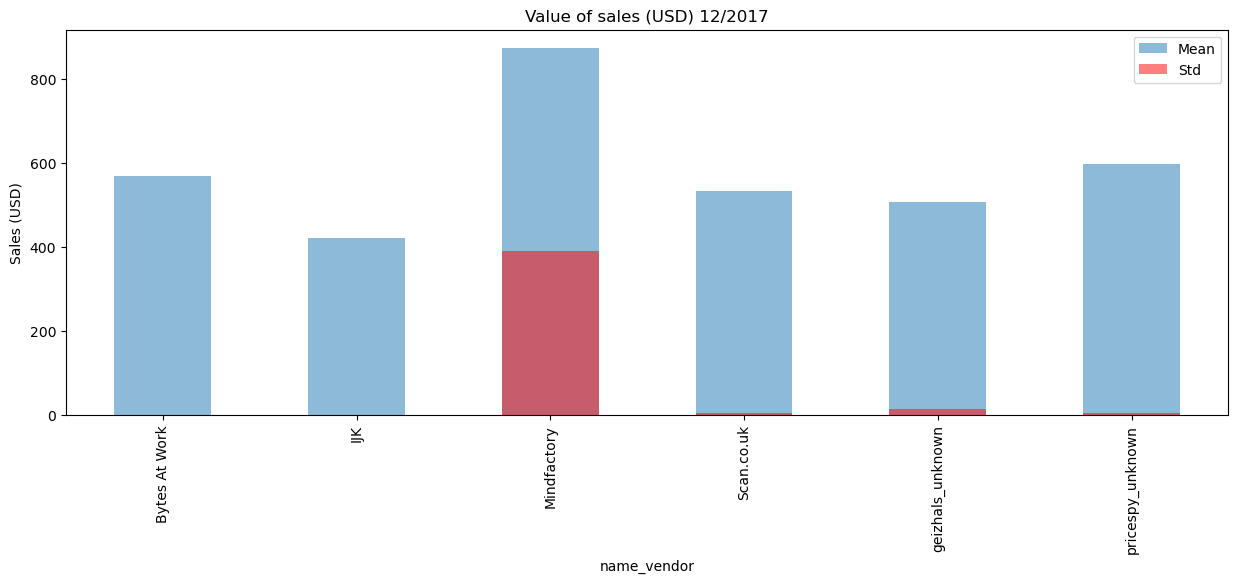

In [353]:
plt.figure(figsize=(15,5))
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2017) & (df_sales_wo_out_lof["month"] == 12) & \
                        (df_sales_wo_out_lof["ram_code"] == 683)].groupby("name_vendor")["sales_uds"].mean()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) 12/2017", alpha=0.50, label="Mean")
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] == 2017) & (df_sales_wo_out_lof["month"] == 12) & \
                        (df_sales_wo_out_lof["ram_code"] == 683)].groupby("name_vendor")["sales_uds"].std()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) 12/2017", alpha=0.50, label="Std", 
                              color="r")
plt.legend()
plt.show()

The prices at the end of 2017 were still reasonable, even though Mindfactory is still the most expensive one.

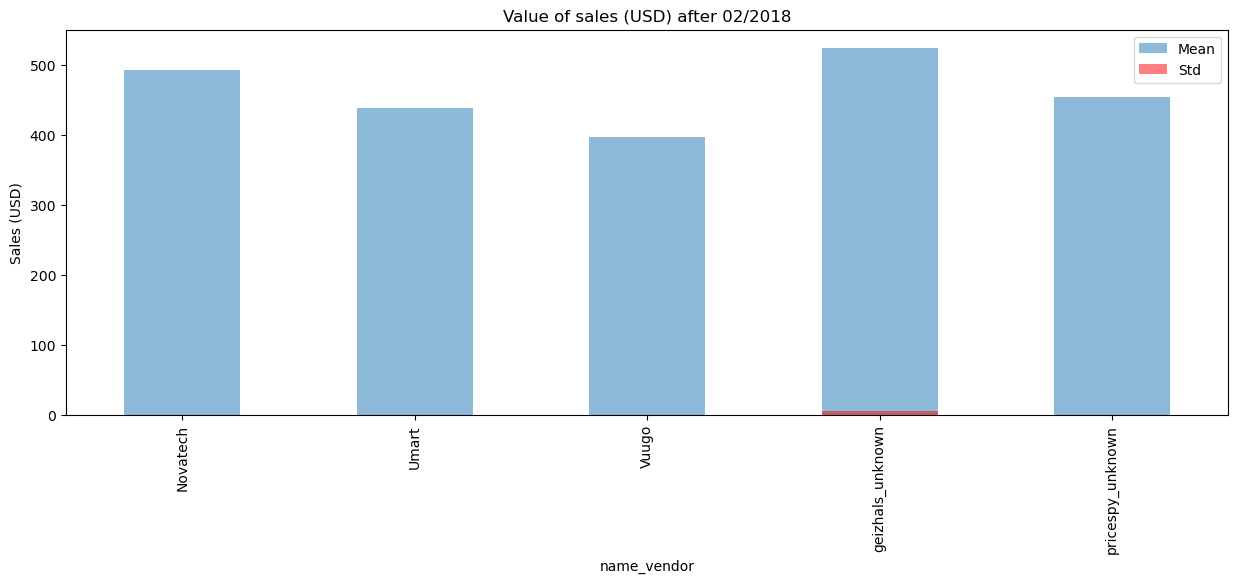

In [356]:
plt.figure(figsize=(15,5))
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] >= 2018) & (df_sales_wo_out_lof["month"] >= 3) & \
                        (df_sales_wo_out_lof["ram_code"] == 683)].groupby("name_vendor")["sales_uds"].mean()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) after 02/2018", alpha=0.50, label="Mean")
df_sales_wo_out_lof.loc[(df_sales_wo_out_lof["year"] >= 2018) & (df_sales_wo_out_lof["month"] >= 3) & \
                        (df_sales_wo_out_lof["ram_code"] == 683)].groupby("name_vendor")["sales_uds"].std()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) after 02/2018", alpha=0.50, label="Std", 
                              color="r")
plt.legend()
plt.show()

From march onwards Mindfactory stopped selling the product altogether.

#### Clustering

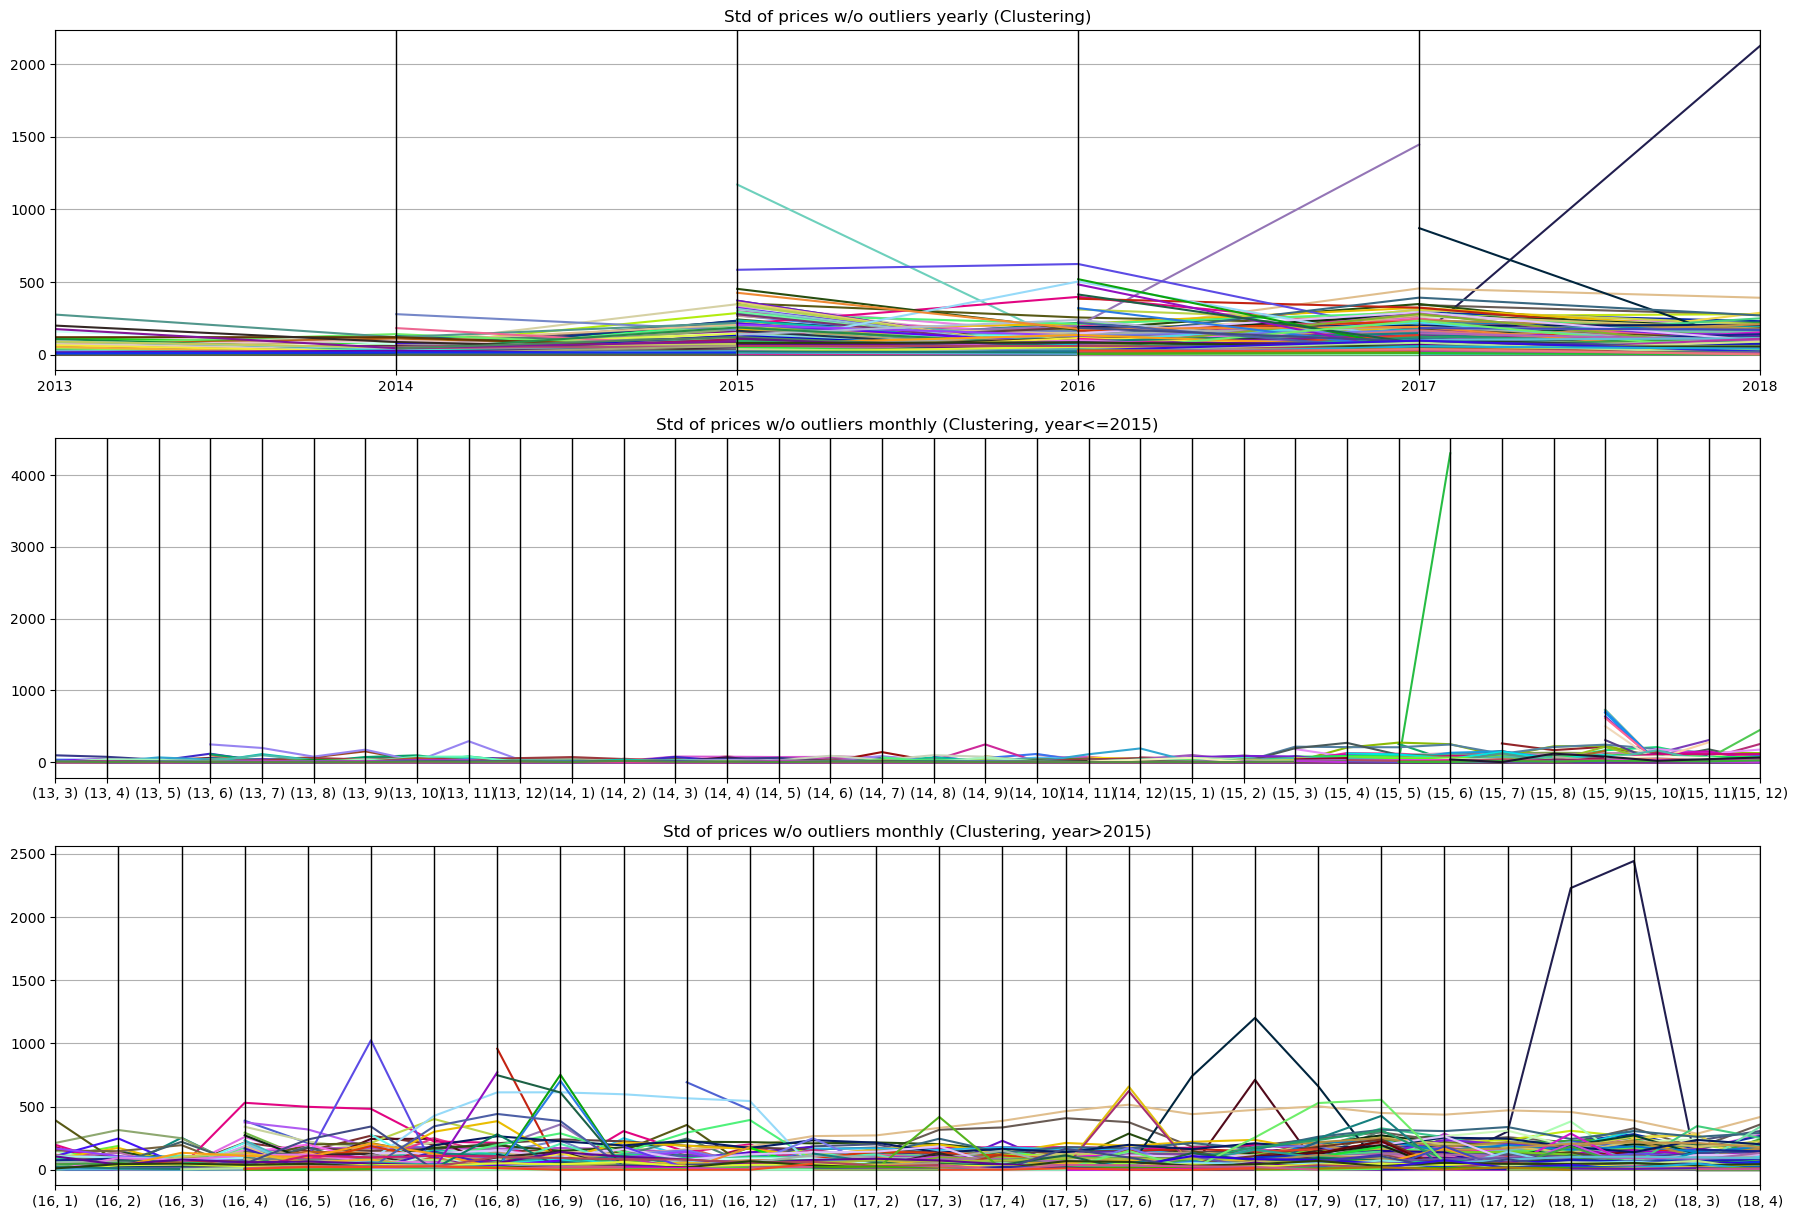

In [132]:
fig = plt.figure(figsize=(22, 15))
fig_dims = (3, 1)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Std of prices w/o outliers yearly (Clustering)")
pd.plotting.parallel_coordinates(transform_dataset_ind_col_yearly(df_sales_wo_out_clustering), "ram_code")
plt.gca().get_legend().remove() #Remove legend

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Std of prices w/o outliers monthly (Clustering, year<=2015)")
pd.plotting.parallel_coordinates(transform_dataset_ind_col_monthly(df_sales_wo_out_clustering.loc[df_sales_wo_out_clustering["year"]<=2015]), "ram_code")
plt.gca().get_legend().remove() #Remove legend

plt.subplot2grid(fig_dims, (2, 0))
plt.title("Std of prices w/o outliers monthly (Clustering, year>2015)")
pd.plotting.parallel_coordinates(transform_dataset_ind_col_monthly(df_sales_wo_out_clustering.loc[df_sales_wo_out_clustering["year"]>2015]), "ram_code")
plt.gca().get_legend().remove() #Remove legend

plt.show()

**Peak (15, 6)**

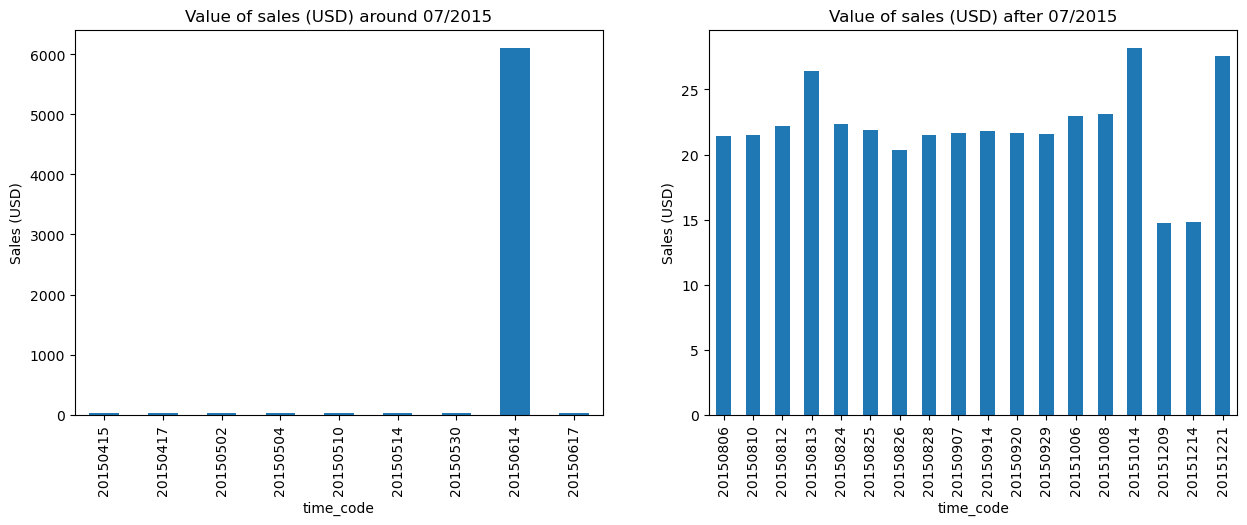

In [360]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

df_sales_wo_out_clustering.loc[(df_sales_wo_out_clustering["year"] == 2015) & (df_sales_wo_out_clustering["month"] <= 7) & \
                               (df_sales_wo_out_clustering["ram_code"] == 34)].groupby("time_code")["sales_uds"].min()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) around 06/2015", ax=axes[0])

df_sales_wo_out_clustering.loc[(df_sales_wo_out_clustering["year"] == 2015) & (df_sales_wo_out_clustering["month"] > 7) & \
                               (df_sales_wo_out_clustering["ram_code"] == 34)].groupby("time_code")["sales_uds"].min()\
                        .plot(kind="bar", ylabel="Sales (USD)", title="Value of sales (USD) after 07/2015", ax=axes[1])

plt.show()

Same old story, the price increased by a lot, this time however the spike is limited to a single day.  
Note that this outlier was already handled by both LOF and IQR.  
The abrupt end on the std graph is due to the product not being sold during 07/2015.

**Peak (16, 6)**

Same as above, the culprit is ram_code 1055.

**Peak (17, 8)**

Same as above, the culprit is ram_code 1202.

**Peak (18, 1)-(18, 2)**

Same as above, the culprit is ram_code 683.

### Conclusions

While many of the situations encountered in this analysis seem to be the fault of outliers we don't feel comfortable in removing the datapoints since these behaviours can be the result of the underlying market forces and not just a product of human errors.  
We therefore think it best to keep them and see how their inclusion affects our analysis.  
Furthermore, as we pointed out during this section, the different approaches for outlier detection used seem to cover a wide range of situations in which these outliers and spikes have been removed so we will be able to understand the impact on our vendor dataset and its behaviour.

## Vendor features

In [135]:
df_sales_merged.head()

Id  ram_code  brand   name  memory memory_type  clock  time_code  \
2602347  3719       1.0  ADATA  Adata     0.5         DDR    400   20130322   
2602348  3719       1.0  ADATA  Adata     0.5         DDR    400   20130323   
2602349  3719       1.0  ADATA  Adata     0.5         DDR    400   20130326   
2602350  3719       1.0  ADATA  Adata     0.5         DDR    400   20130327   
2602351  3719       1.0  ADATA  Adata     0.5         DDR    400   20130328   

         year  month  ...  week  geo_code  continent  country  \
2602347  2013      3  ...    12        25     Europe  Germany   
2602348  2013      3  ...    12        18     Europe  Germany   
2602349  2013      3  ...    13        28     Europe  Germany   
2602350  2013      3  ...    13        25     Europe  Germany   
2602351  2013      3  ...    13        27     Europe  Germany   

                         region currency vendor_code       name_vendor  \
2602347  north rhine-westphalla      EUR          32  geizhals_unknown   
2602348                  berlin      EUR          32  geizhals_unknown   
2602349                  saxony      EUR          32  geizhals_unknown   
2602350  north rhine-westphalla      EUR          32  geizhals_unknown   
2602351                saarland      EUR          32  geizhals_unknown   

         sales_uds  sales_currency  
2602347  13.749032           10.65  
2602348  13.828708           10.65  
2602349  13.694297           10.65  
2602350  13.690530           10.65  
2602351  13.605216           10.65  

[5 rows x 21 columns]

### Definitions

In [136]:
def add_features(dest_df, source_df):

    #Modify the data frame locally (possibly not needed)
    dest_df = dest_df.copy()
    
    #Total number of items sold by vendor
    IFeature = source_df.groupby(["vendor_code"]).size().rename("I")
    dest_df = dest_df.join(IFeature, on="vendor_code")
    
    #Total number of unique items sold by vendor
    IuFeature = source_df.groupby(["vendor_code"]).ram_code.nunique()
    dest_df = dest_df.join(IuFeature, on="vendor_code").rename(columns={"ram_code":"Iu"})
    
    #Max value of item sold (USD)
    MaxValFeature = source_df.groupby(["vendor_code"])["sales_uds"].max().rename("MaxValuePerOrder")
    dest_df = dest_df.join(MaxValFeature, on="vendor_code")
    
    #Avg value per item sold (USD)
    AvgValFeature = source_df.groupby(["vendor_code"])["sales_uds"].mean().rename("AvgValuePerOrder")
    dest_df = dest_df.join(AvgValFeature, on="vendor_code")
    
    #Max value items sold in a month (USD)
    vendorRamCount = source_df.groupby(["vendor_code", "year", "month"])["sales_uds"].sum()
    IMaxValMonthFeature = vendorRamCount.groupby(["vendor_code"]).max().rename("IMaxMonthSales")
    dest_df = dest_df.join(IMaxValMonthFeature, on="vendor_code")
    
    #Avg value items sold in a month (USD)
    vendorRamCount = source_df.groupby(["vendor_code", "year", "month"])["sales_uds"].sum()
    IAvgValMonthFeature = vendorRamCount.groupby(["vendor_code"]).mean().rename("IAvgMonthSales")
    dest_df = dest_df.join(IAvgValMonthFeature, on="vendor_code")
    
    #Max number items sold in a month
    vendorRamCount = source_df.groupby(["vendor_code", "year", "month"]).size()
    IMaxMonthFeature = vendorRamCount.groupby(["vendor_code"]).max().rename("IMaxMonthItems")
    dest_df = dest_df.join(IMaxMonthFeature, on="vendor_code")
    
    #Avg number items sold in a month
    vendorRamCount = source_df.groupby(["vendor_code", "year", "month"]).size()
    IAvgMonthFeature = vendorRamCount.groupby(["vendor_code"]).mean().rename("IAvgMonthItems")
    dest_df = dest_df.join(IAvgMonthFeature, on="vendor_code")
    
    #Number of months in business
    vendorMonthCount = source_df.groupby(["vendor_code", "year"])["month"].nunique()
    TotMonthFeature = vendorMonthCount.groupby(["vendor_code"]).sum().rename("TotMonthBusiness")
    dest_df = dest_df.join(TotMonthFeature, on="vendor_code")
    
    #The Shannon entropy on the selling behaviour of the vendor: different "ram_codes" sold
    probSeriesGrouped = source_df.groupby(["vendor_code", "ram_code"]).size()/\
        source_df.groupby("vendor_code")["ram_code"].size()
    logSeriesGrouped = np.log2(probSeriesGrouped)
    ProdProbLogSeriesGrouped = -1 * probSeriesGrouped * logSeriesGrouped
    EFeature = ProdProbLogSeriesGrouped.groupby(["vendor_code"]).sum()
    EFeature.name = "Eram"
    dest_df = dest_df.join(EFeature, on="vendor_code")
    
    #The Shannon entropy on the selling behaviour of the vendor: countries of operation
    #"geo_code" is tied to a single region, therefore we use "country" directly
    probSeriesGrouped = source_df.groupby(["vendor_code", "country"]).size()/\
        source_df.groupby("vendor_code")["country"].size()
    logSeriesGrouped = np.log2(probSeriesGrouped)
    ProdProbLogSeriesGrouped = -1 * probSeriesGrouped * logSeriesGrouped
    EFeature = ProdProbLogSeriesGrouped.groupby(["vendor_code"]).sum()
    EFeature.name = "Egeo"
    dest_df = dest_df.join(EFeature, on="vendor_code")
    
    #The Shannon entropy on the selling behaviour of the vendor: currencies used
    probSeriesGrouped = source_df.groupby(["vendor_code", "currency"]).size()/\
        source_df.groupby("vendor_code")["currency"].size()
    logSeriesGrouped = np.log2(probSeriesGrouped)
    ProdProbLogSeriesGrouped = -1 * probSeriesGrouped * logSeriesGrouped
    EFeature = ProdProbLogSeriesGrouped.groupby(["vendor_code"]).sum()
    EFeature.name = "Ecur"
    dest_df = dest_df.join(EFeature, on="vendor_code")
    
    #TODO: categorical features?

    return dest_df

Let's apply the features to the datasets with and without outliers.

In [137]:
unq_vendor_id = df_sales["vendor_code"].sort_values().unique()
vend_df = pd.DataFrame(data=unq_vendor_id, columns=["vendor_code"]).set_index("vendor_code")

#Add the features to the empty dataframe
vend_df_w_out = add_features(vend_df, df_sales_merged) #Dataframe containing customer features with outliers
vend_df_wo_out_iqrcox = add_features(vend_df, df_sales_wo_out_iqrcox) #Dataframe containing customer features without outliers (iqrcox)
vend_df_wo_out_lof = add_features(vend_df, df_sales_wo_out_lof) #Dataframe containing customer features without outliers (iqrcox)
vend_df_wo_out_clustering = add_features(vend_df, df_sales_wo_out_clustering) #Dataframe containing customer features without outliers (clustering)

### Feature analysis  
In this section we compare results between feature datasets obtained from the sales dataset including and excluding the outliers (with each technique used).

In [138]:
vend_df_w_out.head()

I   Iu  MaxValuePerOrder  AvgValuePerOrder  IMaxMonthSales  \
vendor_code                                                                   
1              778   60        565.439098        132.596405    13847.005800   
2             3950  196       1761.990000        149.269497    59851.672722   
3             3051  203        860.154236        155.098549   326004.683245   
4              407  101        774.077840        142.140184    34249.837706   
5            13042  276       1188.115658        165.866942   239686.814082   

             IAvgMonthSales  IMaxMonthItems  IAvgMonthItems  TotMonthBusiness  \
vendor_code                                                                     
1               4126.400135              77       31.120000                25   
2              29480.725604             433      197.500000                20   
3             157735.224043            2119     1017.000000                 3   
4              28925.527422             238      203.500000                 2   
5             127249.214871            1300      767.176471                17   

                 Eram      Egeo      Ecur  
vendor_code                                
1            5.359042  0.642002  0.642002  
2            6.855648  0.000000  0.000000  
3            7.373180  1.680666  0.000000  
4            6.486558  0.898296  0.898296  
5            7.614150  1.164796  1.093642

#### I: number of total items sold by the vendor

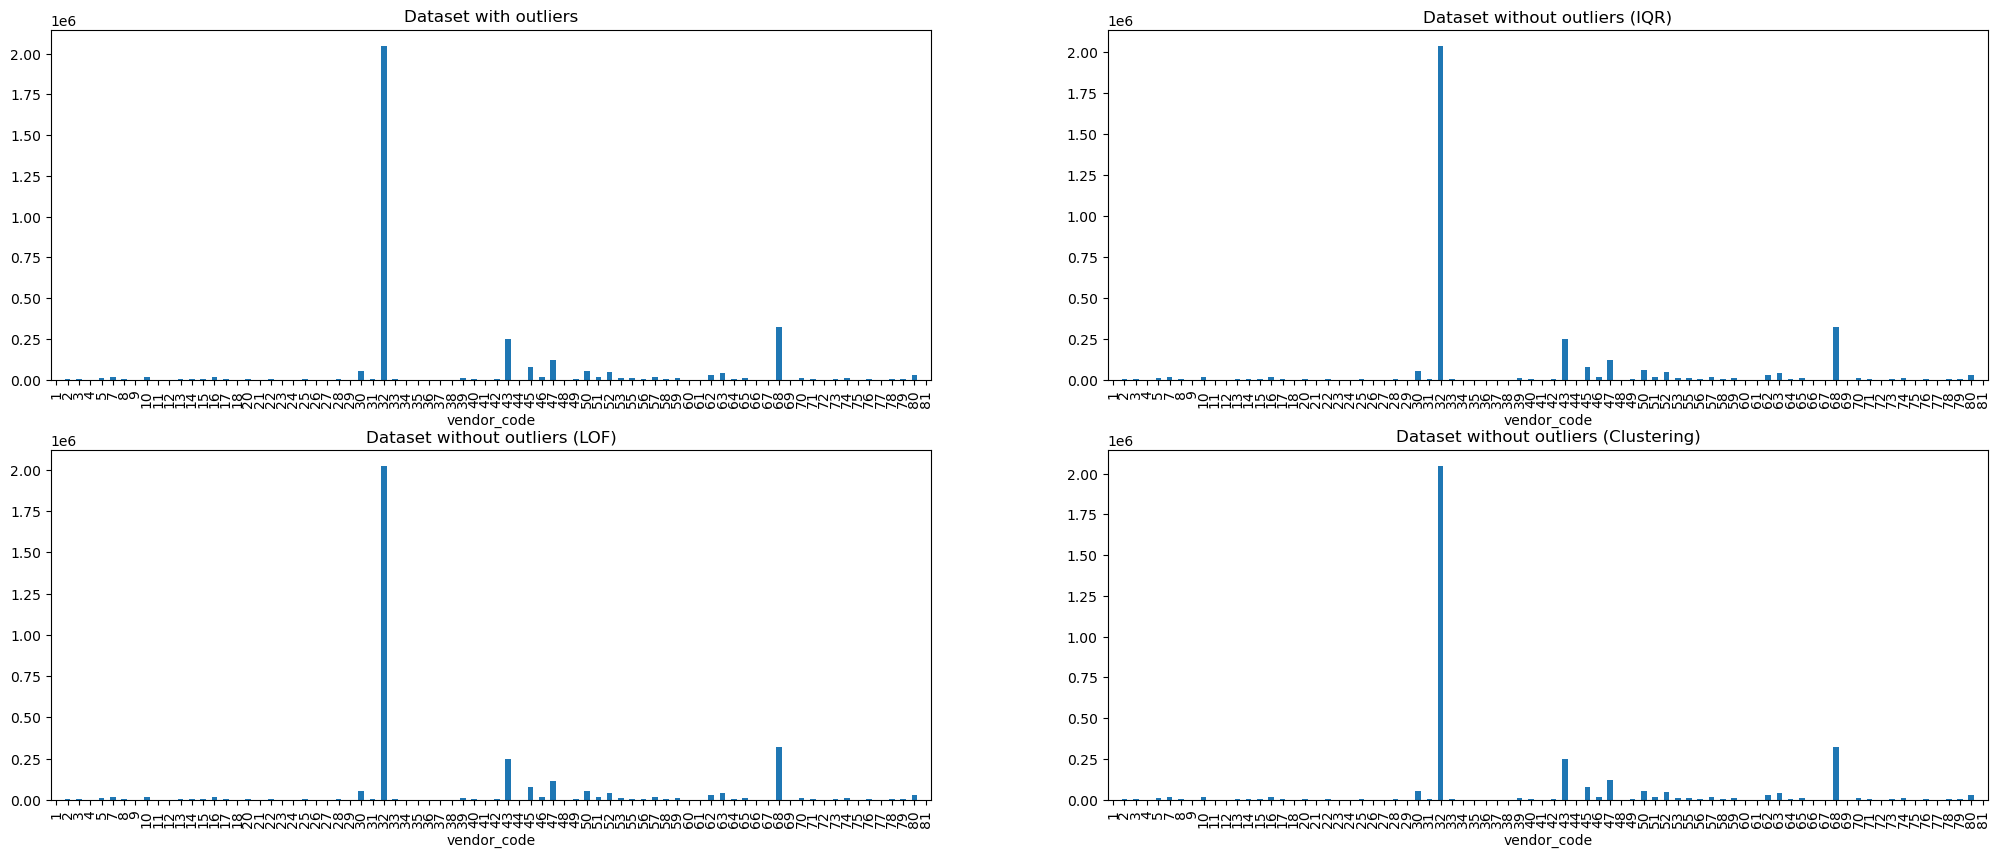

In [139]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["I"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["I"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["I"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["I"].plot(kind="bar")

plt.show()

This feature wasn't impacted since it doesn't care about the removal of extreme values in the sales_* features.

#### Iu: number of unique items sold by the vendor

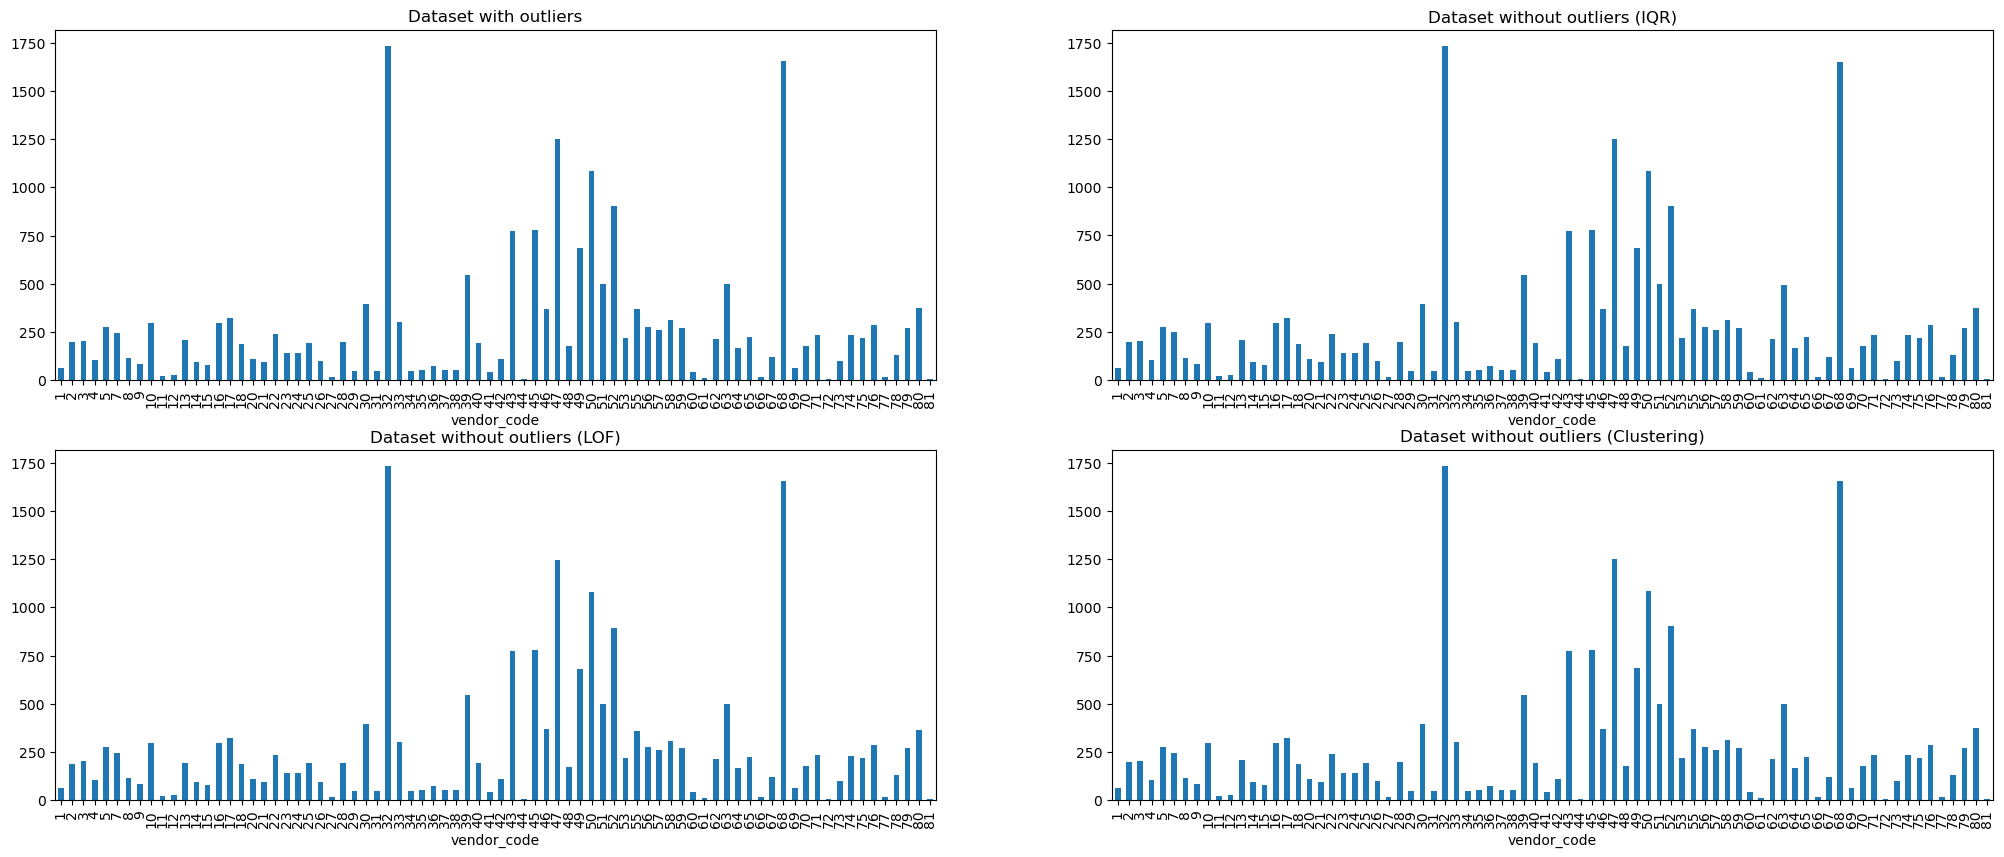

In [140]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["Iu"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["Iu"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["Iu"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["Iu"].plot(kind="bar")

plt.show()

Same as above.

In [141]:
vend_df_w_out

I   Iu  MaxValuePerOrder  AvgValuePerOrder  IMaxMonthSales  \
vendor_code                                                                   
1              778   60        565.439098        132.596405    13847.005800   
2             3950  196       1761.990000        149.269497    59851.672722   
3             3051  203        860.154236        155.098549   326004.683245   
4              407  101        774.077840        142.140184    34249.837706   
5            13042  276       1188.115658        165.866942   239686.814082   
...            ...  ...               ...               ...             ...   
77              76   15        253.427823        116.119106     1201.638954   
78            4092  128        824.990000        110.635742    43650.268494   
79            7685  270       2024.528373        153.706466   189080.489213   
80           30864  373       1148.431614        143.236310   315657.793436   
81              34    6        323.959410        150.410315     2106.898533   

             IAvgMonthSales  IMaxMonthItems  IAvgMonthItems  TotMonthBusiness  \
vendor_code                                                                     
1               4126.400135              77       31.120000                25   
2              29480.725604             433      197.500000                20   
3             157735.224043            2119     1017.000000                 3   
4              28925.527422             238      203.500000                 2   
5             127249.214871            1300      767.176471                17   
...                     ...             ...             ...               ...   
77               519.120708              12        4.470588                17   
78             18108.858197             325      163.680000                25   
79             47249.367575            1472      307.400000                25   
80            176833.818640            2049     1234.560000                25   
81              1278.487679              13        8.500000                 4   

                 Eram      Egeo      Ecur  
vendor_code                                
1            5.359042  0.642002  0.642002  
2            6.855648  0.000000  0.000000  
3            7.373180  1.680666  0.000000  
4            6.486558  0.898296  0.898296  
5            7.614150  1.164796  1.093642  
...               ...       ...       ...  
77           3.697262  0.596511  0.596511  
78           6.399070  0.000000  0.000000  
79           7.761571  0.573958  0.573958  
80           7.153015  0.650474  0.650474  
81           2.427505  0.322757  0.322757  

[78 rows x 12 columns]

#### MaxValuePerOrder: most expensive (usd) item sold by the vendor

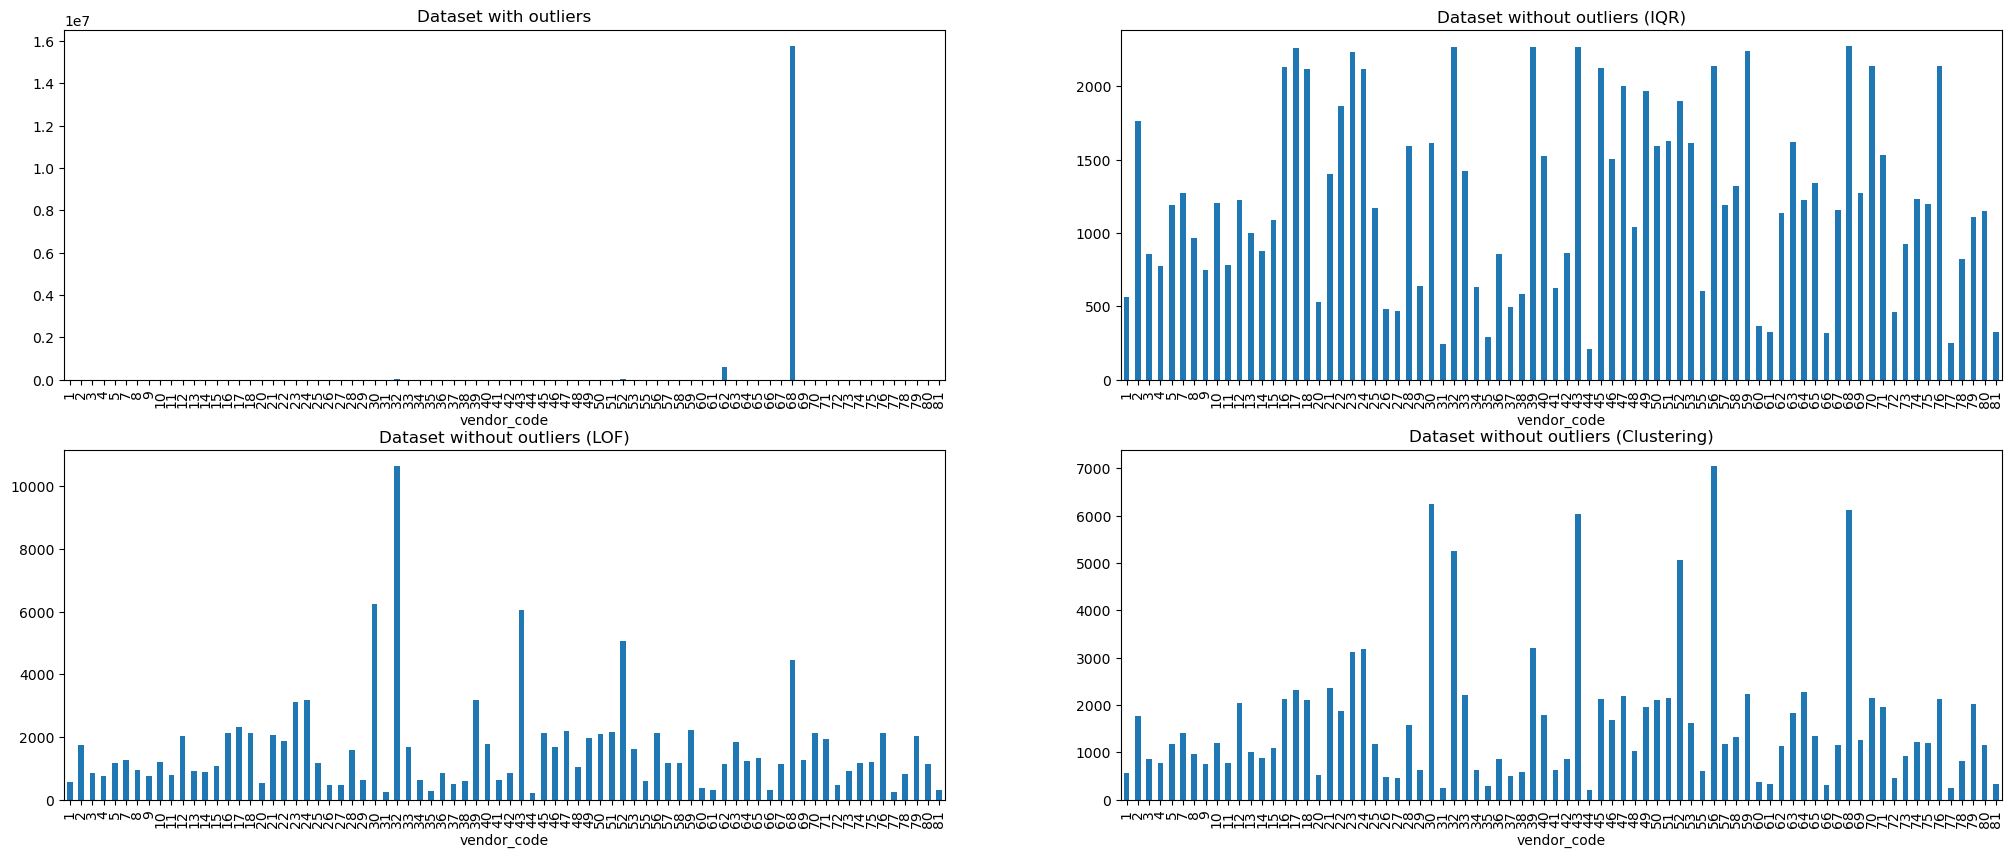

In [142]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["MaxValuePerOrder"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["MaxValuePerOrder"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["MaxValuePerOrder"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["MaxValuePerOrder"].plot(kind="bar")

plt.show()

Considering that the outliers targeted were extreme values (in particular the peak of vendor 68) of the sales_uds/sales_currency features, this outcome was expected.  
However it is interesting to note how differently the algorithms behave, in particular the IQR approach cut a lot of big data points and LOF removed many middling values while also keeping the highest ones (vendor 32).  
Clustering seems the more balanced approach given that it is difficult to predict which ram prices are or not valid across different years/countries.

#### AvgValuePerOrder: average of the price (usd) of the items sold by the vendor

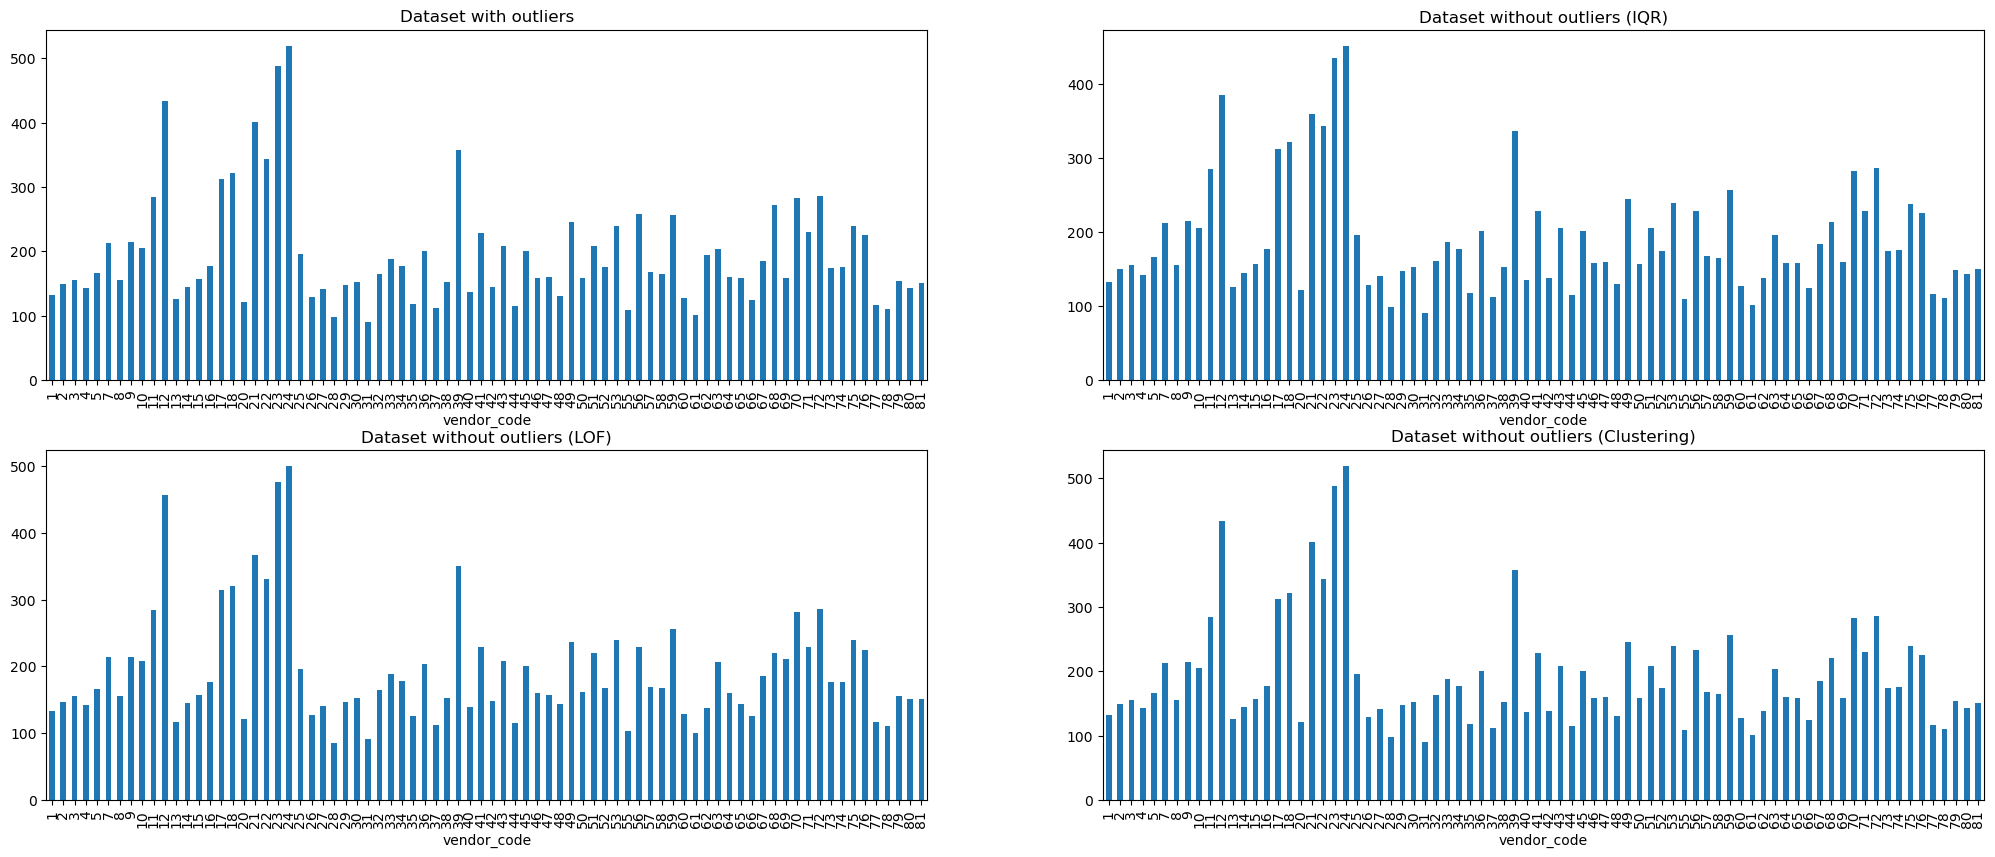

In [143]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["AvgValuePerOrder"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["AvgValuePerOrder"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["AvgValuePerOrder"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["AvgValuePerOrder"].plot(kind="bar")

plt.show()

The removal of extreme values didn't have much of an impact on the average value of the items sold, meaning that every vendor has enough total orders to compensate.

#### IMaxMonthSales: maximum value (usd) of items sold in any month by the vendor

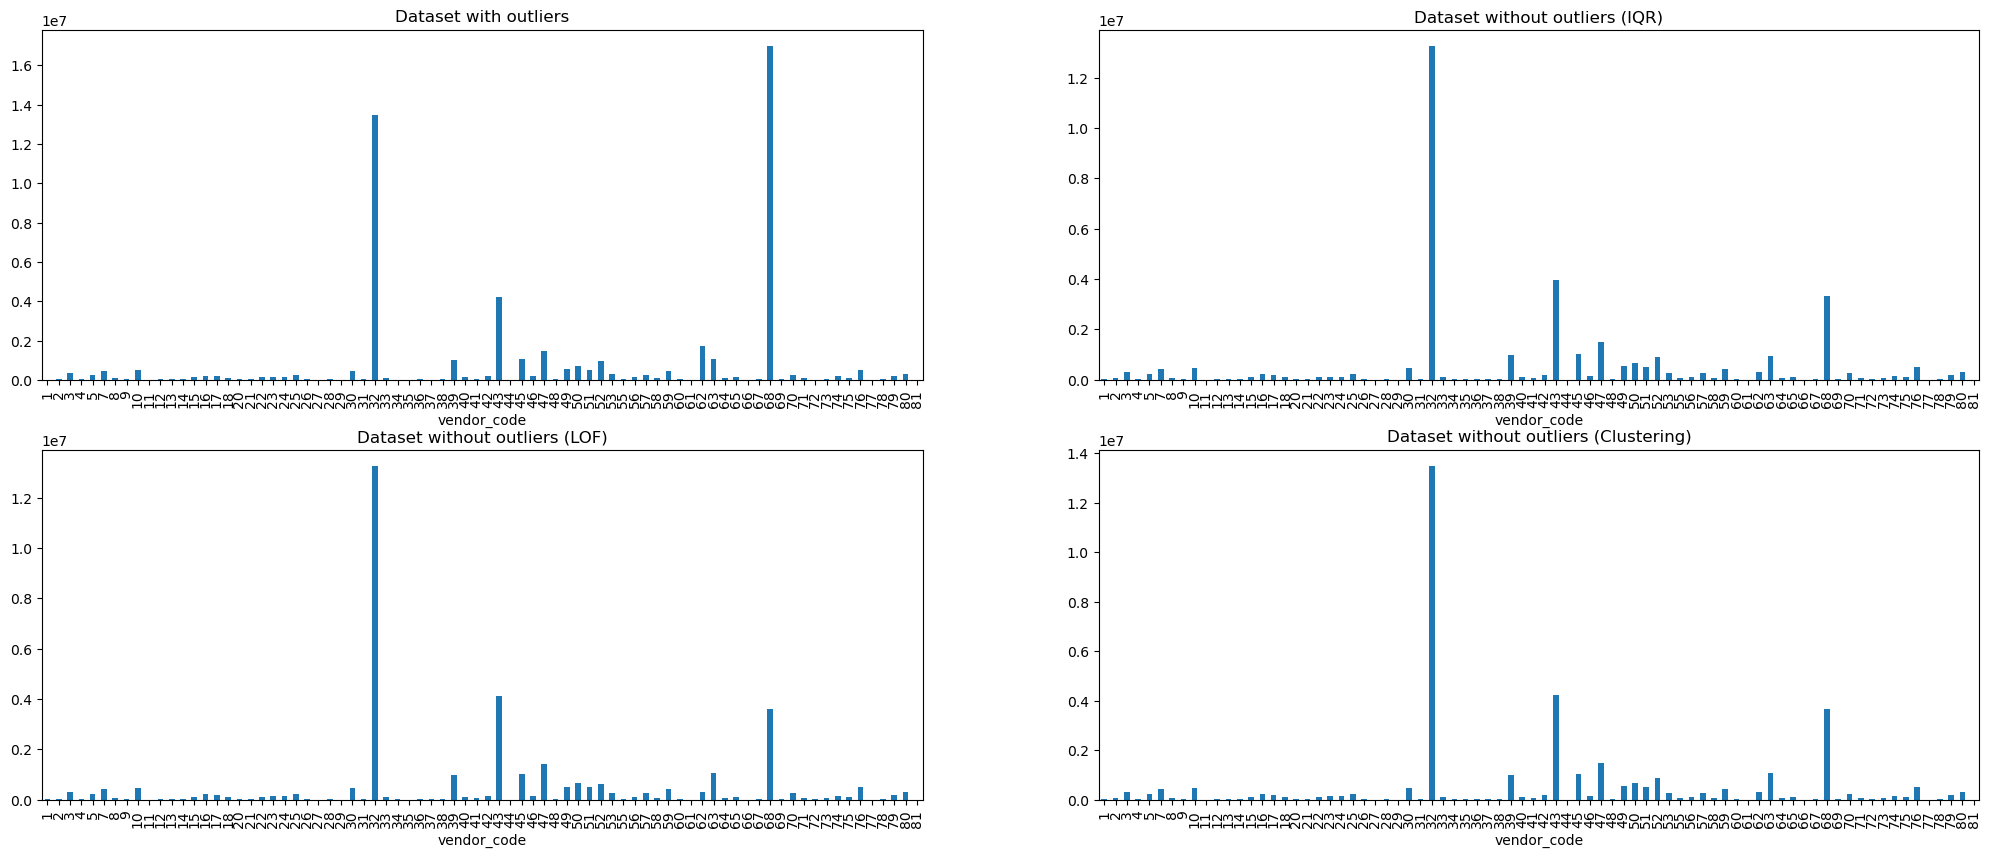

In [144]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["IMaxMonthSales"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["IMaxMonthSales"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["IMaxMonthSales"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["IMaxMonthSales"].plot(kind="bar")

plt.show()

All of the outlier detection methods had more or less the same impact, the main change is the removal of extreme entries for vendor 68.  
The remaining spike is accounted for given the high amount of sales generated by vendor 32, as can be seen in the plots below.

#### IAvgMonthSales: average value of sales in a month by the vendor

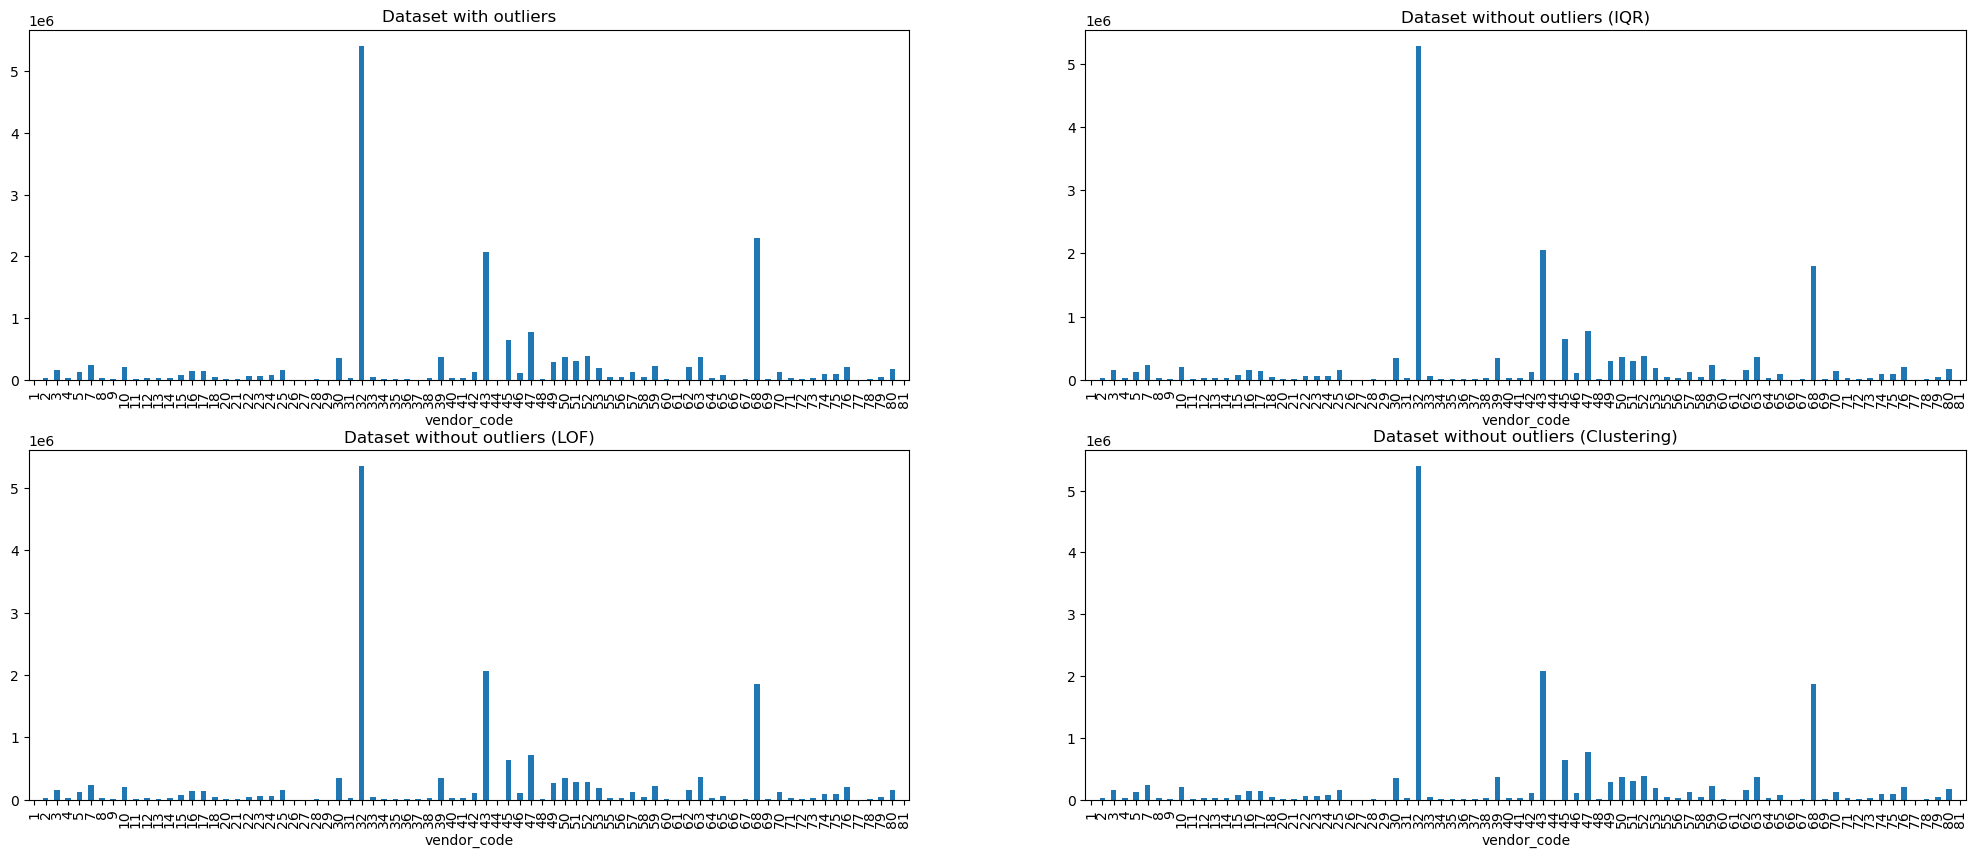

In [145]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["IAvgMonthSales"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["IAvgMonthSales"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["IAvgMonthSales"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["IAvgMonthSales"].plot(kind="bar")

plt.show()

Fairly consistent behaviour, even after outlier removal.  
Again the number of items sold masks the presence of outliers in the data.

#### IMaxMonthItems: maximum number of items sold in any month by the vendor

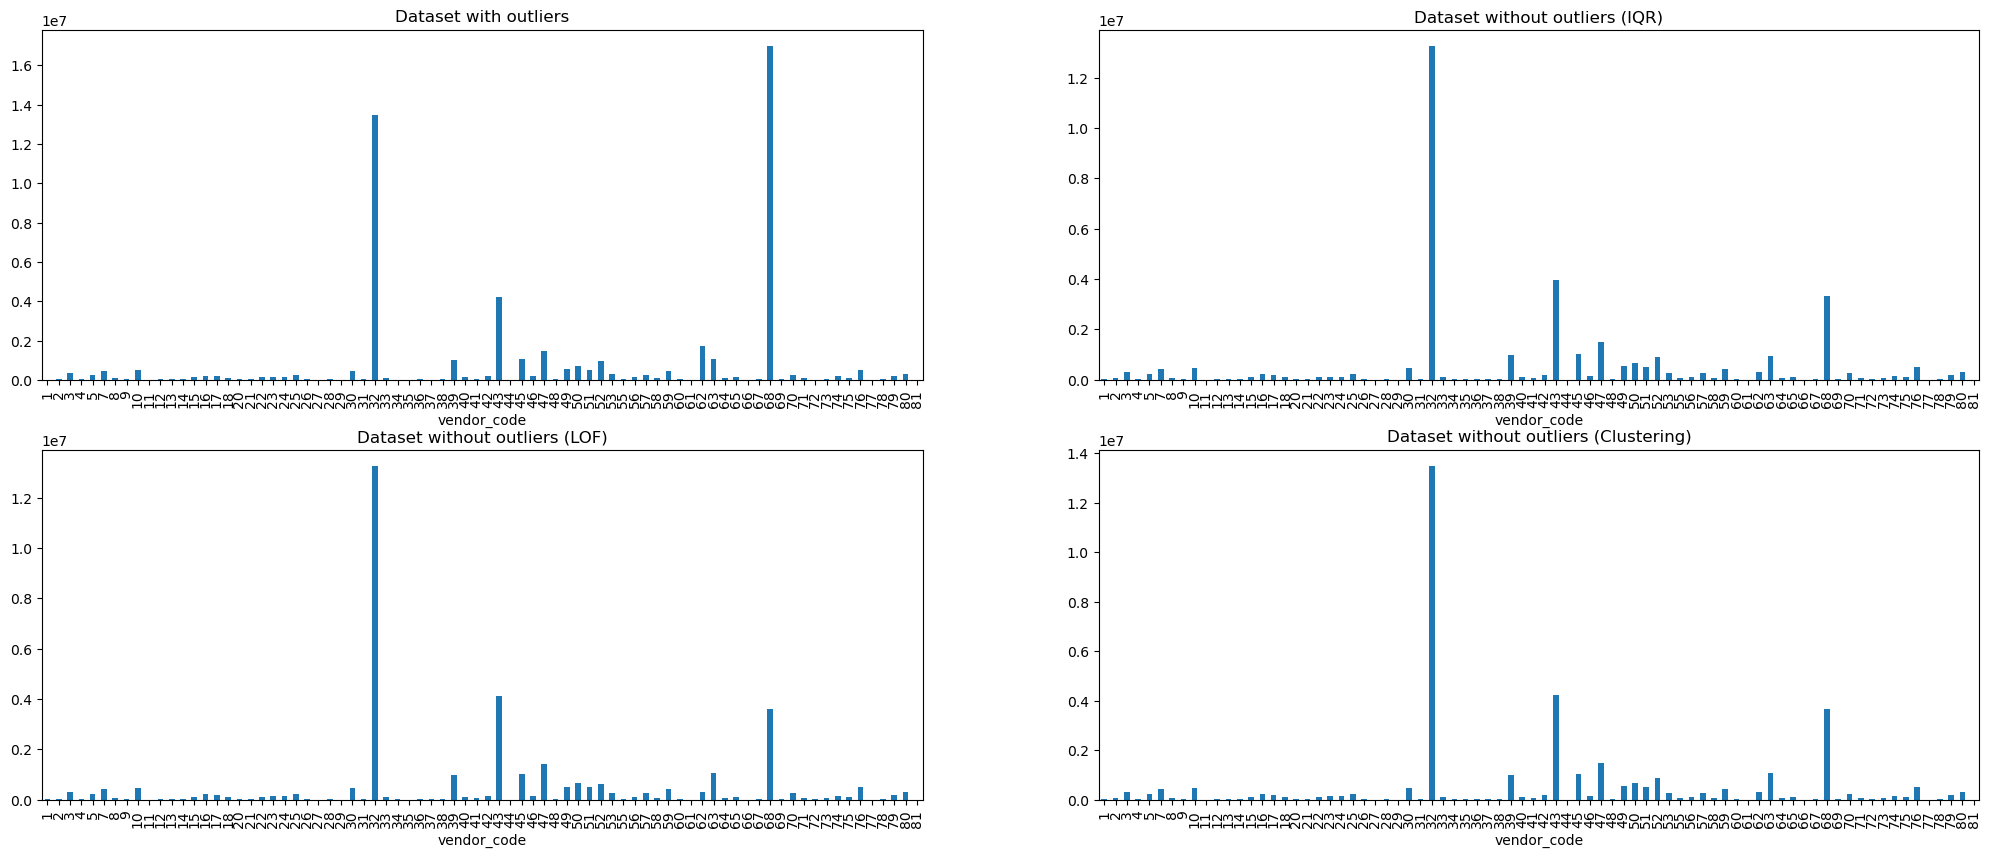

In [146]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["IMaxMonthSales"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["IMaxMonthSales"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["IMaxMonthSales"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["IMaxMonthSales"].plot(kind="bar")

plt.show()

Same as above.

#### IAvgMonthItems: average number of items sold in a month by the vendor

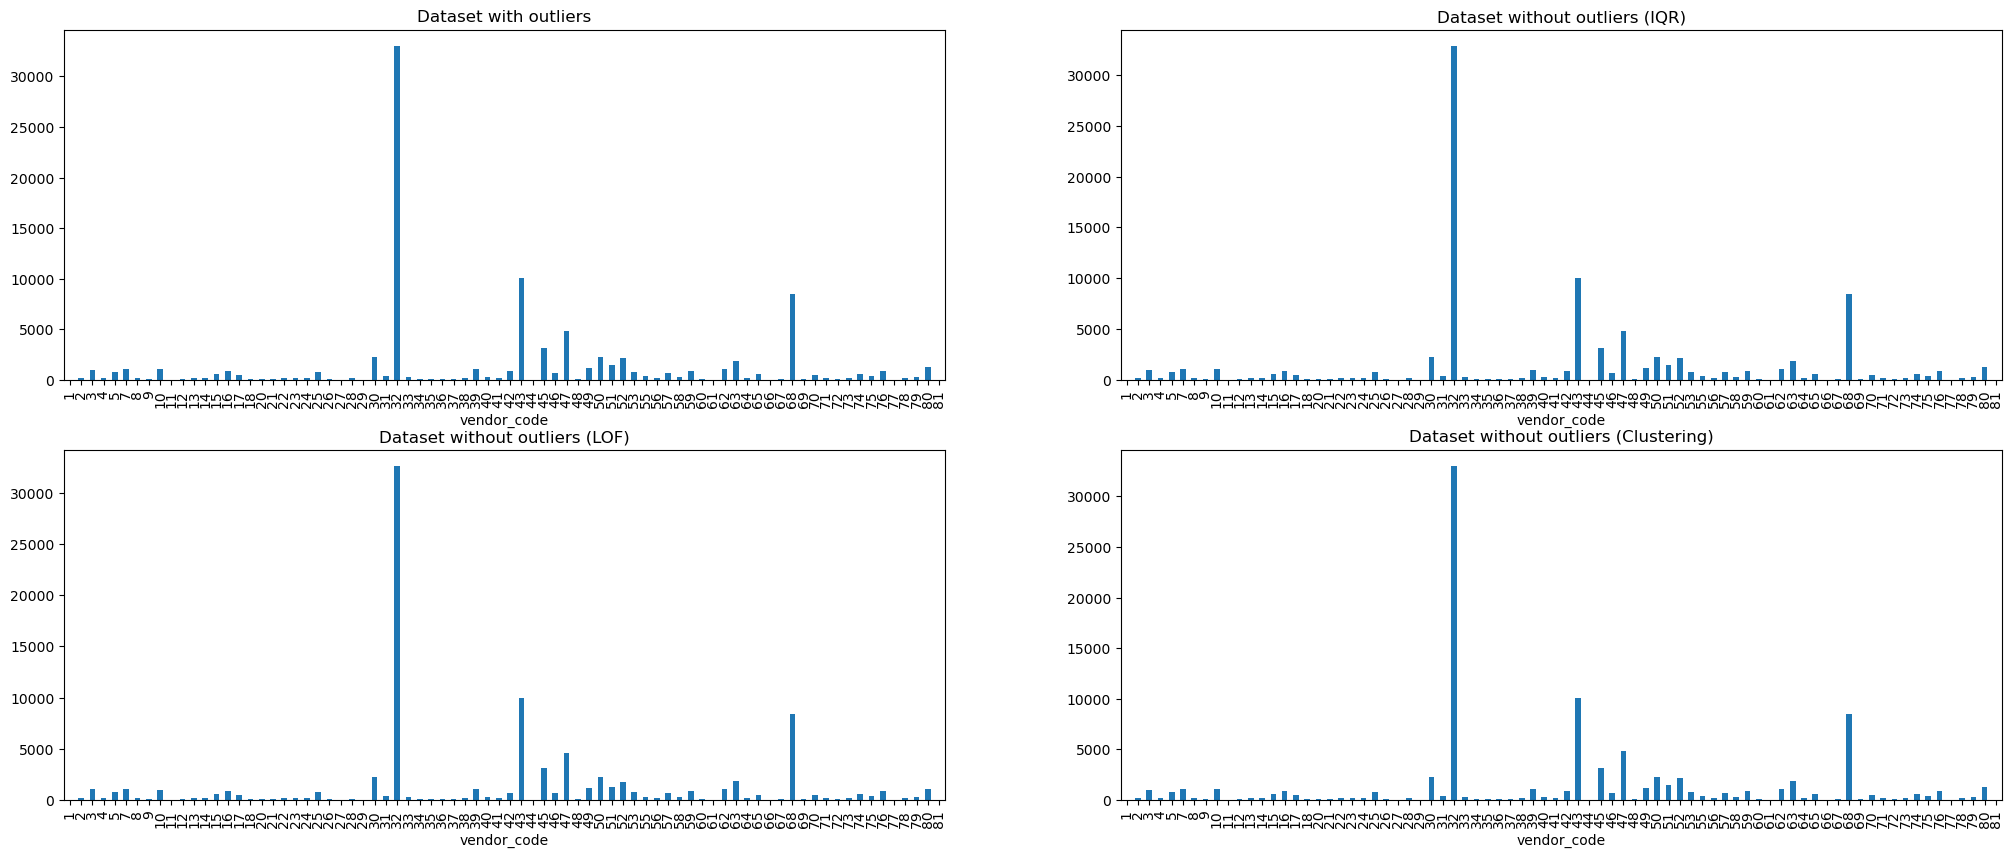

In [147]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["IAvgMonthItems"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["IAvgMonthItems"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["IAvgMonthItems"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["IAvgMonthItems"].plot(kind="bar")

plt.show()

Again, it isn't directly impacted by outliers in the original dataset.

#### TotMonthBusiness: total number of months that vendor has been selling ram for

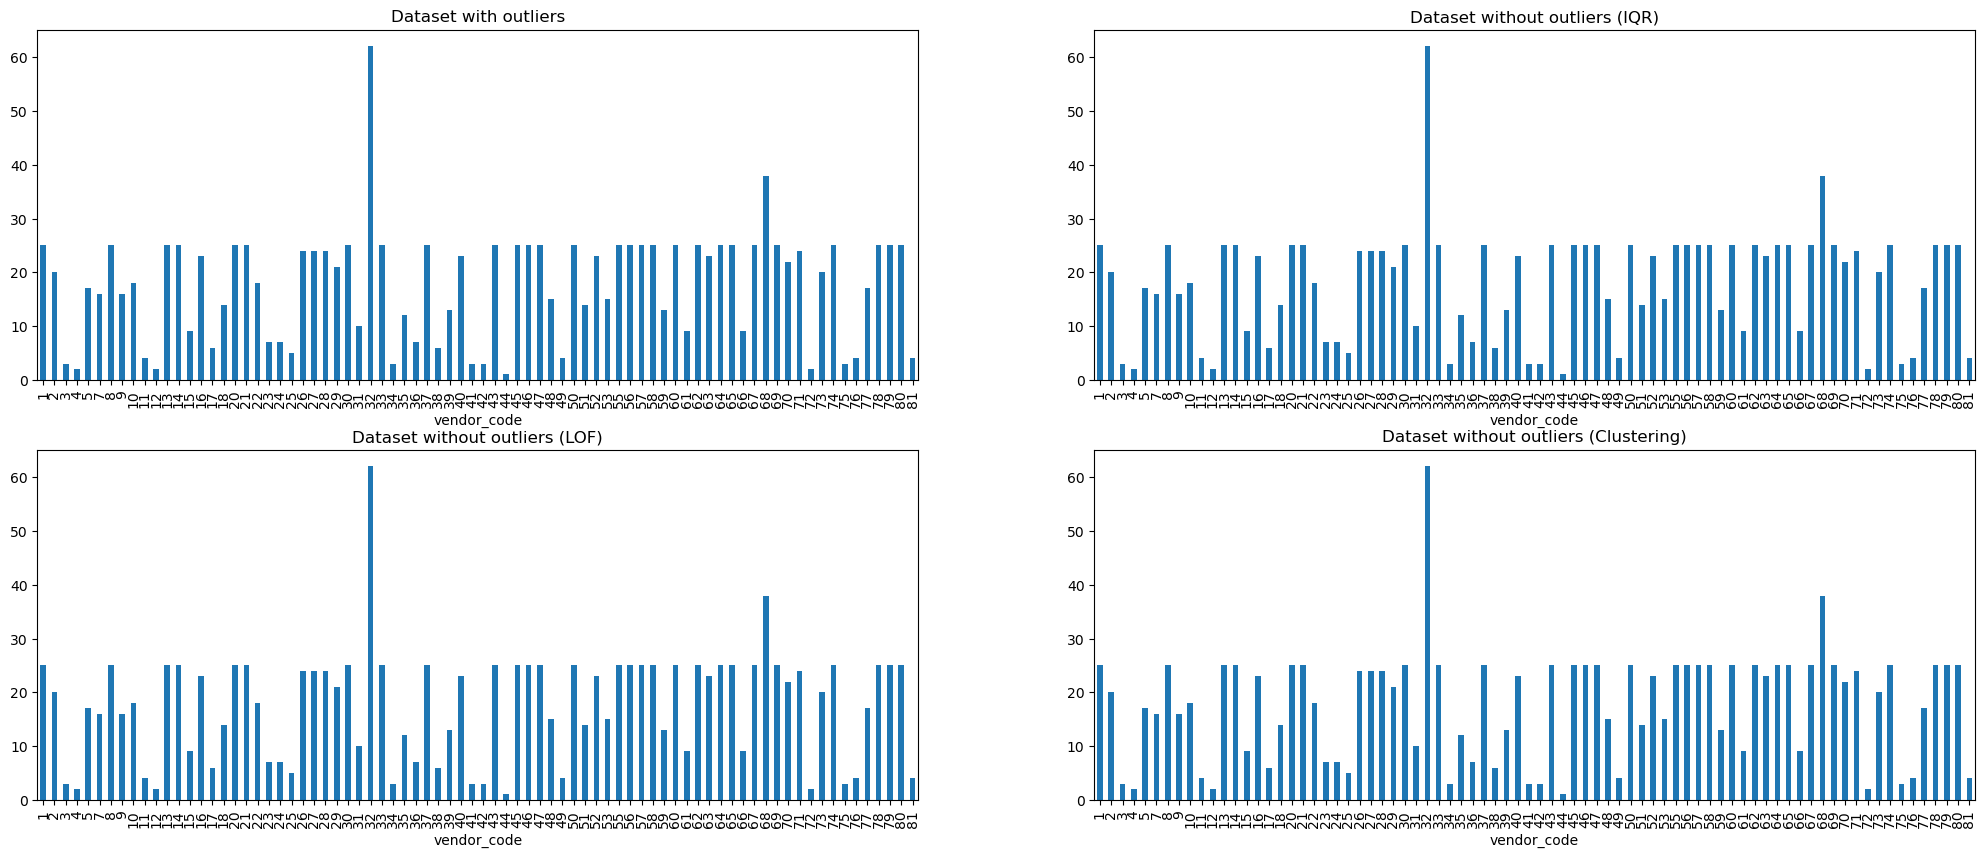

In [148]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["TotMonthBusiness"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["TotMonthBusiness"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["TotMonthBusiness"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["TotMonthBusiness"].plot(kind="bar")

plt.show()

#### Eram: Shannon's entropy of the ram modules sold

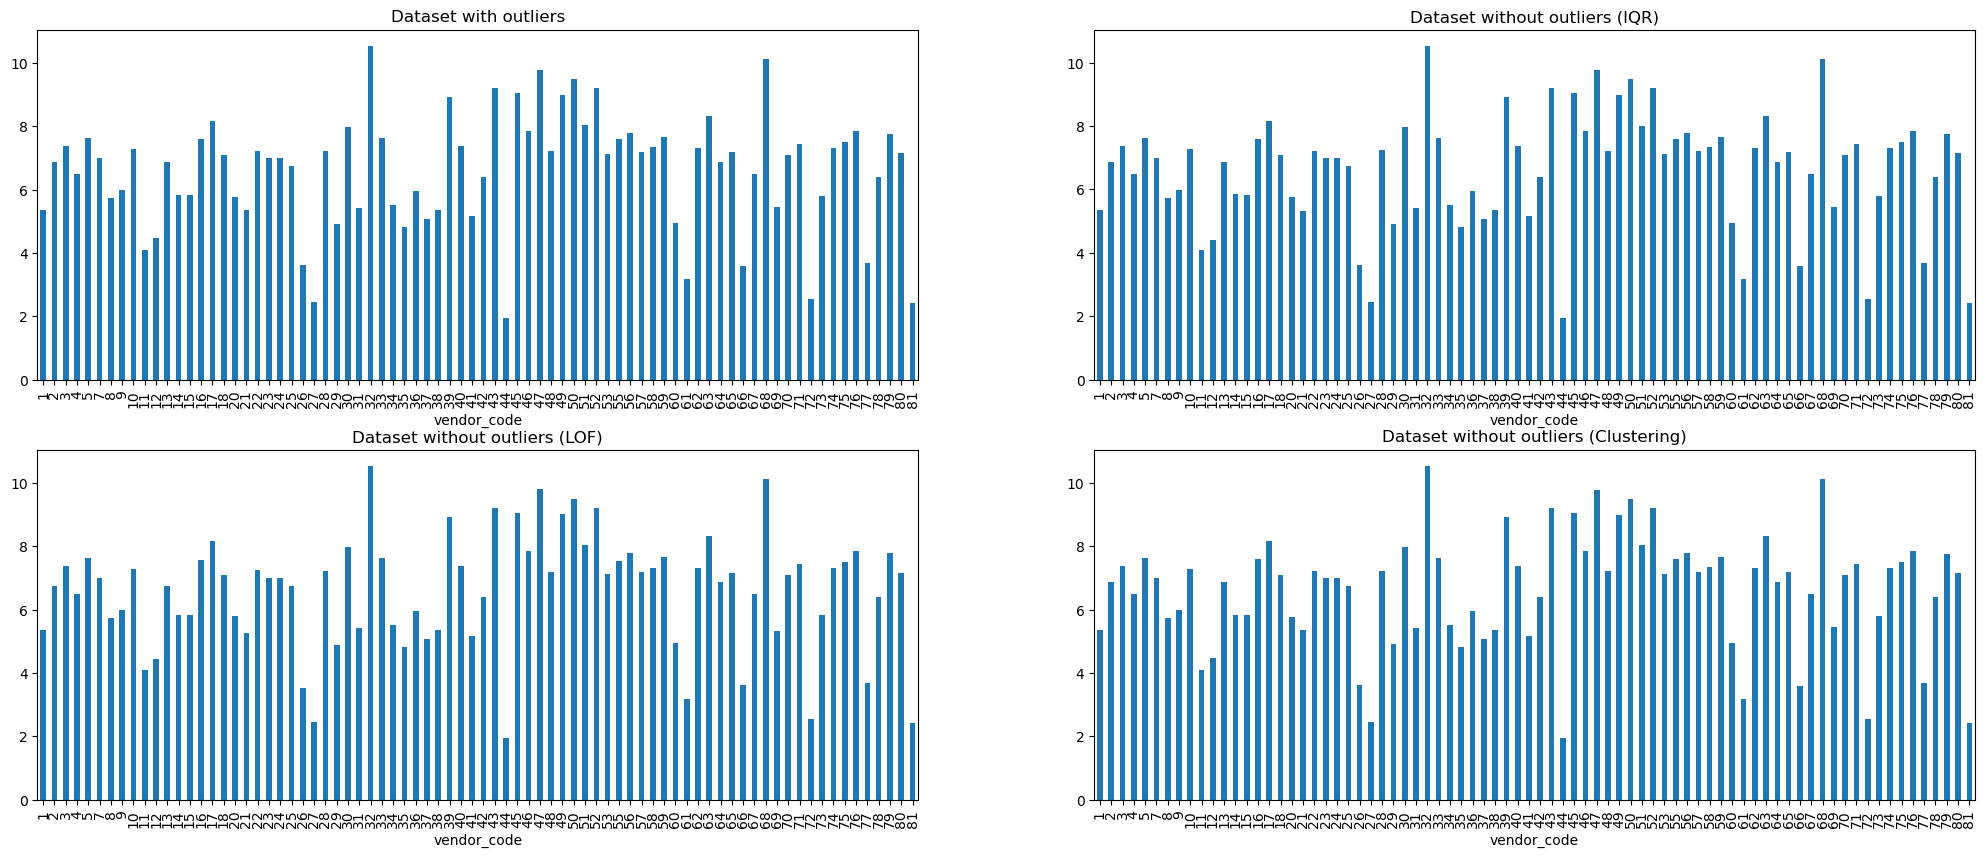

In [149]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["Eram"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["Eram"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["Eram"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["Eram"].plot(kind="bar")

plt.show()

#### Egeo: Shannon's entropy of the countries in which the sales took place

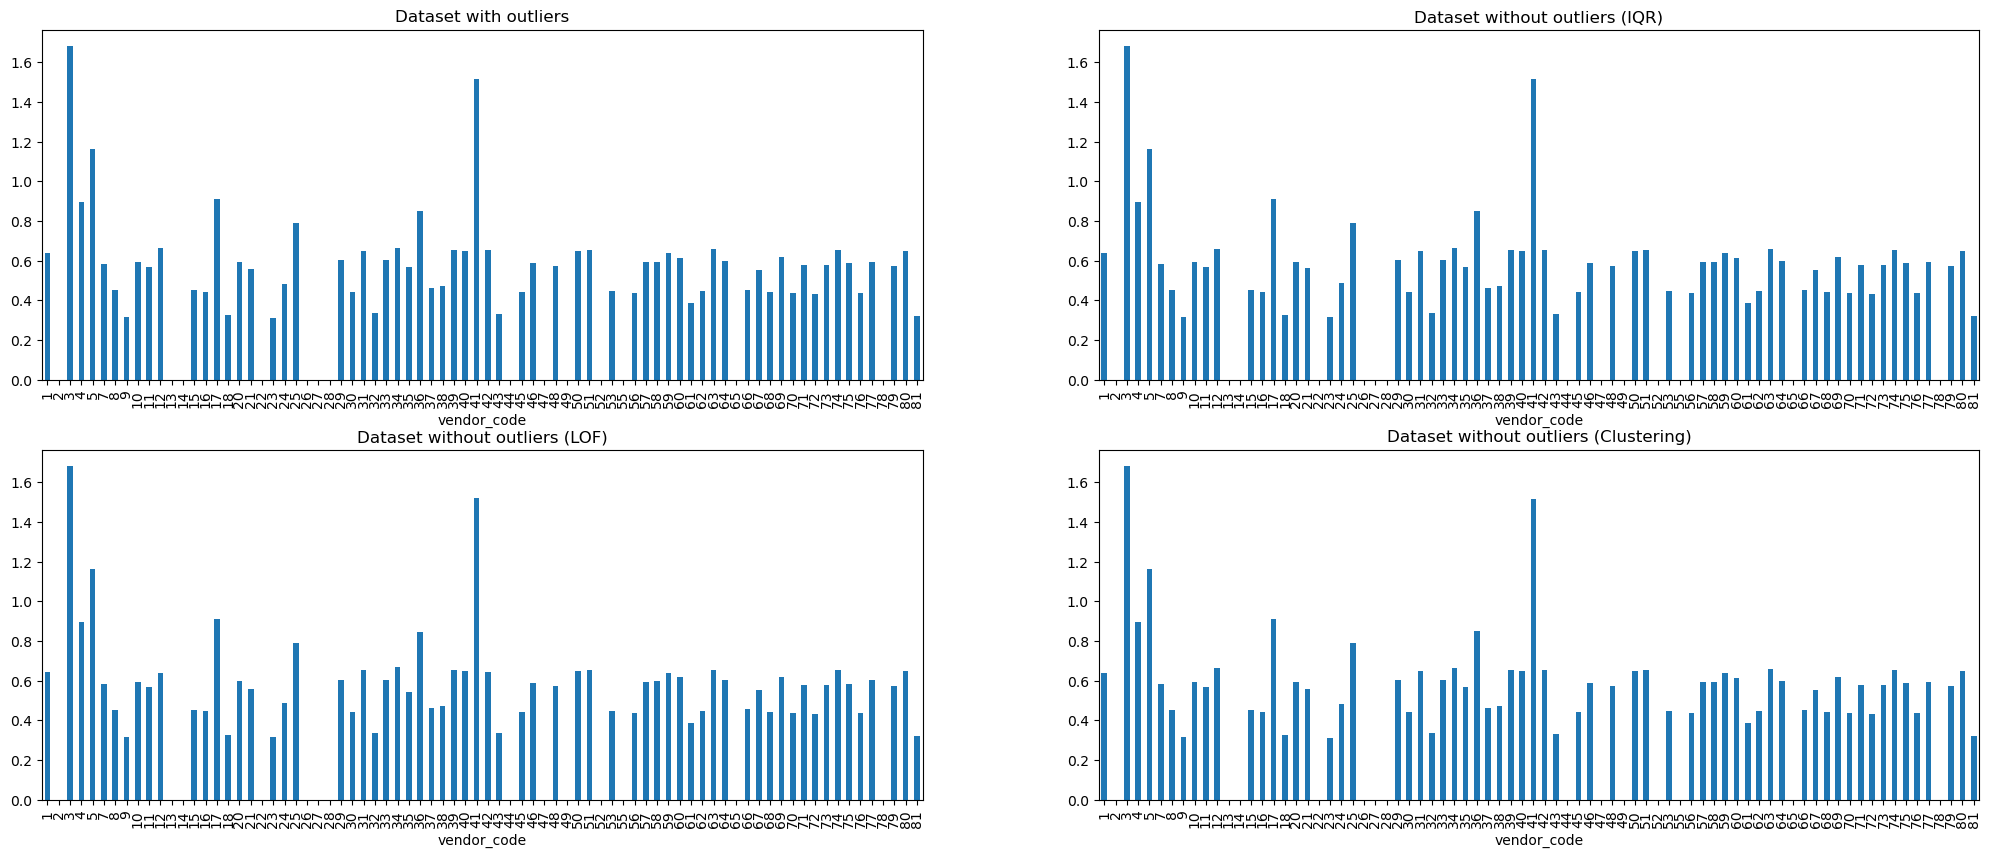

In [150]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["Egeo"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["Egeo"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["Egeo"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["Egeo"].plot(kind="bar")

plt.show()

#### Ecur: Shannon's entropy of the currencies used

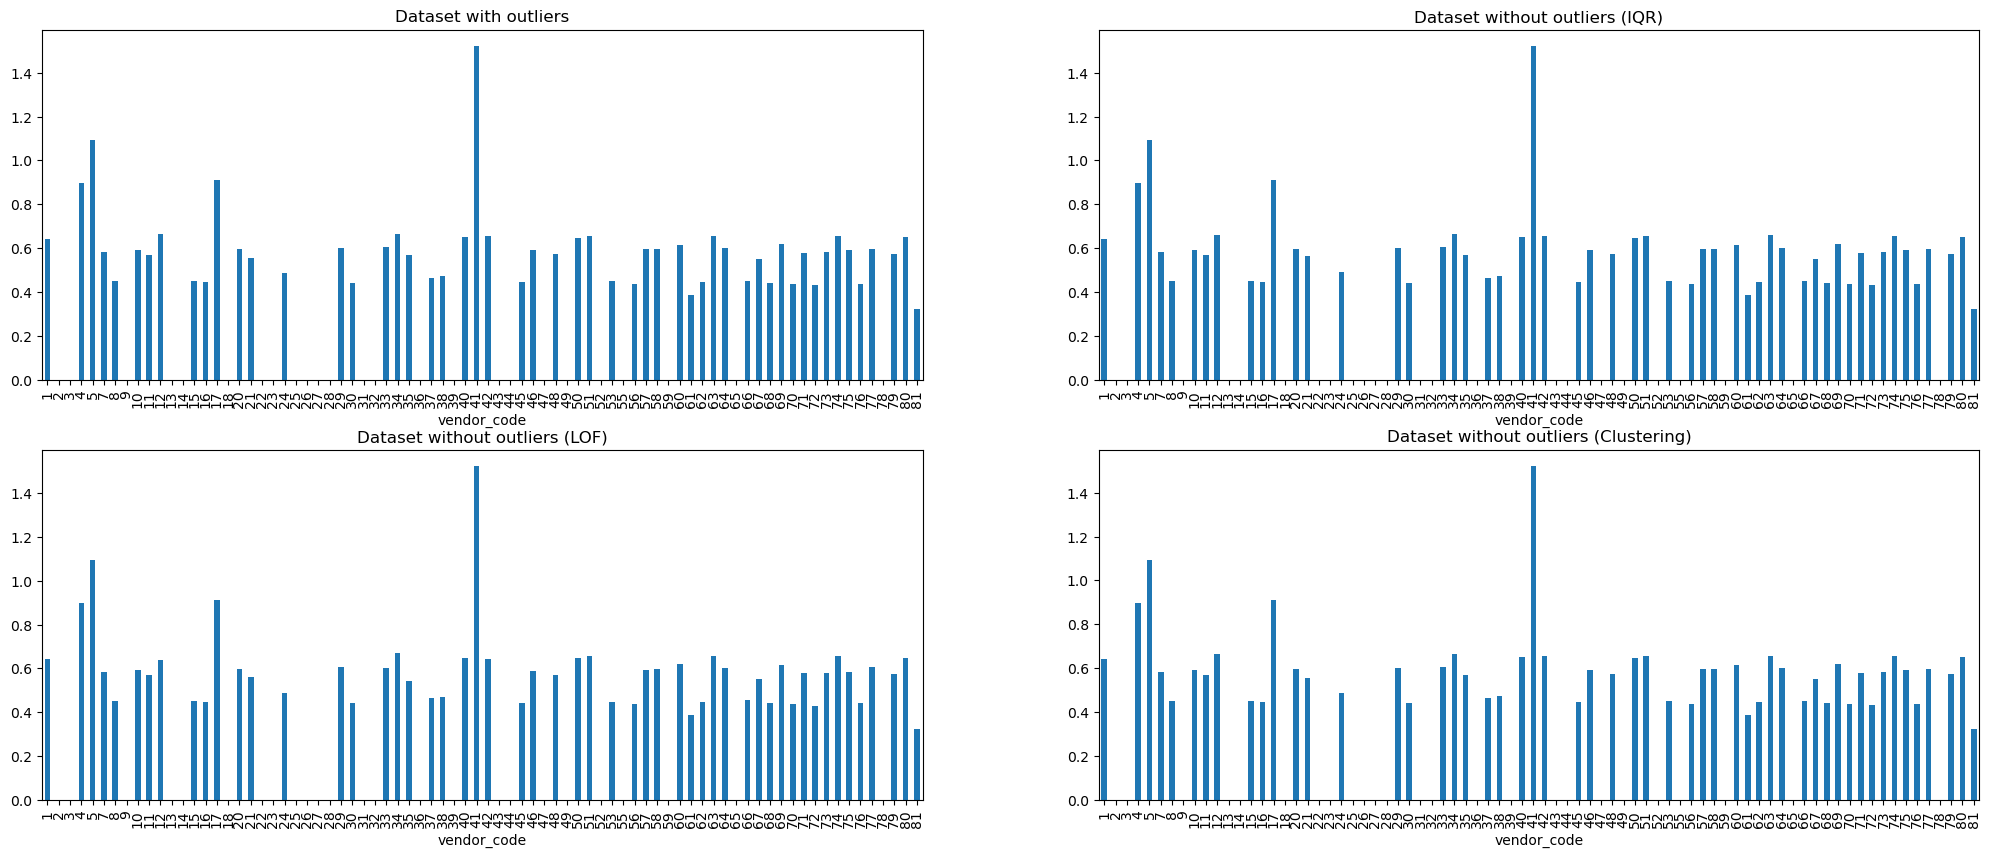

In [152]:
fig = plt.figure(figsize=(25, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
vend_df_w_out["Ecur"].plot(kind="bar")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers (IQR)")
vend_df_wo_out_iqrcox["Ecur"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Dataset without outliers (LOF)")
vend_df_wo_out_lof["Ecur"].plot(kind="bar")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Dataset without outliers (Clustering)")
vend_df_wo_out_clustering["Ecur"].plot(kind="bar")

plt.show()

The entropy-based features where barely affected by the outliers.

#### Correlations  
Let's check if the features defined above are correlated with eachother.

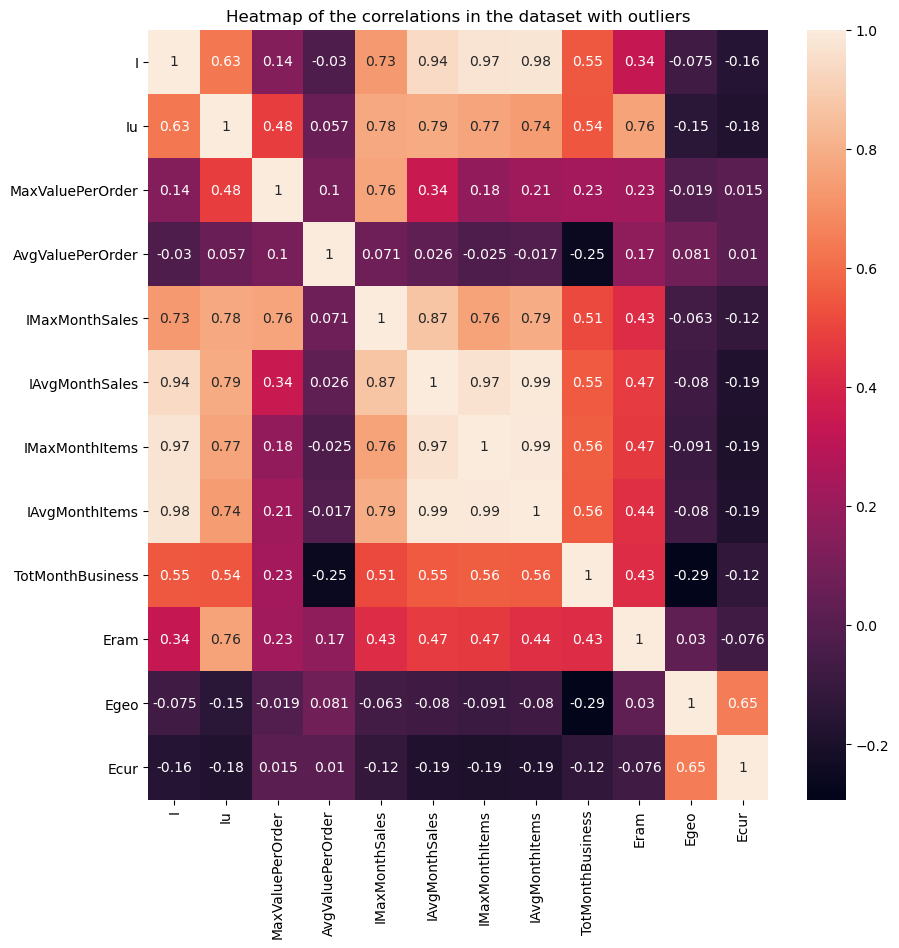

In [153]:
plt.figure(figsize=(10,10))
plt.title("Heatmap of the correlations in the dataset with outliers")
sn.heatmap(vend_df_w_out.corr(), annot=True)
plt.show()

There are many very strong correlations in here, let's list them:  
- (I, IAvgMonthSales)
- (I, IMaxMonthItems)
- (I, IAvgMonthItems)
- (IAvgMonthSales, IMaxMonthItems)
- (IAvgMonthSales, IAvgMonthItems)
- (IMaxMonthItems, IAvgMonthItems)

All of these correlations can be explained by the simple fact that the more items a vendor sells the greater the profit.

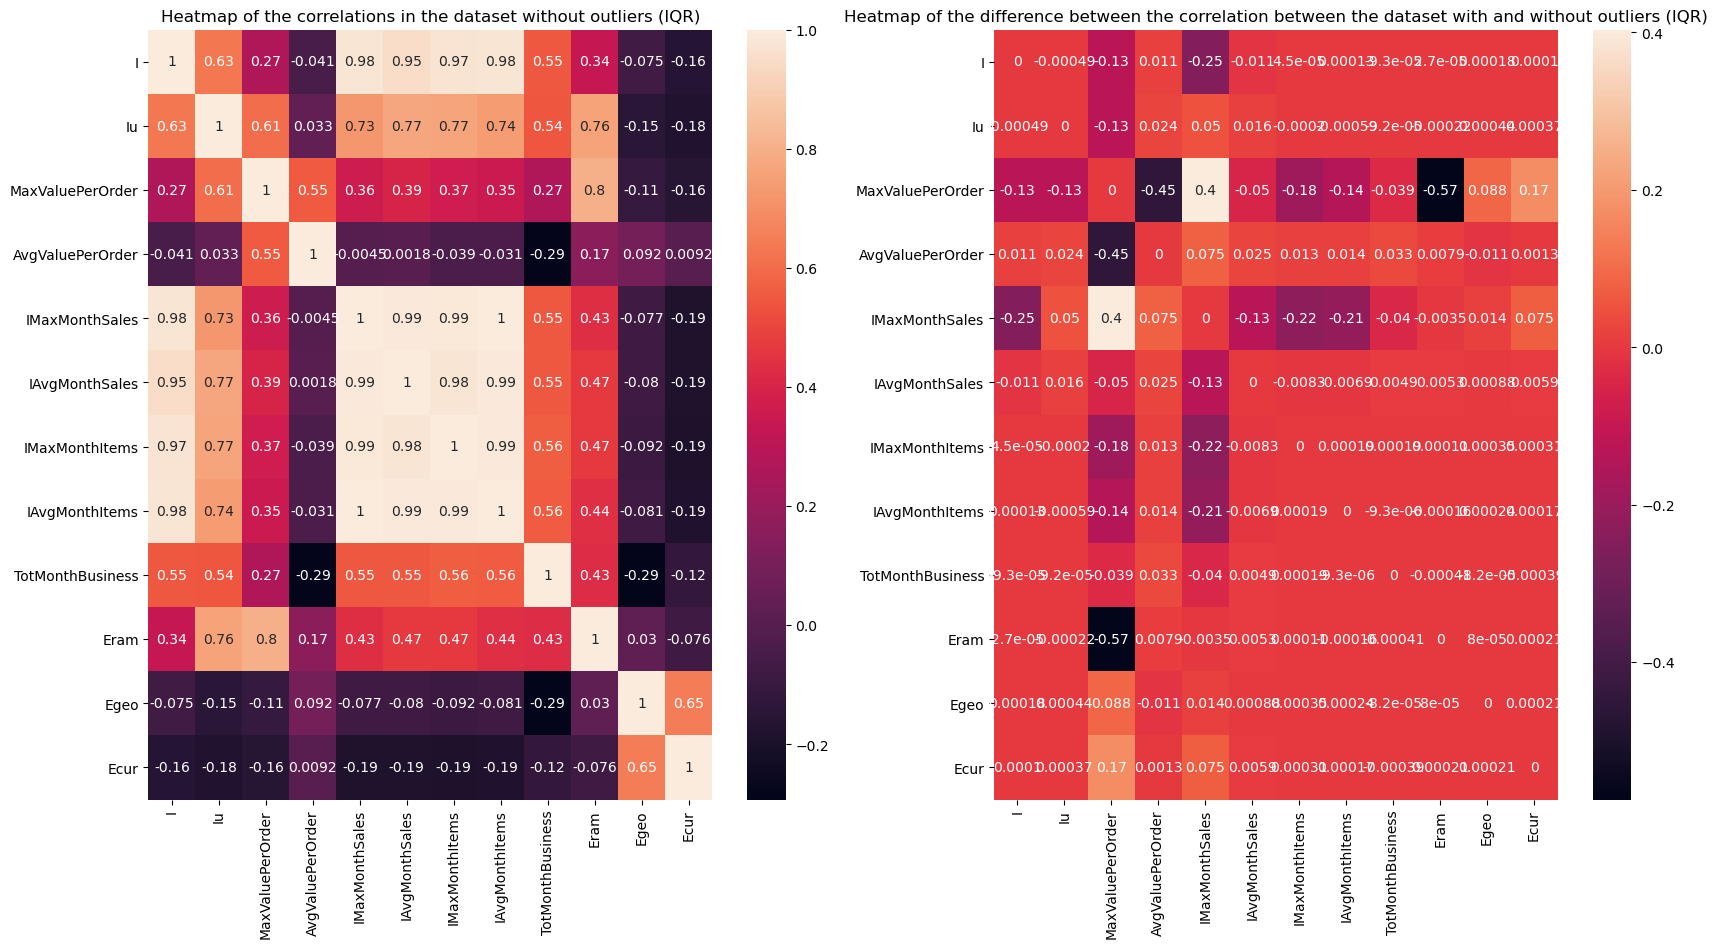

In [154]:
fig = plt.figure(figsize=(20, 10))
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Heatmap of the correlations in the dataset without outliers (IQR)")
sn.heatmap(vend_df_wo_out_iqrcox.corr(), annot=True)

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Heatmap of the difference between the correlation between the dataset with and without outliers (IQR)")
sn.heatmap(vend_df_w_out.corr()-vend_df_wo_out_iqrcox.corr(), annot=True)

plt.show()

IQR had a big impact (abs(x)>0.30) on the following correlations:  
- (MaxValuePerOrder, AvgValuePerOrder): as previously observed, while MaxValuePerOrder took a dive AvgValuePerOrder remained stable.
- (MaxValuePerOrder, IMaxMonthSales): single-handedly caused by the removal of exteme values of vendor 68
- (MaxValuePerOrder, Eram): same as for AvgValuePerOrder

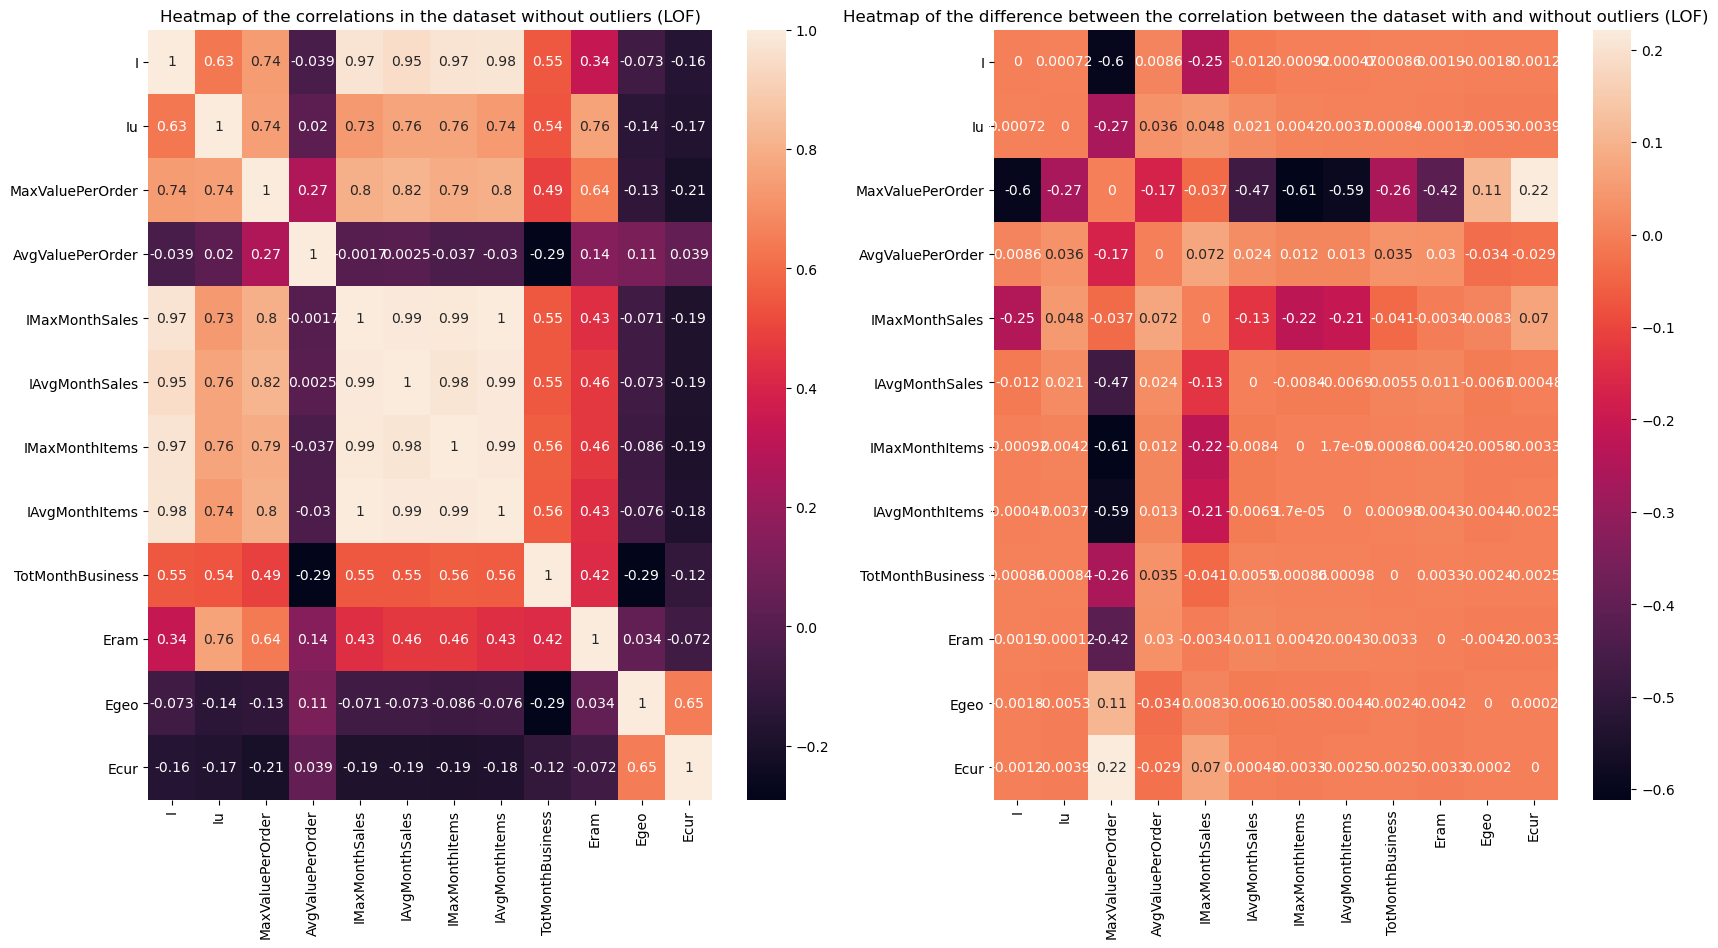

In [155]:
fig = plt.figure(figsize=(20, 10)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Heatmap of the correlations in the dataset without outliers (LOF)")
sn.heatmap(vend_df_wo_out_lof.corr(), annot=True)

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Heatmap of the difference between the correlation between the dataset with and without outliers (LOF)")
sn.heatmap(vend_df_w_out.corr()-vend_df_wo_out_lof.corr(), annot=True)

plt.show()

LOF had a big impact (abs(x)>0.30) on the following correlations:  
- (I, MaxValuePerOrder): coincidence, this is due to the particular distribution of MaxValuePerOrder after applying LOF. Note how the other methods didn't have such an high correlation.
- (MaxValuePerOrder, IAvgMonthSales)
- (MaxValuePerOrder, IMaxMonthItems)
- (MaxValuePerOrder, IAvgMonthItems)
- (MaxValuePerOrder, Eram)

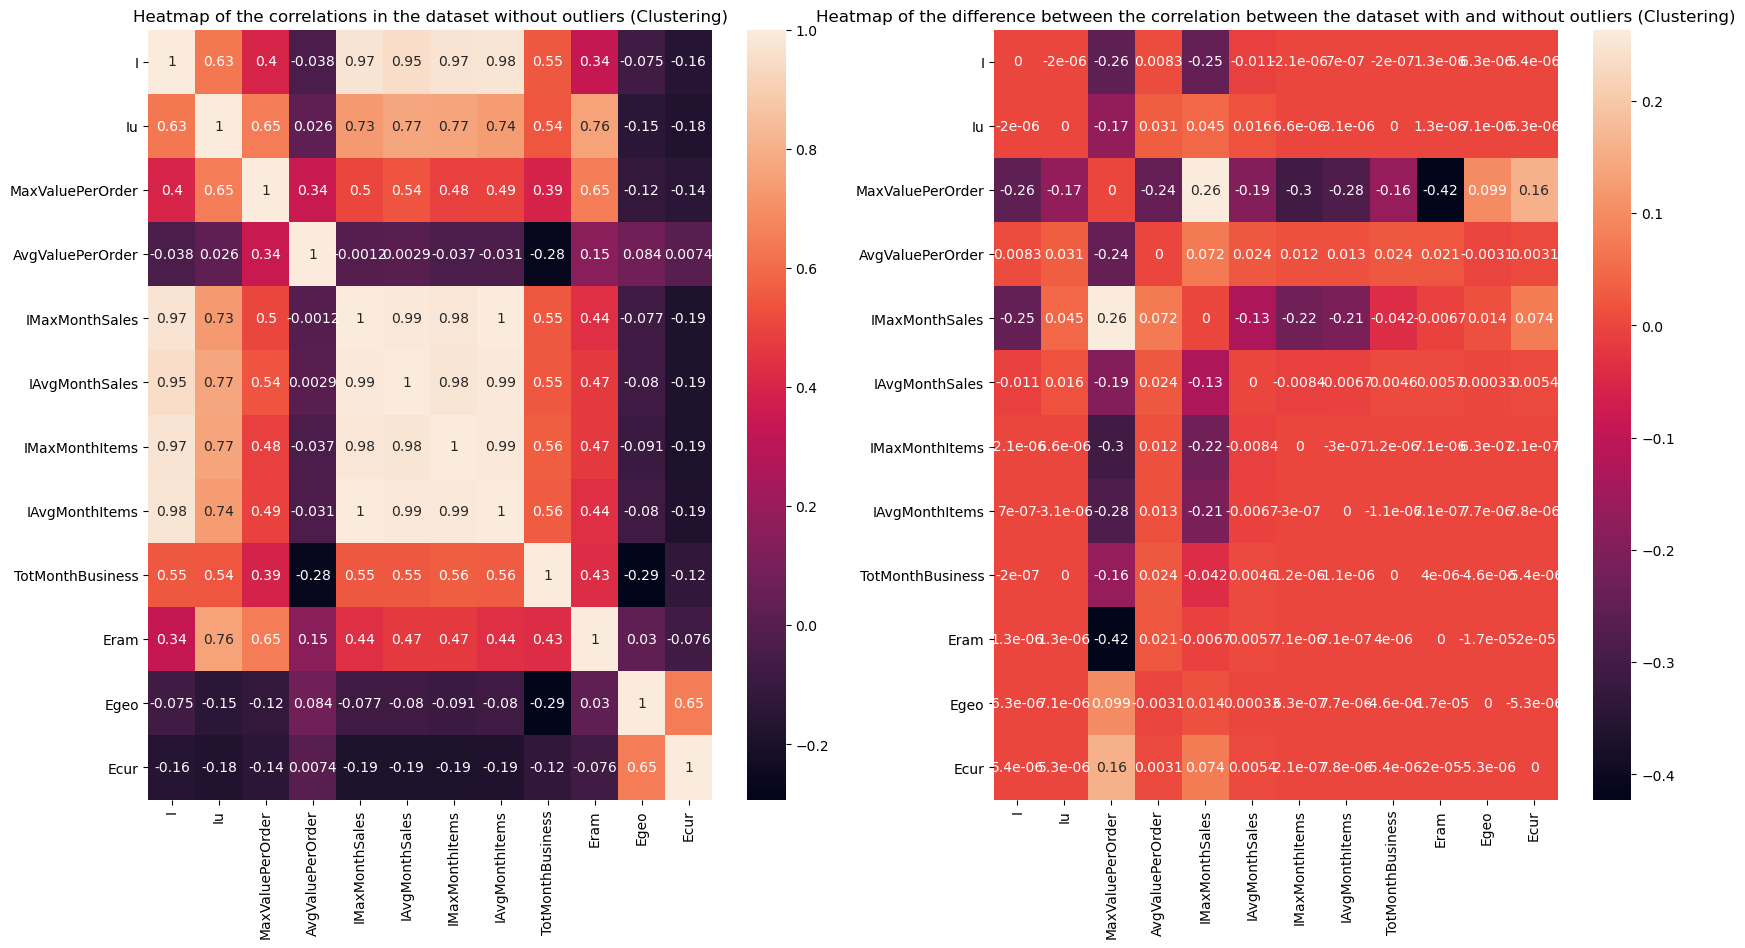

In [156]:
fig = plt.figure(figsize=(20, 10)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Heatmap of the correlations in the dataset without outliers (Clustering)")
sn.heatmap(vend_df_wo_out_clustering.corr(), annot=True)

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Heatmap of the difference between the correlation between the dataset with and without outliers (Clustering)")
sn.heatmap(vend_df_w_out.corr()-vend_df_wo_out_clustering.corr(), annot=True)

plt.show()

Clustering had a big impact (abs(x)>0.30) on the following correlations:  
- (MaxValuePerOrder, IMaxMonthItems)
- (MaxValuePerOrder, Eram)

In this case MaxValuerPerOrder changed while the other features stayed the same.

### Conclusions  
The impact on the features of the different techniques is very subtle, we think the analysis up to this point demonstrates that the clustering method gives the same results as the other methods most of the time and better in some situations while also having the benefit of removing only a small percentage of the datapoints.  
Therefore from now on we will assume that the datasets without outliers are constructed using that technique.   
Next we will check how the outliers in the vendor features dataset behave.

In [157]:
vend_df_wo_out = vend_df_wo_out_clustering

### Feature redundancy  

#### Correlation
For our analysis purposes, we don't need all of the features defined above given the high correlations between them.  
We will therefore remove these redundant features (corr > 0.90) in order to simplify future tasks.

In [158]:
vend_df_w_out_redund = vend_df_w_out.drop(["IMaxMonthSales", "IAvgMonthSales", "IMaxMonthItems", "IAvgMonthItems"], axis=1)
vend_df_wo_out_redund = vend_df_wo_out.drop(["IMaxMonthSales", "IAvgMonthSales", "IMaxMonthItems", "IAvgMonthItems"], axis=1)

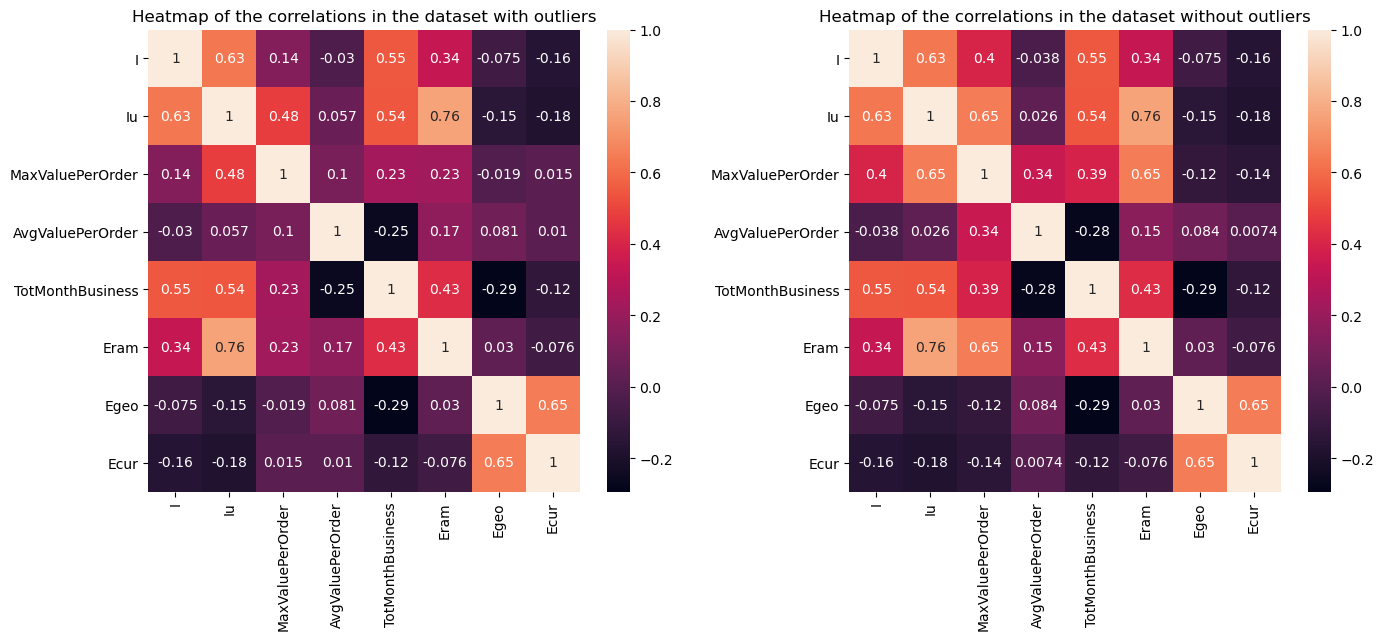

In [159]:
fig = plt.figure(figsize=(16, 6)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Heatmap of the correlations in the dataset with outliers")
sn.heatmap(vend_df_w_out_redund.corr(), annot=True)

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Heatmap of the correlations in the dataset without outliers")
sn.heatmap(vend_df_wo_out_redund.corr(), annot=True)

plt.show()

For now we will keep these 8 features in our dataset.  
However future analysis will consider possible changes to the dataset depending on the task.

### Feature outliers 

In [160]:
def boxplot_grid(df, n_rows, n_cols):
        f, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(16,7))
        for i in range(len(df.columns)):
            axs[int(i/n_cols)][i%n_cols].boxplot(df[df.columns[i]])
            axs[int(i/n_cols)][i%n_cols].set_title(df.columns[i])
        plt.show()

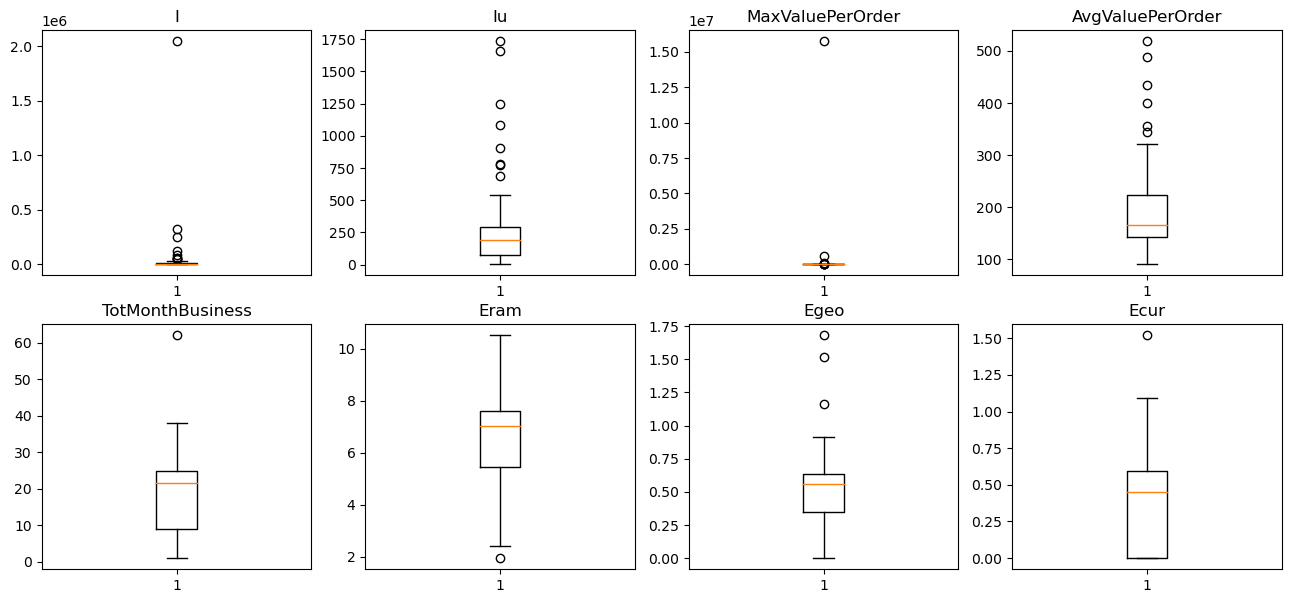

In [161]:
boxplot_grid(vend_df_w_out_redund, 2, 4)

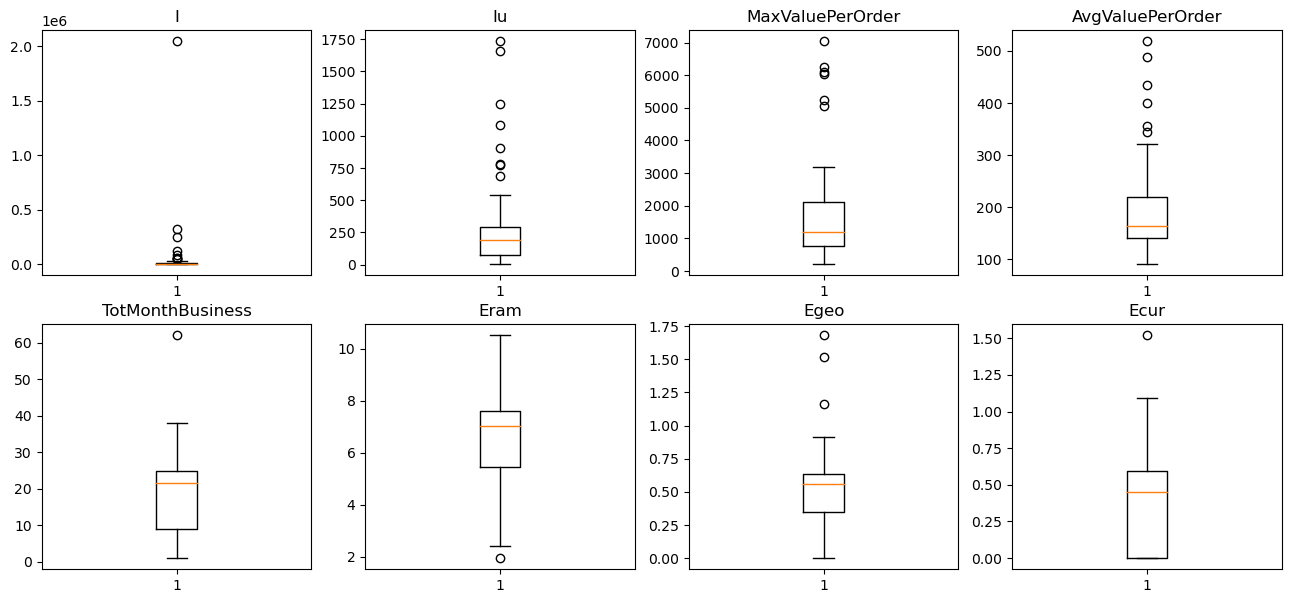

In [162]:
boxplot_grid(vend_df_wo_out_redund, 2, 4)

The different datasets without outliers behave mostly the same or as expected following the previous feature analysis.  
Regarding the outliers we are very wary of removing many datapoints given the low amount of vendors in the dataset, we prefer to leave the datasets mostly untouched.  
The only jarring datapoint is the max value in I which is an order of magnitude greater than the next biggest one and even greater compared to the median of the datapoints, therefore we will remove it.

In [163]:
vend_df_w_out_redund.loc[32]

I                   2.043095e+06
Iu                  1.733000e+03
MaxValuePerOrder    5.375409e+04
AvgValuePerOrder    1.640000e+02
TotMonthBusiness    6.200000e+01
Eram                1.051175e+01
Egeo                3.375932e-01
Ecur                0.000000e+00
Name: 32, dtype: float64

In [164]:
vend_df_w_out_redund_wo_out = vend_df_w_out_redund.drop(32)
vend_df_wo_out_redund_wo_out = vend_df_wo_out_redund.drop(32)

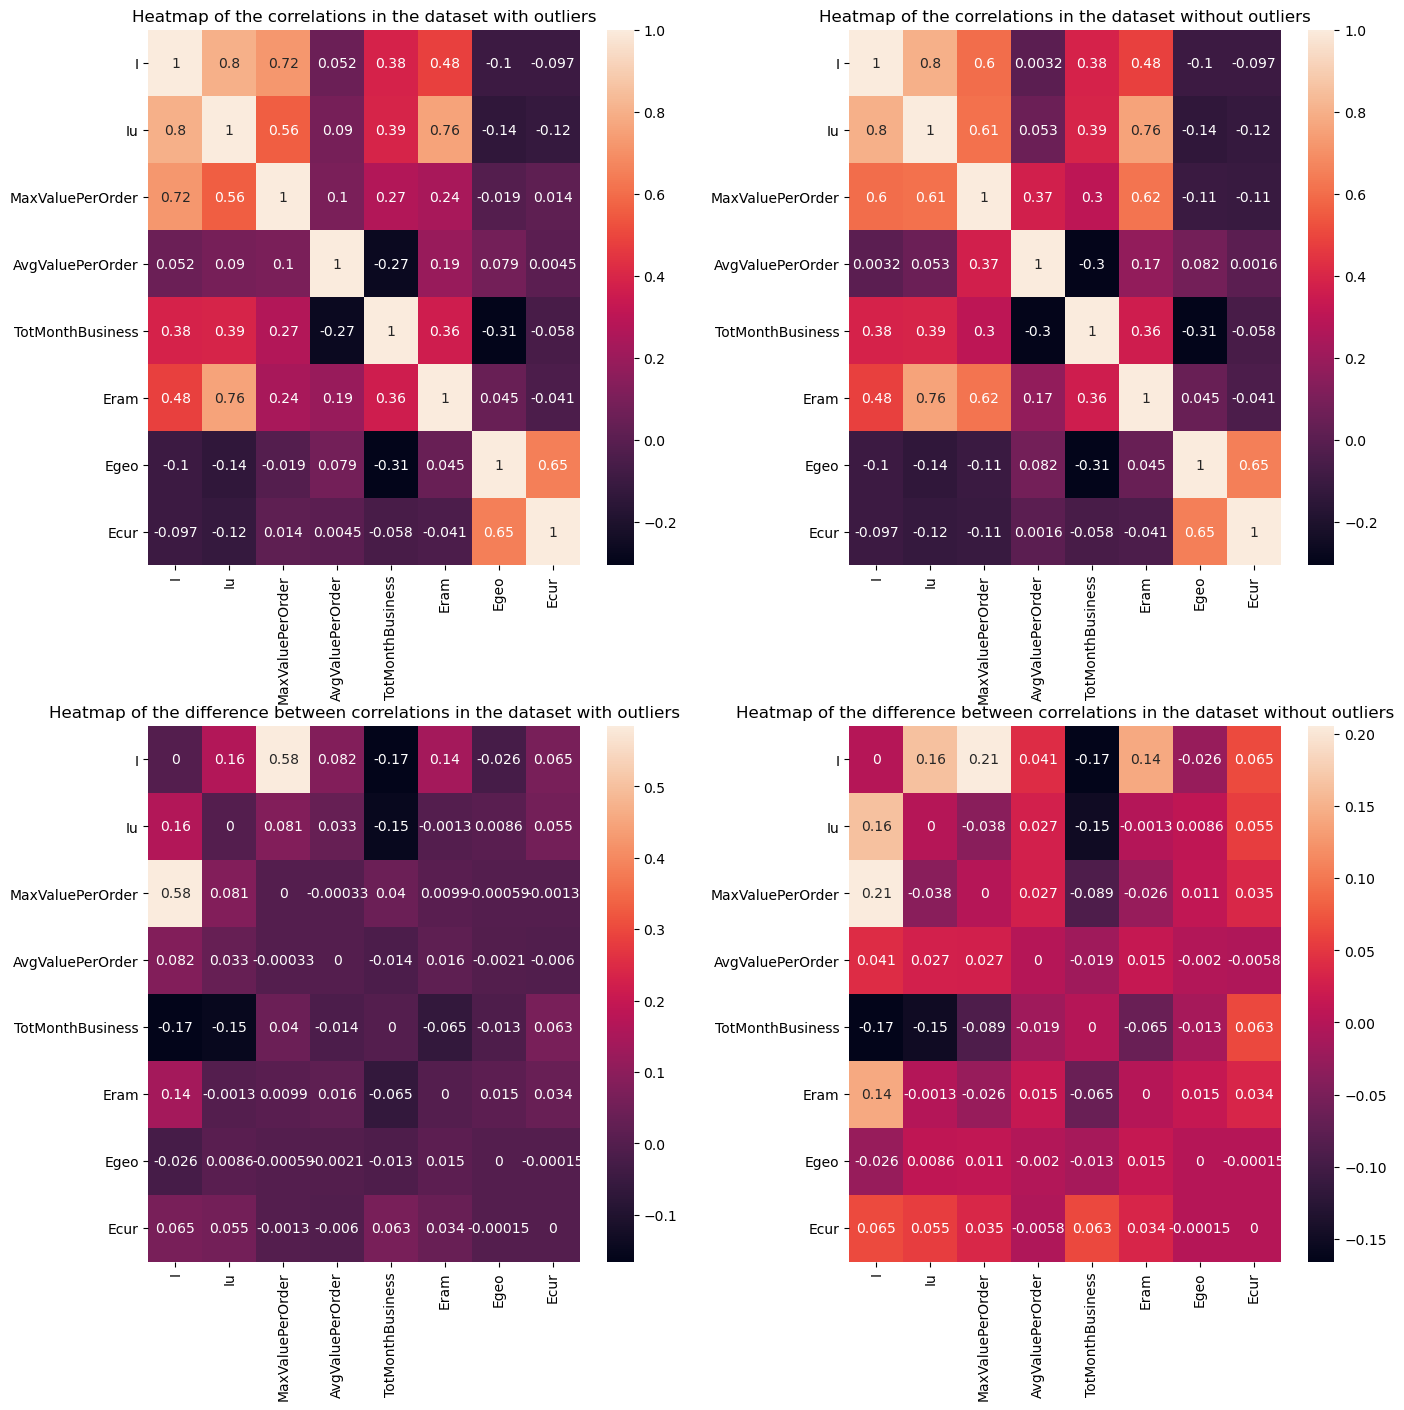

In [165]:
fig = plt.figure(figsize=(16, 16)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Heatmap of the correlations in the dataset with outliers")
sn.heatmap(vend_df_w_out_redund_wo_out.corr(), annot=True)

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Heatmap of the correlations in the dataset without outliers")
sn.heatmap(vend_df_wo_out_redund_wo_out.corr(), annot=True)

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Heatmap of the difference between correlations in the dataset with outliers")
sn.heatmap(vend_df_w_out_redund_wo_out.corr() - vend_df_w_out_redund.corr(), annot=True)

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Heatmap of the difference between correlations in the dataset without outliers")
sn.heatmap(vend_df_wo_out_redund_wo_out.corr() - vend_df_wo_out_redund.corr(), annot=True)

plt.show()

The removal of the outlier has a huge impact on the first dataset, while on the second the effect is reduced to the fact that the underlying outliers of MaxValuePerOrder have already been removed.

### Conclusions  
Given that we have already decided which outlier detection approach best suits our case and given the strong spikes/distortions caused by the datasets with outliers we will only keep the dataset without ones for the next tasks.

In [166]:
feature_df = vend_df_wo_out_redund_wo_out
feature_df.to_csv('./task1-result.csv', sep=',', index=True)